In [1]:
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random
from functools import partial

from numba import vectorize, float64, guvectorize, njit

import time
import math
from tqdm import tqdm

from jax.scipy.stats import multivariate_normal

In [2]:
key = random.PRNGKey(681998)
key1 = random.PRNGKey(698)
key2 = random.PRNGKey(61998)
subkeys = random.split(key, 5000)

In [3]:
# Generate data from stable distribution
@partial(jit, static_argnames=['dataset_size', 'num_datasets'])
def simulate_gandk(theta, dataset_size, num_datasets, c = 0.8):
    zu = random.normal(key, shape = (num_datasets, dataset_size))
    f = (theta[0] + theta[1] * (1 + c * (1 - jnp.exp(-theta[2] * zu)) / (1 + jnp.exp(-theta[2] * zu))) * (1 + zu**2)**theta[3] * zu)
    return f

In [4]:
true_theta = jnp.array([3, 1, 2, 0.5])
num_coeffs = 4
num_latent = 4
num_samples = 200
num_datasets = 200
lambda_dim = num_coeffs + int((num_coeffs * (num_coeffs + 1)) / 2)

sigma_theta = 10
sigma_latent = 10

In [5]:
actual_data = simulate_gandk(true_theta, num_samples, 1)
actual_data

Array([[ 2.679051 ,  2.7078536,  2.7666173,  4.6026545,  3.10263  ,
         8.21348  ,  5.0002713,  2.4443326,  4.003392 ,  6.977167 ,
         4.416902 ,  2.253936 ,  2.7770712,  2.4987235,  2.1537213,
         2.3501523,  2.3731253,  2.995241 ,  2.17607  ,  2.6346066,
         2.674958 ,  3.9907615,  2.8300614,  2.5475497,  2.4890113,
         2.3200982,  2.415167 ,  2.3534298,  2.4810355,  2.1430666,
         2.5279832,  7.2944636,  2.0107138,  2.762278 ,  4.8681526,
         2.756834 ,  4.6048927,  4.4016137,  6.7766447,  2.7055788,
         6.247609 ,  2.45787  ,  3.228757 ,  3.816874 ,  7.7279816,
         5.457468 ,  4.269319 ,  2.8978431,  3.6603773,  2.33273  ,
         3.669119 ,  3.662523 ,  2.4835272, 17.83812  ,  2.6027977,
         1.9483998,  3.5228345,  3.259381 ,  2.7290843,  4.6666083,
         3.5917392,  3.9732397,  2.5860608,  6.8926706,  3.7133665,
         5.151161 ,  1.9681518,  2.8990269,  2.4748297,  2.756674 ,
         2.8200583,  3.6020112,  5.82837  ,  2.4

In [6]:
# CALCULATE SUMMARY STATS
@jit
def compute_summary_statistics(y):
    quant_y = []
    for i in jnp.arange(0.125, 1, 0.125):
        quant_y.append(jnp.quantile(y, i))
    Sa = quant_y[3]
    Sb = quant_y[5] - quant_y[1]
    Sc = (quant_y[5] + quant_y[1] - 2 * quant_y[3]) / Sb
    Sd = (quant_y[6] - quant_y[4] + quant_y[2] - quant_y[0]) / Sb
    return jnp.array([Sa, Sb, Sc, Sd])

In [7]:
actual_summary_statistics = compute_summary_statistics(actual_data)
actual_summary_statistics

Array([2.962445 , 1.6464472, 0.4953957, 1.6801826], dtype=float32)

In [8]:
def my_inv(x):
    return jnp.linalg.inv(x + (jnp.eye(x.shape[0]) * 1e-7))

In [9]:
def summary_statistics(theta, n_samples, n_datasets):
    datasets = simulate_gandk(true_theta, n_samples, n_datasets)
    n_summary_statistics = jnp.array([compute_summary_statistics(datasets[i,:]) for i in range(n_datasets)])
    sample_mean = jnp.mean(n_summary_statistics, axis = 0)
    cov = jnp.cov(n_summary_statistics.T)
    sample_variance = cov + (jnp.eye(cov.shape[0]) * 5 * 1e-7)

    return sample_mean, sample_variance

In [10]:
def mean_adjustment_summary_statistics(adjusted_theta, n_samples, n_datasets):
    theta = adjusted_theta[0:num_coeffs]
    Gamma = adjusted_theta[-num_latent:]
    sample_mean, sample_variance = summary_statistics(theta, n_samples, n_datasets)

    adjusted_sample_mean = sample_mean + jnp.diag(jnp.sqrt(sample_variance)) * Gamma
    return adjusted_sample_mean, sample_variance

In [11]:
@partial(jit, static_argnames=['sigma_theta','num_coeffs'])
def prior(theta, sigma_theta, num_coeffs):
    log_prior = jnp.sum(jnp.log(jnp.exp(theta) / (1 + jnp.exp(theta))**2))
    return log_prior

In [12]:
def mean_adjustment_unbiased_log_likelihood(gs_adjusted_theta, n_samples, num_datasets):
    mean_adjust_ss = mean_adjustment_summary_statistics(gs_adjusted_theta, n_samples, num_datasets)
    adjusted_sample_mean = mean_adjust_ss[0]
    sample_variance = mean_adjust_ss[1]
    u_est_log_likelihood = multivariate_normal.logpdf(actual_summary_statistics, mean = adjusted_sample_mean, cov= sample_variance)

    return u_est_log_likelihood

In [13]:
@jit
def nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance, variance_nuissance):
    nuissance_mean_u_est_log_likelihood = multivariate_normal.logpdf(Gamma, mean = mean_nuissance, cov= variance_nuissance)
    return nuissance_mean_u_est_log_likelihood

In [14]:
@jit
def fun_log_q(theta, mu, l):
    log_q = multivariate_normal.logpdf(theta, mean = mu, cov= my_inv(l @ l.T))
    return log_q

In [15]:
@partial(jit, static_argnames=['num_coeffs'])
def gradient_log_q(theta, mu, l, num_coeffs): #indep theta
    gradient_log_q_mu = l @ l.T @ (theta - mu)
    # gradient_log_q_l = (np.diag(np.linalg.inv(l)) - np.matmul(((np.reshape(theta - mu, (num_coeffs,1))) * theta - mu), l)).T[np.triu_indices(num_coeffs)] #use * because matmul gives scalar
    diag_inv_l = jnp.zeros_like(l, shape=(num_coeffs,num_coeffs)).at[jnp.diag_indices_from(l)].set(jnp.diag(l))
    gradient_log_q_l = (diag_inv_l - jnp.reshape(theta - mu, (num_coeffs,1)) @ jnp.reshape(theta - mu, (1,num_coeffs)) @ l).T[jnp.triu_indices(num_coeffs)] #use * because matmul gives scalar
    return gradient_log_q_mu, gradient_log_q_l

In [16]:
@jit
def control_variates(Flat_grad_log_q, Flat_grad_lb):
    c = []
    stacked_gradient_lb = jnp.stack(Flat_grad_lb)
    stacked_gradient_log_q = jnp.stack(Flat_grad_log_q)
    for i in range(lambda_dim):
        sample_cov = jnp.cov(stacked_gradient_lb[:, i], stacked_gradient_log_q[:, i])
        c_i = sample_cov[0, 1] / sample_cov[1, 1]
        c.append(c_i)
    c_mu = jnp.array(c[0:num_coeffs])
    c_vech_l = jnp.array(c[num_coeffs:])
    return c_mu, c_vech_l

In [17]:
class GVB:
    def __init__(self, samples, actual_summary_statistics, learning_rate, threshold, l_threshold, adaptive_lr_1, adaptive_lr_2, t_w, Patience):
        self.samples = samples
        self.actual_summary_statistics = actual_summary_statistics
        self.num_coeffs = np.shape(actual_summary_statistics)[0] # number of coeffs
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.l_threshold = l_threshold
        self.adaptive_lr_1 = adaptive_lr_1
        self.adaptive_lr_2 = adaptive_lr_2
        self.t_w = t_w
        self.Patience = Patience

    def fun_gradient_lb(self, theta_tilde_q, mu_q, l_q, c_mu, c_l):
        # Calculate theta from mu, l (lambda)
        # alpha_q = (10 * jnp.exp(theta_tilde_q[0]) + 0) / (1 + jnp.exp(theta_tilde_q[0]))
        # beta_q = (10 * jnp.exp(theta_tilde_q[1]) + 0) / (1 + jnp.exp(theta_tilde_q[1]))
        # gamma_q = (10 * jnp.exp(theta_tilde_q[2]) + 0) / (1 + jnp.exp(theta_tilde_q[2]))
        # delta_q = (10 * jnp.exp(theta_tilde_q[3]) + 0) / (1 + jnp.exp(theta_tilde_q[3]))

        alpha_q = (5 * jnp.exp(theta_tilde_q[0]) + 0) / (1 + jnp.exp(theta_tilde_q[0]))
        beta_q = (2 * jnp.exp(theta_tilde_q[1]) + 0) / (1 + jnp.exp(theta_tilde_q[1]))
        gamma_q = (3 * jnp.exp(theta_tilde_q[2]) + 0) / (1 + jnp.exp(theta_tilde_q[2]))
        delta_q = (1 * jnp.exp(theta_tilde_q[3]) + 0) / (1 + jnp.exp(theta_tilde_q[3]))


        theta_q = jnp.array([alpha_q, beta_q, gamma_q, delta_q])

        ss_q = summary_statistics(theta_q, num_samples, num_datasets)
        sample_mean_q = ss_q[0]
        sample_variance_q = ss_q[1]
        # Nuissance mean and variance
        mean_nuissance_p1 = my_inv(jnp.identity(num_latent) / sigma_latent + jnp.diag(jnp.sqrt(sample_variance_q)).T @ my_inv(sample_variance_q) @ jnp.diag(jnp.sqrt(sample_variance_q)))
        diag_var = jnp.zeros((num_coeffs, num_coeffs)).at[jnp.diag_indices_from(sample_variance_q)].set(jnp.diag(jnp.sqrt(sample_variance_q)))
        diff_mean = actual_summary_statistics - sample_mean_q
        mean_nuissance_p2 = diag_var @ my_inv(sample_variance_q) @ diff_mean
        mean_nuissance_q = mean_nuissance_p1 @ mean_nuissance_p2

        variance_nuissance_q = mean_nuissance_p1

        # Generate Gamma
        Gamma = random.multivariate_normal(key2, mean = mean_nuissance_q, cov = variance_nuissance_q)
        adjusted_theta_q = jnp.concatenate((theta_q, Gamma))

        # Find gradient of LB
        llh = mean_adjustment_unbiased_log_likelihood(adjusted_theta_q, num_samples, num_datasets)
        llh_gamma = nuissance_mean_adjustment_unbiased_log_likelihood(Gamma, mean_nuissance_q, variance_nuissance_q)

        h_lambda = prior(theta_tilde_q, sigma_theta, num_coeffs) + prior(Gamma, sigma_latent, num_latent) + llh - fun_log_q(theta_tilde_q, mu_q, l_q) - llh_gamma

        # print(llh)
        # print(Gamma)
        # print(llh_gamma)
        # Find gradient of LB
        grad_log_q_mu, grad_log_q_l = gradient_log_q(theta_tilde_q, mu_q, l_q, num_coeffs)
        gradient_lb_mu = grad_log_q_mu * (h_lambda - c_mu)
        gradient_lb_l = grad_log_q_l * (h_lambda - c_l)
        # Calculate control variates
        flattened_gradient_log_q = jnp.concatenate((grad_log_q_mu, grad_log_q_l), axis = None)
        flattened_gradient_lb = jnp.concatenate((gradient_lb_mu, gradient_lb_l), axis = None)

        return gradient_lb_mu, gradient_lb_l, h_lambda, flattened_gradient_log_q, flattened_gradient_lb

    def vb_posterior(self, stop):
        # Initialize mu_0, L_0
        # mu_0 = np.array([np.log((self.actual_summary_statistics[0]-1.1)/(2-self.actual_summary_statistics[0])), np.log((1+self.actual_summary_statistics[1])/(1-self.actual_summary_statistics[1])), np.log(self.actual_summary_statistics[2]), self.actual_summary_statistics[3]])
        # mu_0 = np.array([1.5, 0.5, 3, 0])
        mu_0 = jnp.array([jnp.log((true_theta[0]-0)/(5-true_theta[0])), jnp.log((true_theta[1]-0)/(2-true_theta[1])), jnp.log((true_theta[2]-0)/(3-true_theta[2])), jnp.log((true_theta[3]-0)/(1-true_theta[3]))])
        #mu_0 = np.array([self.actual_summary_statistics[0], self.actual_summary_statistics[1], self.actual_summary_statistics[2], self.actual_summary_statistics[3]])
        mu_0 = np.array([0] * self.num_coeffs)
        # l_0 = jnp.tril(jnp.identity(self.num_coeffs) * 10)
        l_0 = jnp.array([[42.5611843 , -8.28970004,  5.43955494, -1.25900294],
                  [-8.28970004,  7.88174052, -1.33079381,  2.31714084],
                  [ 5.43955494, -1.33079381,  4.66869461, -0.42495144],
                  [-1.25900294,  2.31714084, -0.42495144,  3.30653549]])

        Sigma_0_inv = l_0 @ l_0.T
        Sigma_0 = my_inv(Sigma_0_inv)
        ### Change ways to get vech(l0)
        vech_l0 = l_0.T[jnp.triu_indices(self.num_coeffs)]

        # Initilize best lambda
        lambda_best_mu = mu_0
        lambda_best_l = vech_l0
        # List of calculations of LB
        LB_all = []
        LB_Smoothed = []
        patience = 0
        # List of flattened gradients
        Flattened_gradient_lb = []
        Flattened_gradient_log_q = []

        func_auto = vmap(self.fun_gradient_lb, in_axes=[0, None, None, None, None])

        for t in tqdm(range(stop)):
            if t == 0:
                # Draw samples of theta from  variational q
                # List of gradients
                theta_0_samples = random.multivariate_normal(subkeys[t], mean = mu_0, cov = Sigma_0, shape = (self.samples,))
                gradient_lb_mu_0, gradient_lb_l_0, lb_0, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_0_samples, mu_0, l_0, 0, 0)
                # Calculate control variates using all samples
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                self.g_mu_init = jnp.mean(gradient_lb_mu_0, axis = 0)
                self.g_vech_l_init = jnp.mean(gradient_lb_l_0, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None)) > self.l_threshold:
                    self.g_mu_init = self.l_threshold * self.g_mu_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                    self.g_vech_l_init = self.l_threshold * self.g_vech_l_init / jnp.linalg.norm(jnp.concatenate((self.g_mu_init, self.g_vech_l_init), axis = None))
                self.v_mu_init = self.g_mu_init ** 2
                self.v_vech_l_init = self.g_vech_l_init ** 2
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_0))
                print('LB', (jnp.mean(lb_0)))
                lambda_q_mu = mu_0
                lambda_q_l = vech_l0

            if t > 0:
                # From lambda_q find mu_q and L_q
                mu_q = lambda_q_mu

                ### Change ways to convert from vech_l0 to l0
                vech_lq = list(lambda_q_l)
                l_q = jnp.zeros((self.num_coeffs, self.num_coeffs))
                # l_q[:, 0] = lambda_q[1][0:self.num_coeffs]
                # l_q[1:self.num_coeffs, 1] = lambda_q[1][4:7]
                # l_q[2:self.num_coeffs, 2] = lambda_q[1][7:9]
                # l_q[3:self.num_coeffs, 3] = lambda_q[1][9:10]
                for i in range(self.num_coeffs):
                    l_q = l_q.at[i:self.num_coeffs,i].set(vech_lq[:self.num_coeffs - i])
                    del vech_lq[:self.num_coeffs-i]

                Sigma_q_inv = l_q @ l_q.T
                Sigma_q =  my_inv(Sigma_q_inv)
                l_q_inv =  my_inv(l_q)
                # List of gradients
                theta_q_samples = random.multivariate_normal(subkeys[t], mean = mu_q, cov = Sigma_q, shape = (self.samples,))
                gradient_lb_mu, gradient_lb_l, lb_t, Flattened_gradient_log_q, Flattened_gradient_lb = func_auto(theta_q_samples, mu_q, l_q, c_mu, c_vech_l)

                # Update control variates
                c_mu, c_vech_l = control_variates(Flattened_gradient_log_q, Flattened_gradient_lb)
                # Update lambda_q
                g_mu_t = jnp.mean(gradient_lb_mu, axis = 0)
                g_vech_l_t = jnp.mean(gradient_lb_l, axis = 0)
                # Gradient clipping
                if jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None)) > self.l_threshold:
                    g_mu_t = self.l_threshold * g_mu_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                    g_vech_l_t = self.l_threshold * g_vech_l_t / jnp.linalg.norm(jnp.concatenate((g_mu_t, g_vech_l_t), axis = None))
                v_mu_t = g_mu_t ** 2
                v_vech_l_t = g_vech_l_t ** 2
                #---- Update lambda
                self.g_mu_init = self.adaptive_lr_1 * self.g_mu_init + (1 - self.adaptive_lr_1) * g_mu_t
                self.g_vech_l_init = self.adaptive_lr_1 * self.g_vech_l_init + (1 - self.adaptive_lr_1) * g_vech_l_t

                self.v_mu_init = self.adaptive_lr_2 * self.v_mu_init + (1 - self.adaptive_lr_2) * v_mu_t
                self.v_vech_l_init = self.adaptive_lr_2 * self.v_vech_l_init + (1 - self.adaptive_lr_2) * v_vech_l_t

                if t >= self.threshold:
                    update_t = self.learning_rate * self.threshold / t
                else:
                    update_t = self.learning_rate

                lambda_q_mu = lambda_q_mu + update_t * self.g_mu_init / (self.v_mu_init ** 0.5)
                lambda_q_l = lambda_q_l + update_t * self.g_vech_l_init / (self.v_vech_l_init ** 0.5)
                # Calculate lower bound
                LB_all.append(jnp.mean(lb_t))

                if t < self.t_w:
                    print('LB', jnp.mean(lb_t))

                if t >= self.t_w:
                    LB_smoothed = jnp.mean(jnp.array(LB_all[t - self.t_w + 1 : t]))
                    print('LB Smoothed', LB_smoothed)
                    LB_Smoothed.append(LB_smoothed)
                    if LB_smoothed >= jnp.max(jnp.array(LB_Smoothed)):
                        patience = 0
                        lambda_best_mu = lambda_q_mu
                        lambda_best_l = lambda_q_l
                    else:
                        patience += 1
                        if patience > self.Patience:
                            print("Stop at", t)
                            break

        return LB_all, LB_Smoothed, lambda_best_mu, lambda_best_l

In [18]:
# Set hyperparameters
stop = 4000

In [19]:
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 200, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:09<10:35:48,  9.54s/it]

LB -42.159153


  0%|          | 2/4000 [00:10<5:05:33,  4.59s/it] 

LB -42.75211


  0%|          | 3/4000 [00:11<3:20:30,  3.01s/it]

LB -42.89835


  0%|          | 4/4000 [00:12<2:19:26,  2.09s/it]

LB -42.81455


  0%|          | 5/4000 [00:13<1:45:22,  1.58s/it]

LB -42.917454


  0%|          | 6/4000 [00:14<1:29:29,  1.34s/it]

LB -42.869793


  0%|          | 7/4000 [00:15<1:21:48,  1.23s/it]

LB -42.869263


  0%|          | 8/4000 [00:16<1:17:10,  1.16s/it]

LB -42.86151


  0%|          | 9/4000 [00:16<1:07:47,  1.02s/it]

LB -42.83008


  0%|          | 10/4000 [00:17<1:01:18,  1.08it/s]

LB -42.80993


  0%|          | 11/4000 [00:18<56:22,  1.18it/s]  

LB -42.713856


  0%|          | 12/4000 [00:18<52:47,  1.26it/s]

LB -42.84309


  0%|          | 13/4000 [00:19<50:36,  1.31it/s]

LB -42.830585


  0%|          | 14/4000 [00:20<48:39,  1.37it/s]

LB -42.878532


  0%|          | 15/4000 [00:20<47:29,  1.40it/s]

LB -42.870274


  0%|          | 16/4000 [00:21<47:02,  1.41it/s]

LB -42.87475


  0%|          | 17/4000 [00:22<46:33,  1.43it/s]

LB -42.69833


  0%|          | 18/4000 [00:22<46:01,  1.44it/s]

LB -42.82417


  0%|          | 19/4000 [00:23<46:00,  1.44it/s]

LB -42.845974


  0%|          | 20/4000 [00:24<45:41,  1.45it/s]

LB -42.815975


  1%|          | 21/4000 [00:24<45:44,  1.45it/s]

LB -42.68391


  1%|          | 22/4000 [00:25<46:01,  1.44it/s]

LB -42.781464


  1%|          | 23/4000 [00:26<48:56,  1.35it/s]

LB -42.68691


  1%|          | 24/4000 [00:27<54:12,  1.22it/s]

LB -42.81956


  1%|          | 25/4000 [00:28<58:12,  1.14it/s]

LB -42.764454


  1%|          | 26/4000 [00:29<56:07,  1.18it/s]

LB -42.848415


  1%|          | 27/4000 [00:29<52:59,  1.25it/s]

LB -42.666718


  1%|          | 28/4000 [00:30<50:33,  1.31it/s]

LB -42.87942


  1%|          | 29/4000 [00:31<49:10,  1.35it/s]

LB -42.85249


  1%|          | 30/4000 [00:32<48:17,  1.37it/s]

LB -43.00074


  1%|          | 31/4000 [00:32<47:47,  1.38it/s]

LB -42.756523


  1%|          | 32/4000 [00:33<47:55,  1.38it/s]

LB -42.961163


  1%|          | 33/4000 [00:34<47:09,  1.40it/s]

LB -42.800995


  1%|          | 34/4000 [00:34<46:27,  1.42it/s]

LB -42.77478


  1%|          | 35/4000 [00:35<45:59,  1.44it/s]

LB -42.873806


  1%|          | 36/4000 [00:36<45:26,  1.45it/s]

LB -42.800156


  1%|          | 37/4000 [00:36<45:25,  1.45it/s]

LB -42.767464


  1%|          | 38/4000 [00:37<45:34,  1.45it/s]

LB -42.764885


  1%|          | 39/4000 [00:38<45:31,  1.45it/s]

LB -42.64998


  1%|          | 40/4000 [00:39<47:34,  1.39it/s]

LB -42.75538


  1%|          | 41/4000 [00:40<53:21,  1.24it/s]

LB -42.70979


  1%|          | 42/4000 [00:41<57:02,  1.16it/s]

LB -42.940224


  1%|          | 43/4000 [00:41<55:36,  1.19it/s]

LB -42.72271


  1%|          | 44/4000 [00:42<52:15,  1.26it/s]

LB -42.747547


  1%|          | 45/4000 [00:43<50:20,  1.31it/s]

LB -42.779945


  1%|          | 46/4000 [00:43<48:48,  1.35it/s]

LB -42.75946


  1%|          | 47/4000 [00:44<47:39,  1.38it/s]

LB -42.7221


  1%|          | 48/4000 [00:45<47:07,  1.40it/s]

LB -42.746597


  1%|          | 49/4000 [00:45<46:04,  1.43it/s]

LB -42.811214


  1%|▏         | 50/4000 [00:46<45:58,  1.43it/s]

LB -42.8084


  1%|▏         | 51/4000 [00:47<46:04,  1.43it/s]

LB -42.744843


  1%|▏         | 52/4000 [00:48<45:18,  1.45it/s]

LB -42.93083


  1%|▏         | 53/4000 [00:48<45:24,  1.45it/s]

LB -42.637558


  1%|▏         | 54/4000 [00:49<45:26,  1.45it/s]

LB -42.60514


  1%|▏         | 55/4000 [00:50<45:02,  1.46it/s]

LB -42.84584


  1%|▏         | 56/4000 [00:50<44:58,  1.46it/s]

LB -42.708145


  1%|▏         | 57/4000 [00:51<45:14,  1.45it/s]

LB -42.61501


  1%|▏         | 58/4000 [00:52<51:34,  1.27it/s]

LB -42.769226


  1%|▏         | 59/4000 [00:53<55:27,  1.18it/s]

LB -42.735867


  2%|▏         | 60/4000 [00:54<56:10,  1.17it/s]

LB -42.875755


  2%|▏         | 61/4000 [00:55<52:47,  1.24it/s]

LB -42.780186


  2%|▏         | 62/4000 [00:55<50:17,  1.30it/s]

LB -42.73944


  2%|▏         | 63/4000 [00:56<48:21,  1.36it/s]

LB -42.61377


  2%|▏         | 64/4000 [00:57<47:18,  1.39it/s]

LB -42.859722


  2%|▏         | 65/4000 [00:57<46:33,  1.41it/s]

LB -42.815544


  2%|▏         | 66/4000 [00:58<45:55,  1.43it/s]

LB -42.830116


  2%|▏         | 67/4000 [00:59<45:50,  1.43it/s]

LB -42.840424


  2%|▏         | 68/4000 [00:59<45:33,  1.44it/s]

LB -42.780853


  2%|▏         | 69/4000 [01:00<45:05,  1.45it/s]

LB -42.862785


  2%|▏         | 70/4000 [01:01<44:59,  1.46it/s]

LB -42.84483


  2%|▏         | 71/4000 [01:01<44:50,  1.46it/s]

LB -42.8278


  2%|▏         | 72/4000 [01:02<44:45,  1.46it/s]

LB -42.777588


  2%|▏         | 73/4000 [01:03<44:53,  1.46it/s]

LB -42.663067


  2%|▏         | 74/4000 [01:03<44:52,  1.46it/s]

LB -42.781998


  2%|▏         | 75/4000 [01:04<49:59,  1.31it/s]

LB -42.600246


  2%|▏         | 76/4000 [01:05<54:29,  1.20it/s]

LB -42.7536


  2%|▏         | 77/4000 [01:06<56:55,  1.15it/s]

LB -42.64828


  2%|▏         | 78/4000 [01:07<53:04,  1.23it/s]

LB -42.683388


  2%|▏         | 79/4000 [01:08<50:54,  1.28it/s]

LB -42.557205


  2%|▏         | 80/4000 [01:08<49:05,  1.33it/s]

LB -42.786522


  2%|▏         | 81/4000 [01:09<48:06,  1.36it/s]

LB -42.75109


  2%|▏         | 82/4000 [01:10<47:28,  1.38it/s]

LB -42.753113


  2%|▏         | 83/4000 [01:10<46:23,  1.41it/s]

LB -42.64959


  2%|▏         | 84/4000 [01:11<46:00,  1.42it/s]

LB -42.734154


  2%|▏         | 85/4000 [01:12<45:37,  1.43it/s]

LB -42.709545


  2%|▏         | 86/4000 [01:13<45:24,  1.44it/s]

LB -42.71699


  2%|▏         | 87/4000 [01:13<44:55,  1.45it/s]

LB -42.81577


  2%|▏         | 88/4000 [01:14<44:44,  1.46it/s]

LB -42.71627


  2%|▏         | 89/4000 [01:15<44:22,  1.47it/s]

LB -42.751072


  2%|▏         | 90/4000 [01:15<44:27,  1.47it/s]

LB -42.854256


  2%|▏         | 91/4000 [01:16<44:32,  1.46it/s]

LB -42.74669


  2%|▏         | 92/4000 [01:17<48:19,  1.35it/s]

LB -42.721912


  2%|▏         | 93/4000 [01:18<53:42,  1.21it/s]

LB -42.8435


  2%|▏         | 94/4000 [01:19<58:25,  1.11it/s]

LB -42.770123


  2%|▏         | 95/4000 [01:20<54:07,  1.20it/s]

LB -42.717224


  2%|▏         | 96/4000 [01:20<51:13,  1.27it/s]

LB -42.808075


  2%|▏         | 97/4000 [01:21<49:13,  1.32it/s]

LB -42.843876


  2%|▏         | 98/4000 [01:22<47:35,  1.37it/s]

LB -42.802567


  2%|▏         | 99/4000 [01:22<46:43,  1.39it/s]

LB -42.72859


  2%|▎         | 100/4000 [01:23<46:17,  1.40it/s]

LB -42.57618


  3%|▎         | 101/4000 [01:24<45:54,  1.42it/s]

LB -42.746834


  3%|▎         | 102/4000 [01:24<45:41,  1.42it/s]

LB -42.78537


  3%|▎         | 103/4000 [01:25<45:40,  1.42it/s]

LB -42.70233


  3%|▎         | 104/4000 [01:26<45:12,  1.44it/s]

LB -42.54676


  3%|▎         | 105/4000 [01:26<45:14,  1.44it/s]

LB -42.70282


  3%|▎         | 106/4000 [01:27<45:03,  1.44it/s]

LB -42.701885


  3%|▎         | 107/4000 [01:28<45:10,  1.44it/s]

LB -42.80254


  3%|▎         | 108/4000 [01:29<45:03,  1.44it/s]

LB -42.687813


  3%|▎         | 109/4000 [01:29<48:54,  1.33it/s]

LB -42.71971


  3%|▎         | 110/4000 [01:30<53:45,  1.21it/s]

LB -42.77088


  3%|▎         | 111/4000 [01:31<57:42,  1.12it/s]

LB -42.609657


  3%|▎         | 112/4000 [01:32<53:58,  1.20it/s]

LB -42.861336


  3%|▎         | 113/4000 [01:33<51:24,  1.26it/s]

LB -42.581894


  3%|▎         | 114/4000 [01:34<49:55,  1.30it/s]

LB -42.820396


  3%|▎         | 115/4000 [01:34<48:14,  1.34it/s]

LB -42.79217


  3%|▎         | 116/4000 [01:35<47:19,  1.37it/s]

LB -42.895683


  3%|▎         | 117/4000 [01:36<46:58,  1.38it/s]

LB -42.684002


  3%|▎         | 118/4000 [01:36<46:12,  1.40it/s]

LB -42.693096


  3%|▎         | 119/4000 [01:37<45:51,  1.41it/s]

LB -42.6359


  3%|▎         | 120/4000 [01:38<45:22,  1.42it/s]

LB -42.776123


  3%|▎         | 121/4000 [01:38<45:33,  1.42it/s]

LB -42.767727


  3%|▎         | 122/4000 [01:39<45:19,  1.43it/s]

LB -42.92313


  3%|▎         | 123/4000 [01:40<45:24,  1.42it/s]

LB -42.63405


  3%|▎         | 124/4000 [01:41<44:52,  1.44it/s]

LB -42.847008


  3%|▎         | 125/4000 [01:41<44:20,  1.46it/s]

LB -42.607674


  3%|▎         | 126/4000 [01:42<48:10,  1.34it/s]

LB -42.69123


  3%|▎         | 127/4000 [01:43<53:13,  1.21it/s]

LB -42.739265


  3%|▎         | 128/4000 [01:45<1:11:33,  1.11s/it]

LB -42.831394


  3%|▎         | 129/4000 [01:46<1:16:01,  1.18s/it]

LB -42.69594


  3%|▎         | 130/4000 [01:48<1:18:40,  1.22s/it]

LB -42.659187


  3%|▎         | 131/4000 [01:48<1:09:23,  1.08s/it]

LB -42.66945


  3%|▎         | 132/4000 [01:49<1:02:16,  1.04it/s]

LB -42.548546


  3%|▎         | 133/4000 [01:50<57:07,  1.13it/s]  

LB -42.678013


  3%|▎         | 134/4000 [01:50<53:20,  1.21it/s]

LB -42.592583


  3%|▎         | 135/4000 [01:51<50:51,  1.27it/s]

LB -42.65475


  3%|▎         | 136/4000 [01:52<48:57,  1.32it/s]

LB -42.513187


  3%|▎         | 137/4000 [01:52<47:42,  1.35it/s]

LB -42.5263


  3%|▎         | 138/4000 [01:53<46:37,  1.38it/s]

LB -42.698906


  3%|▎         | 139/4000 [01:54<45:47,  1.41it/s]

LB -42.579773


  4%|▎         | 140/4000 [01:55<47:32,  1.35it/s]

LB -42.667393


  4%|▎         | 141/4000 [01:56<52:19,  1.23it/s]

LB -42.58313


  4%|▎         | 142/4000 [01:57<56:06,  1.15it/s]

LB -42.556168


  4%|▎         | 143/4000 [01:57<54:09,  1.19it/s]

LB -42.81373


  4%|▎         | 144/4000 [01:58<51:06,  1.26it/s]

LB -42.811558


  4%|▎         | 145/4000 [01:59<49:23,  1.30it/s]

LB -42.456844


  4%|▎         | 146/4000 [01:59<47:57,  1.34it/s]

LB -42.567253


  4%|▎         | 147/4000 [02:00<46:48,  1.37it/s]

LB -42.598827


  4%|▎         | 148/4000 [02:01<46:15,  1.39it/s]

LB -42.6102


  4%|▎         | 149/4000 [02:02<45:44,  1.40it/s]

LB -42.57353


  4%|▍         | 150/4000 [02:02<45:02,  1.42it/s]

LB -42.779716


  4%|▍         | 151/4000 [02:03<44:57,  1.43it/s]

LB -42.687294


  4%|▍         | 152/4000 [02:04<44:47,  1.43it/s]

LB -42.60006


  4%|▍         | 153/4000 [02:04<44:43,  1.43it/s]

LB -42.5692


  4%|▍         | 154/4000 [02:05<44:14,  1.45it/s]

LB -42.535267


  4%|▍         | 155/4000 [02:06<44:24,  1.44it/s]

LB -42.543858


  4%|▍         | 156/4000 [02:06<44:05,  1.45it/s]

LB -42.75552


  4%|▍         | 157/4000 [02:07<46:09,  1.39it/s]

LB -42.657703


  4%|▍         | 158/4000 [02:08<51:25,  1.25it/s]

LB -42.626472


  4%|▍         | 159/4000 [02:09<56:11,  1.14it/s]

LB -42.685585


  4%|▍         | 160/4000 [02:10<55:39,  1.15it/s]

LB -42.66373


  4%|▍         | 161/4000 [02:11<52:27,  1.22it/s]

LB -42.645428


  4%|▍         | 162/4000 [02:11<49:53,  1.28it/s]

LB -42.585663


  4%|▍         | 163/4000 [02:12<48:16,  1.32it/s]

LB -42.628056


  4%|▍         | 164/4000 [02:13<47:07,  1.36it/s]

LB -42.502254


  4%|▍         | 165/4000 [02:14<46:20,  1.38it/s]

LB -42.595085


  4%|▍         | 166/4000 [02:14<45:05,  1.42it/s]

LB -42.6529


  4%|▍         | 167/4000 [02:15<44:57,  1.42it/s]

LB -42.69785


  4%|▍         | 168/4000 [02:16<44:30,  1.43it/s]

LB -42.498974


  4%|▍         | 169/4000 [02:16<43:54,  1.45it/s]

LB -42.62223


  4%|▍         | 170/4000 [02:17<44:18,  1.44it/s]

LB -42.570503


  4%|▍         | 171/4000 [02:18<44:25,  1.44it/s]

LB -42.436367


  4%|▍         | 172/4000 [02:18<43:58,  1.45it/s]

LB -42.676033


  4%|▍         | 173/4000 [02:19<44:10,  1.44it/s]

LB -42.67868


  4%|▍         | 174/4000 [02:20<45:00,  1.42it/s]

LB -42.42762


  4%|▍         | 175/4000 [02:21<50:55,  1.25it/s]

LB -42.57462


  4%|▍         | 176/4000 [02:22<54:42,  1.16it/s]

LB -42.504814


  4%|▍         | 177/4000 [02:23<54:48,  1.16it/s]

LB -42.67003


  4%|▍         | 178/4000 [02:23<51:21,  1.24it/s]

LB -42.572372


  4%|▍         | 179/4000 [02:24<49:28,  1.29it/s]

LB -42.4268


  4%|▍         | 180/4000 [02:25<47:34,  1.34it/s]

LB -42.61199


  5%|▍         | 181/4000 [02:25<46:22,  1.37it/s]

LB -42.450527


  5%|▍         | 182/4000 [02:26<45:47,  1.39it/s]

LB -42.593227


  5%|▍         | 183/4000 [02:27<45:21,  1.40it/s]

LB -42.531788


  5%|▍         | 184/4000 [02:27<45:09,  1.41it/s]

LB -42.58014


  5%|▍         | 185/4000 [02:28<44:47,  1.42it/s]

LB -42.438396


  5%|▍         | 186/4000 [02:29<44:19,  1.43it/s]

LB -42.473846


  5%|▍         | 187/4000 [02:30<44:29,  1.43it/s]

LB -42.402557


  5%|▍         | 188/4000 [02:30<44:15,  1.44it/s]

LB -42.528164


  5%|▍         | 189/4000 [02:31<44:06,  1.44it/s]

LB -42.41886


  5%|▍         | 190/4000 [02:32<44:03,  1.44it/s]

LB -42.524105


  5%|▍         | 191/4000 [02:32<44:00,  1.44it/s]

LB -42.490566


  5%|▍         | 192/4000 [02:33<49:55,  1.27it/s]

LB -42.46657


  5%|▍         | 193/4000 [02:34<54:02,  1.17it/s]

LB -42.542076


  5%|▍         | 194/4000 [02:35<55:06,  1.15it/s]

LB -42.455467


  5%|▍         | 195/4000 [02:36<51:19,  1.24it/s]

LB -42.326744


  5%|▍         | 196/4000 [02:37<49:30,  1.28it/s]

LB -42.374413


  5%|▍         | 197/4000 [02:37<47:40,  1.33it/s]

LB -42.46499


  5%|▍         | 198/4000 [02:38<46:30,  1.36it/s]

LB -42.288757


  5%|▍         | 199/4000 [02:39<45:50,  1.38it/s]

LB -42.268574


  5%|▌         | 200/4000 [02:39<45:11,  1.40it/s]

LB -42.56023


  5%|▌         | 201/4000 [02:40<47:32,  1.33it/s]

LB Smoothed -42.69577


  5%|▌         | 202/4000 [02:41<47:30,  1.33it/s]

LB Smoothed -42.693584


  5%|▌         | 203/4000 [02:42<47:28,  1.33it/s]

LB Smoothed -42.691284


  5%|▌         | 204/4000 [02:42<47:07,  1.34it/s]

LB Smoothed -42.690357


  5%|▌         | 205/4000 [02:43<46:58,  1.35it/s]

LB Smoothed -42.6881


  5%|▌         | 206/4000 [02:44<47:00,  1.35it/s]

LB Smoothed -42.685596


  5%|▌         | 207/4000 [02:45<47:05,  1.34it/s]

LB Smoothed -42.68383


  5%|▌         | 208/4000 [02:46<51:29,  1.23it/s]

LB Smoothed -42.68113


  5%|▌         | 209/4000 [02:47<57:32,  1.10it/s]

LB Smoothed -42.67957


  5%|▌         | 210/4000 [02:48<59:37,  1.06it/s]

LB Smoothed -42.676228


  5%|▌         | 211/4000 [02:49<55:52,  1.13it/s]

LB Smoothed -42.674496


  5%|▌         | 212/4000 [02:49<53:19,  1.18it/s]

LB Smoothed -42.671944


  5%|▌         | 213/4000 [02:50<52:12,  1.21it/s]

LB Smoothed -42.66984


  5%|▌         | 214/4000 [02:51<51:16,  1.23it/s]

LB Smoothed -42.667007


  5%|▌         | 215/4000 [02:52<50:37,  1.25it/s]

LB Smoothed -42.664734


  5%|▌         | 216/4000 [02:53<51:55,  1.21it/s]

LB Smoothed -42.66258


  5%|▌         | 217/4000 [02:53<50:37,  1.25it/s]

LB Smoothed -42.661636


  5%|▌         | 218/4000 [02:54<49:55,  1.26it/s]

LB Smoothed -42.65932


  5%|▌         | 219/4000 [02:55<49:23,  1.28it/s]

LB Smoothed -42.657104


  6%|▌         | 220/4000 [02:56<48:10,  1.31it/s]

LB Smoothed -42.655098


  6%|▌         | 221/4000 [02:56<47:55,  1.31it/s]

LB Smoothed -42.654045


  6%|▌         | 222/4000 [02:57<48:23,  1.30it/s]

LB Smoothed -42.652435


  6%|▌         | 223/4000 [02:58<50:21,  1.25it/s]

LB Smoothed -42.65043


  6%|▌         | 224/4000 [02:59<56:16,  1.12it/s]

LB Smoothed -42.648487


  6%|▌         | 225/4000 [03:00<1:00:07,  1.05it/s]

LB Smoothed -42.64696


  6%|▌         | 226/4000 [03:01<57:38,  1.09it/s]  

LB Smoothed -42.64508


  6%|▌         | 227/4000 [03:02<54:24,  1.16it/s]

LB Smoothed -42.64324


  6%|▌         | 228/4000 [03:03<52:20,  1.20it/s]

LB Smoothed -42.64028


  6%|▌         | 229/4000 [03:03<51:07,  1.23it/s]

LB Smoothed -42.637848


  6%|▌         | 230/4000 [03:04<50:13,  1.25it/s]

LB Smoothed -42.634888


  6%|▌         | 231/4000 [03:05<49:20,  1.27it/s]

LB Smoothed -42.633476


  6%|▌         | 232/4000 [03:06<48:29,  1.29it/s]

LB Smoothed -42.63089


  6%|▌         | 233/4000 [03:06<48:31,  1.29it/s]

LB Smoothed -42.628548


  6%|▌         | 234/4000 [03:07<48:22,  1.30it/s]

LB Smoothed -42.626316


  6%|▌         | 235/4000 [03:08<48:21,  1.30it/s]

LB Smoothed -42.62401


  6%|▌         | 236/4000 [03:09<48:37,  1.29it/s]

LB Smoothed -42.62118


  6%|▌         | 237/4000 [03:09<48:20,  1.30it/s]

LB Smoothed -42.619198


  6%|▌         | 238/4000 [03:10<48:23,  1.30it/s]

LB Smoothed -42.617004


  6%|▌         | 239/4000 [03:11<54:10,  1.16it/s]

LB Smoothed -42.616245


  6%|▌         | 240/4000 [03:12<59:10,  1.06it/s]

LB Smoothed -42.61445


  6%|▌         | 241/4000 [03:13<59:26,  1.05it/s]

LB Smoothed -42.612484


  6%|▌         | 242/4000 [03:14<56:14,  1.11it/s]

LB Smoothed -42.609737


  6%|▌         | 243/4000 [03:15<54:08,  1.16it/s]

LB Smoothed -42.60826


  6%|▌         | 244/4000 [03:16<52:17,  1.20it/s]

LB Smoothed -42.605362


  6%|▌         | 245/4000 [03:16<50:54,  1.23it/s]

LB Smoothed -42.603573


  6%|▌         | 246/4000 [03:17<50:16,  1.24it/s]

LB Smoothed -42.60127


  6%|▌         | 247/4000 [03:18<49:49,  1.26it/s]

LB Smoothed -42.599815


  6%|▌         | 248/4000 [03:19<49:28,  1.26it/s]

LB Smoothed -42.597363


  6%|▌         | 249/4000 [03:20<49:00,  1.28it/s]

LB Smoothed -42.595367


  6%|▋         | 250/4000 [03:20<48:33,  1.29it/s]

LB Smoothed -42.5932


  6%|▋         | 251/4000 [03:21<48:36,  1.29it/s]

LB Smoothed -42.59043


  6%|▋         | 252/4000 [03:22<48:37,  1.28it/s]

LB Smoothed -42.58768


  6%|▋         | 253/4000 [03:23<48:08,  1.30it/s]

LB Smoothed -42.585583


  6%|▋         | 254/4000 [03:24<51:50,  1.20it/s]

LB Smoothed -42.583984


  6%|▋         | 255/4000 [03:25<57:30,  1.09it/s]

LB Smoothed -42.58111


  6%|▋         | 256/4000 [03:26<1:00:21,  1.03it/s]

LB Smoothed -42.578182


  6%|▋         | 257/4000 [03:27<56:44,  1.10it/s]  

LB Smoothed -42.576828


  6%|▋         | 258/4000 [03:27<54:14,  1.15it/s]

LB Smoothed -42.57431


  6%|▋         | 259/4000 [03:28<52:48,  1.18it/s]

LB Smoothed -42.571938


  6%|▋         | 260/4000 [03:29<51:15,  1.22it/s]

LB Smoothed -42.569183


  7%|▋         | 261/4000 [03:30<50:19,  1.24it/s]

LB Smoothed -42.565956


  7%|▋         | 262/4000 [03:30<49:11,  1.27it/s]

LB Smoothed -42.563152


  7%|▋         | 263/4000 [03:31<48:46,  1.28it/s]

LB Smoothed -42.561752


  7%|▋         | 264/4000 [03:32<48:34,  1.28it/s]

LB Smoothed -42.558662


  7%|▋         | 265/4000 [03:33<48:14,  1.29it/s]

LB Smoothed -42.555855


  7%|▋         | 266/4000 [03:33<48:01,  1.30it/s]

LB Smoothed -42.553265


  7%|▋         | 267/4000 [03:34<47:57,  1.30it/s]

LB Smoothed -42.55117


  7%|▋         | 268/4000 [03:35<47:55,  1.30it/s]

LB Smoothed -42.54792


  7%|▋         | 269/4000 [03:36<50:04,  1.24it/s]

LB Smoothed -42.54493


  7%|▋         | 270/4000 [03:37<56:44,  1.10it/s]

LB Smoothed -42.541946


  7%|▋         | 271/4000 [03:38<1:01:15,  1.01it/s]

LB Smoothed -42.539013


  7%|▋         | 272/4000 [03:39<57:06,  1.09it/s]  

LB Smoothed -42.536957


  7%|▋         | 273/4000 [03:40<54:33,  1.14it/s]

LB Smoothed -42.534435


  7%|▋         | 274/4000 [03:41<52:52,  1.17it/s]

LB Smoothed -42.53125


  7%|▋         | 275/4000 [03:41<51:27,  1.21it/s]

LB Smoothed -42.529697


  7%|▋         | 276/4000 [03:42<50:24,  1.23it/s]

LB Smoothed -42.52745


  7%|▋         | 277/4000 [03:43<49:36,  1.25it/s]

LB Smoothed -42.525253


  7%|▋         | 278/4000 [03:44<49:19,  1.26it/s]

LB Smoothed -42.52299


  7%|▋         | 279/4000 [03:44<48:50,  1.27it/s]

LB Smoothed -42.521965


  7%|▋         | 280/4000 [03:45<48:33,  1.28it/s]

LB Smoothed -42.519886


  7%|▋         | 281/4000 [03:46<48:23,  1.28it/s]

LB Smoothed -42.517498


  7%|▋         | 282/4000 [03:47<48:11,  1.29it/s]

LB Smoothed -42.514893


  7%|▋         | 283/4000 [03:48<48:22,  1.28it/s]

LB Smoothed -42.511932


  7%|▋         | 284/4000 [03:48<49:18,  1.26it/s]

LB Smoothed -42.50985


  7%|▋         | 285/4000 [03:50<55:57,  1.11it/s]

LB Smoothed -42.50737


  7%|▋         | 286/4000 [03:51<1:00:38,  1.02it/s]

LB Smoothed -42.504406


  7%|▋         | 287/4000 [03:52<58:17,  1.06it/s]  

LB Smoothed -42.500843


  7%|▋         | 288/4000 [03:52<55:14,  1.12it/s]

LB Smoothed -42.498425


  7%|▋         | 289/4000 [03:53<52:59,  1.17it/s]

LB Smoothed -42.495552


  7%|▋         | 290/4000 [03:54<51:18,  1.21it/s]

LB Smoothed -42.492912


  7%|▋         | 291/4000 [03:55<50:18,  1.23it/s]

LB Smoothed -42.490185


  7%|▋         | 292/4000 [03:55<49:28,  1.25it/s]

LB Smoothed -42.486843


  7%|▋         | 293/4000 [03:56<49:01,  1.26it/s]

LB Smoothed -42.483303


  7%|▋         | 294/4000 [03:57<49:13,  1.25it/s]

LB Smoothed -42.480522


  7%|▋         | 295/4000 [03:58<49:04,  1.26it/s]

LB Smoothed -42.477997


  7%|▋         | 296/4000 [03:59<49:02,  1.26it/s]

LB Smoothed -42.4747


  7%|▋         | 297/4000 [03:59<49:53,  1.24it/s]

LB Smoothed -42.472137


  7%|▋         | 298/4000 [04:00<49:30,  1.25it/s]

LB Smoothed -42.46902


  7%|▋         | 299/4000 [04:01<50:26,  1.22it/s]

LB Smoothed -42.46556


  8%|▊         | 300/4000 [04:02<57:00,  1.08it/s]

LB Smoothed -42.46251


  8%|▊         | 301/4000 [04:03<1:01:41,  1.00s/it]

LB Smoothed -42.45931


  8%|▊         | 302/4000 [04:04<58:18,  1.06it/s]  

LB Smoothed -42.45656


  8%|▊         | 303/4000 [04:05<55:43,  1.11it/s]

LB Smoothed -42.453644


  8%|▊         | 304/4000 [04:06<53:19,  1.16it/s]

LB Smoothed -42.451984


  8%|▊         | 305/4000 [04:07<52:28,  1.17it/s]

LB Smoothed -42.44915


  8%|▊         | 306/4000 [04:07<51:14,  1.20it/s]

LB Smoothed -42.445526


  8%|▊         | 307/4000 [04:08<50:57,  1.21it/s]

LB Smoothed -42.442074


  8%|▊         | 308/4000 [04:09<50:47,  1.21it/s]

LB Smoothed -42.440136


  8%|▊         | 309/4000 [04:10<50:48,  1.21it/s]

LB Smoothed -42.43721


  8%|▊         | 310/4000 [04:11<50:13,  1.22it/s]

LB Smoothed -42.433838


  8%|▊         | 311/4000 [04:11<50:05,  1.23it/s]

LB Smoothed -42.43165


  8%|▊         | 312/4000 [04:12<49:36,  1.24it/s]

LB Smoothed -42.42848


  8%|▊         | 313/4000 [04:13<49:33,  1.24it/s]

LB Smoothed -42.426056


  8%|▊         | 314/4000 [04:14<52:08,  1.18it/s]

LB Smoothed -42.42349


  8%|▊         | 315/4000 [04:15<58:06,  1.06it/s]

LB Smoothed -42.421


  8%|▊         | 316/4000 [04:16<1:00:23,  1.02it/s]

LB Smoothed -42.416553


  8%|▊         | 317/4000 [04:17<56:38,  1.08it/s]  

LB Smoothed -42.414062


  8%|▊         | 318/4000 [04:18<53:56,  1.14it/s]

LB Smoothed -42.409985


  8%|▊         | 319/4000 [04:19<52:26,  1.17it/s]

LB Smoothed -42.406303


  8%|▊         | 320/4000 [04:19<51:16,  1.20it/s]

LB Smoothed -42.40282


  8%|▊         | 321/4000 [04:20<50:04,  1.22it/s]

LB Smoothed -42.39926


  8%|▊         | 322/4000 [04:21<49:27,  1.24it/s]

LB Smoothed -42.394444


  8%|▊         | 323/4000 [04:22<49:09,  1.25it/s]

LB Smoothed -42.392185


  8%|▊         | 324/4000 [04:23<48:54,  1.25it/s]

LB Smoothed -42.3886


  8%|▊         | 325/4000 [04:23<48:28,  1.26it/s]

LB Smoothed -42.38621


  8%|▊         | 326/4000 [04:24<54:03,  1.13it/s]

LB Smoothed -42.383038


  8%|▊         | 327/4000 [04:26<59:00,  1.04it/s]

LB Smoothed -42.379982


  8%|▊         | 328/4000 [04:27<1:04:16,  1.05s/it]

LB Smoothed -42.376358


  8%|▊         | 329/4000 [04:28<1:06:16,  1.08s/it]

LB Smoothed -42.373047


  8%|▊         | 330/4000 [04:29<1:06:40,  1.09s/it]

LB Smoothed -42.369797


  8%|▊         | 331/4000 [04:30<1:01:15,  1.00s/it]

LB Smoothed -42.36695


  8%|▊         | 332/4000 [04:31<57:19,  1.07it/s]  

LB Smoothed -42.36438


  8%|▊         | 333/4000 [04:32<55:09,  1.11it/s]

LB Smoothed -42.361652


  8%|▊         | 334/4000 [04:32<53:10,  1.15it/s]

LB Smoothed -42.358593


  8%|▊         | 335/4000 [04:33<52:11,  1.17it/s]

LB Smoothed -42.355835


  8%|▊         | 336/4000 [04:34<51:19,  1.19it/s]

LB Smoothed -42.35333


  8%|▊         | 337/4000 [04:35<50:17,  1.21it/s]

LB Smoothed -42.350227


  8%|▊         | 338/4000 [04:36<49:37,  1.23it/s]

LB Smoothed -42.345943


  8%|▊         | 339/4000 [04:36<48:55,  1.25it/s]

LB Smoothed -42.342915


  8%|▊         | 340/4000 [04:37<49:14,  1.24it/s]

LB Smoothed -42.340244


  9%|▊         | 341/4000 [04:38<49:17,  1.24it/s]

LB Smoothed -42.337982


  9%|▊         | 342/4000 [04:39<49:17,  1.24it/s]

LB Smoothed -42.335842


  9%|▊         | 343/4000 [04:40<56:18,  1.08it/s]

LB Smoothed -42.332577


  9%|▊         | 344/4000 [04:41<1:01:23,  1.01s/it]

LB Smoothed -42.32948


  9%|▊         | 345/4000 [04:42<1:00:38,  1.00it/s]

LB Smoothed -42.3271


  9%|▊         | 346/4000 [04:43<57:05,  1.07it/s]  

LB Smoothed -42.32402


  9%|▊         | 347/4000 [04:44<54:54,  1.11it/s]

LB Smoothed -42.32138


  9%|▊         | 348/4000 [04:45<53:07,  1.15it/s]

LB Smoothed -42.3184


  9%|▊         | 349/4000 [04:45<51:41,  1.18it/s]

LB Smoothed -42.314903


  9%|▉         | 350/4000 [04:46<51:26,  1.18it/s]

LB Smoothed -42.311127


  9%|▉         | 351/4000 [04:47<50:56,  1.19it/s]

LB Smoothed -42.30714


  9%|▉         | 352/4000 [04:48<50:25,  1.21it/s]

LB Smoothed -42.303856


  9%|▉         | 353/4000 [04:49<50:21,  1.21it/s]

LB Smoothed -42.300514


  9%|▉         | 354/4000 [04:49<49:38,  1.22it/s]

LB Smoothed -42.29763


  9%|▉         | 355/4000 [04:50<49:41,  1.22it/s]

LB Smoothed -42.294292


  9%|▉         | 356/4000 [04:51<49:31,  1.23it/s]

LB Smoothed -42.289856


  9%|▉         | 357/4000 [04:52<52:01,  1.17it/s]

LB Smoothed -42.28692


  9%|▉         | 358/4000 [04:53<58:25,  1.04it/s]

LB Smoothed -42.283733


  9%|▉         | 359/4000 [04:54<1:01:38,  1.02s/it]

LB Smoothed -42.279766


  9%|▉         | 360/4000 [04:55<58:08,  1.04it/s]  

LB Smoothed -42.27695


  9%|▉         | 361/4000 [04:56<55:30,  1.09it/s]

LB Smoothed -42.273262


  9%|▉         | 362/4000 [04:57<53:57,  1.12it/s]

LB Smoothed -42.2702


  9%|▉         | 363/4000 [04:58<52:38,  1.15it/s]

LB Smoothed -42.265614


  9%|▉         | 364/4000 [04:58<51:45,  1.17it/s]

LB Smoothed -42.26321


  9%|▉         | 365/4000 [04:59<51:05,  1.19it/s]

LB Smoothed -42.260056


  9%|▉         | 366/4000 [05:00<50:17,  1.20it/s]

LB Smoothed -42.256496


  9%|▉         | 367/4000 [05:01<49:58,  1.21it/s]

LB Smoothed -42.253338


  9%|▉         | 368/4000 [05:02<49:50,  1.21it/s]

LB Smoothed -42.250343


  9%|▉         | 369/4000 [05:02<49:47,  1.22it/s]

LB Smoothed -42.246765


  9%|▉         | 370/4000 [05:03<49:51,  1.21it/s]

LB Smoothed -42.243492


  9%|▉         | 371/4000 [05:04<49:29,  1.22it/s]

LB Smoothed -42.240852


  9%|▉         | 372/4000 [05:05<56:01,  1.08it/s]

LB Smoothed -42.236675


  9%|▉         | 373/4000 [05:07<1:01:49,  1.02s/it]

LB Smoothed -42.23337


  9%|▉         | 374/4000 [05:08<1:01:00,  1.01s/it]

LB Smoothed -42.230396


  9%|▉         | 375/4000 [05:08<57:39,  1.05it/s]  

LB Smoothed -42.22689


  9%|▉         | 376/4000 [05:09<55:18,  1.09it/s]

LB Smoothed -42.224403


  9%|▉         | 377/4000 [05:10<54:07,  1.12it/s]

LB Smoothed -42.221268


  9%|▉         | 378/4000 [05:11<53:07,  1.14it/s]

LB Smoothed -42.218346


  9%|▉         | 379/4000 [05:12<52:18,  1.15it/s]

LB Smoothed -42.216133


 10%|▉         | 380/4000 [05:13<51:59,  1.16it/s]

LB Smoothed -42.212723


 10%|▉         | 381/4000 [05:13<51:21,  1.17it/s]

LB Smoothed -42.209858


 10%|▉         | 382/4000 [05:14<50:49,  1.19it/s]

LB Smoothed -42.206314


 10%|▉         | 383/4000 [05:15<50:21,  1.20it/s]

LB Smoothed -42.2031


 10%|▉         | 384/4000 [05:16<49:50,  1.21it/s]

LB Smoothed -42.19993


 10%|▉         | 385/4000 [05:17<50:11,  1.20it/s]

LB Smoothed -42.196705


 10%|▉         | 386/4000 [05:18<54:41,  1.10it/s]

LB Smoothed -42.193733


 10%|▉         | 387/4000 [05:19<59:56,  1.00it/s]

LB Smoothed -42.19066


 10%|▉         | 388/4000 [05:20<1:01:14,  1.02s/it]

LB Smoothed -42.18724


 10%|▉         | 389/4000 [05:21<57:53,  1.04it/s]  

LB Smoothed -42.18482


 10%|▉         | 390/4000 [05:22<55:13,  1.09it/s]

LB Smoothed -42.181778


 10%|▉         | 391/4000 [05:23<53:34,  1.12it/s]

LB Smoothed -42.17864


 10%|▉         | 392/4000 [05:23<52:05,  1.15it/s]

LB Smoothed -42.176174


 10%|▉         | 393/4000 [05:24<51:05,  1.18it/s]

LB Smoothed -42.17215


 10%|▉         | 394/4000 [05:25<50:33,  1.19it/s]

LB Smoothed -42.16824


 10%|▉         | 395/4000 [05:26<50:19,  1.19it/s]

LB Smoothed -42.164978


 10%|▉         | 396/4000 [05:27<50:37,  1.19it/s]

LB Smoothed -42.162586


 10%|▉         | 397/4000 [05:27<50:01,  1.20it/s]

LB Smoothed -42.159622


 10%|▉         | 398/4000 [05:28<49:20,  1.22it/s]

LB Smoothed -42.157043


 10%|▉         | 399/4000 [05:29<49:16,  1.22it/s]

LB Smoothed -42.155174


 10%|█         | 400/4000 [05:30<51:13,  1.17it/s]

LB Smoothed -42.15187


 10%|█         | 401/4000 [05:31<58:21,  1.03it/s]

LB Smoothed -42.149334


 10%|█         | 402/4000 [05:32<1:01:59,  1.03s/it]

LB Smoothed -42.146107


 10%|█         | 403/4000 [05:33<57:50,  1.04it/s]  

LB Smoothed -42.14185


 10%|█         | 404/4000 [05:34<54:50,  1.09it/s]

LB Smoothed -42.13931


 10%|█         | 405/4000 [05:35<53:16,  1.12it/s]

LB Smoothed -42.13638


 10%|█         | 406/4000 [05:36<51:55,  1.15it/s]

LB Smoothed -42.132683


 10%|█         | 407/4000 [05:36<50:28,  1.19it/s]

LB Smoothed -42.129833


 10%|█         | 408/4000 [05:37<50:14,  1.19it/s]

LB Smoothed -42.12646


 10%|█         | 409/4000 [05:38<50:11,  1.19it/s]

LB Smoothed -42.124023


 10%|█         | 410/4000 [05:39<49:59,  1.20it/s]

LB Smoothed -42.12007


 10%|█         | 411/4000 [05:40<49:37,  1.21it/s]

LB Smoothed -42.11654


 10%|█         | 412/4000 [05:41<49:22,  1.21it/s]

LB Smoothed -42.113106


 10%|█         | 413/4000 [05:41<49:34,  1.21it/s]

LB Smoothed -42.110508


 10%|█         | 414/4000 [05:42<49:45,  1.20it/s]

LB Smoothed -42.10712


 10%|█         | 415/4000 [05:44<57:08,  1.05it/s]

LB Smoothed -42.103584


 10%|█         | 416/4000 [05:45<1:01:56,  1.04s/it]

LB Smoothed -42.09982


 10%|█         | 417/4000 [05:46<58:59,  1.01it/s]  

LB Smoothed -42.096302


 10%|█         | 418/4000 [05:46<56:10,  1.06it/s]

LB Smoothed -42.093464


 10%|█         | 419/4000 [05:47<53:57,  1.11it/s]

LB Smoothed -42.090218


 10%|█         | 420/4000 [05:48<52:28,  1.14it/s]

LB Smoothed -42.086403


 11%|█         | 421/4000 [05:49<51:30,  1.16it/s]

LB Smoothed -42.082893


 11%|█         | 422/4000 [05:50<50:55,  1.17it/s]

LB Smoothed -42.079723


 11%|█         | 423/4000 [05:51<50:21,  1.18it/s]

LB Smoothed -42.07653


 11%|█         | 424/4000 [05:51<50:12,  1.19it/s]

LB Smoothed -42.07305


 11%|█         | 425/4000 [05:52<49:58,  1.19it/s]

LB Smoothed -42.069008


 11%|█         | 426/4000 [05:53<49:38,  1.20it/s]

LB Smoothed -42.06638


 11%|█         | 427/4000 [05:54<49:17,  1.21it/s]

LB Smoothed -42.06345


 11%|█         | 428/4000 [05:55<49:13,  1.21it/s]

LB Smoothed -42.060425


 11%|█         | 429/4000 [05:56<54:59,  1.08it/s]

LB Smoothed -42.057064


 11%|█         | 430/4000 [05:57<1:01:12,  1.03s/it]

LB Smoothed -42.05289


 11%|█         | 431/4000 [05:58<1:00:05,  1.01s/it]

LB Smoothed -42.048653


 11%|█         | 432/4000 [05:59<56:47,  1.05it/s]  

LB Smoothed -42.04503


 11%|█         | 433/4000 [06:00<54:22,  1.09it/s]

LB Smoothed -42.041973


 11%|█         | 434/4000 [06:01<52:23,  1.13it/s]

LB Smoothed -42.03775


 11%|█         | 435/4000 [06:01<51:13,  1.16it/s]

LB Smoothed -42.0349


 11%|█         | 436/4000 [06:02<50:37,  1.17it/s]

LB Smoothed -42.031326


 11%|█         | 437/4000 [06:03<50:12,  1.18it/s]

LB Smoothed -42.02826


 11%|█         | 438/4000 [06:04<49:34,  1.20it/s]

LB Smoothed -42.024128


 11%|█         | 439/4000 [06:05<49:09,  1.21it/s]

LB Smoothed -42.020653


 11%|█         | 440/4000 [06:05<49:01,  1.21it/s]

LB Smoothed -42.017147


 11%|█         | 441/4000 [06:06<49:02,  1.21it/s]

LB Smoothed -42.013435


 11%|█         | 442/4000 [06:07<49:24,  1.20it/s]

LB Smoothed -42.00996


 11%|█         | 443/4000 [06:08<54:03,  1.10it/s]

LB Smoothed -42.008133


 11%|█         | 444/4000 [06:09<59:56,  1.01s/it]

LB Smoothed -42.00368


 11%|█         | 445/4000 [06:11<1:01:59,  1.05s/it]

LB Smoothed -42.000347


 11%|█         | 446/4000 [06:11<58:02,  1.02it/s]  

LB Smoothed -41.996178


 11%|█         | 447/4000 [06:12<55:21,  1.07it/s]

LB Smoothed -41.99317


 11%|█         | 448/4000 [06:13<53:34,  1.11it/s]

LB Smoothed -41.989086


 11%|█         | 449/4000 [06:14<54:54,  1.08it/s]

LB Smoothed -41.98556


 11%|█▏        | 450/4000 [06:15<53:02,  1.12it/s]

LB Smoothed -41.982216


 11%|█▏        | 451/4000 [06:16<51:19,  1.15it/s]

LB Smoothed -41.97795


 11%|█▏        | 452/4000 [06:16<50:17,  1.18it/s]

LB Smoothed -41.97442


 11%|█▏        | 453/4000 [06:17<49:46,  1.19it/s]

LB Smoothed -41.97082


 11%|█▏        | 454/4000 [06:18<49:43,  1.19it/s]

LB Smoothed -41.96747


 11%|█▏        | 455/4000 [06:19<49:54,  1.18it/s]

LB Smoothed -41.965


 11%|█▏        | 456/4000 [06:20<49:36,  1.19it/s]

LB Smoothed -41.96127


 11%|█▏        | 457/4000 [06:21<53:37,  1.10it/s]

LB Smoothed -41.957943


 11%|█▏        | 458/4000 [06:22<58:48,  1.00it/s]

LB Smoothed -41.953968


 11%|█▏        | 459/4000 [06:23<1:01:31,  1.04s/it]

LB Smoothed -41.950054


 12%|█▏        | 460/4000 [06:24<58:12,  1.01it/s]  

LB Smoothed -41.946503


 12%|█▏        | 461/4000 [06:25<55:16,  1.07it/s]

LB Smoothed -41.944077


 12%|█▏        | 462/4000 [06:26<53:47,  1.10it/s]

LB Smoothed -41.940784


 12%|█▏        | 463/4000 [06:27<52:38,  1.12it/s]

LB Smoothed -41.93753


 12%|█▏        | 464/4000 [06:27<51:33,  1.14it/s]

LB Smoothed -41.93366


 12%|█▏        | 465/4000 [06:28<50:57,  1.16it/s]

LB Smoothed -41.93013


 12%|█▏        | 466/4000 [06:29<50:25,  1.17it/s]

LB Smoothed -41.925182


 12%|█▏        | 467/4000 [06:30<50:06,  1.18it/s]

LB Smoothed -41.92316


 12%|█▏        | 468/4000 [06:31<49:42,  1.18it/s]

LB Smoothed -41.9185


 12%|█▏        | 469/4000 [06:32<49:35,  1.19it/s]

LB Smoothed -41.914875


 12%|█▏        | 470/4000 [06:32<49:23,  1.19it/s]

LB Smoothed -41.91045


 12%|█▏        | 471/4000 [06:34<52:24,  1.12it/s]

LB Smoothed -41.905396


 12%|█▏        | 472/4000 [06:35<58:21,  1.01it/s]

LB Smoothed -41.90204


 12%|█▏        | 473/4000 [06:36<1:01:04,  1.04s/it]

LB Smoothed -41.898033


 12%|█▏        | 474/4000 [06:37<57:19,  1.03it/s]  

LB Smoothed -41.893894


 12%|█▏        | 475/4000 [06:38<55:05,  1.07it/s]

LB Smoothed -41.88927


 12%|█▏        | 476/4000 [06:38<53:20,  1.10it/s]

LB Smoothed -41.88559


 12%|█▏        | 477/4000 [06:39<52:28,  1.12it/s]

LB Smoothed -41.881844


 12%|█▏        | 478/4000 [06:40<51:41,  1.14it/s]

LB Smoothed -41.877445


 12%|█▏        | 479/4000 [06:41<51:10,  1.15it/s]

LB Smoothed -41.87295


 12%|█▏        | 480/4000 [06:42<50:42,  1.16it/s]

LB Smoothed -41.86856


 12%|█▏        | 481/4000 [06:43<49:43,  1.18it/s]

LB Smoothed -41.864983


 12%|█▏        | 482/4000 [06:43<49:25,  1.19it/s]

LB Smoothed -41.86176


 12%|█▏        | 483/4000 [06:44<49:08,  1.19it/s]

LB Smoothed -41.857616


 12%|█▏        | 484/4000 [06:45<48:44,  1.20it/s]

LB Smoothed -41.85354


 12%|█▏        | 485/4000 [06:46<51:16,  1.14it/s]

LB Smoothed -41.85013


 12%|█▏        | 486/4000 [06:47<57:50,  1.01it/s]

LB Smoothed -41.846684


 12%|█▏        | 487/4000 [06:48<1:01:18,  1.05s/it]

LB Smoothed -41.84301


 12%|█▏        | 488/4000 [06:49<57:14,  1.02it/s]  

LB Smoothed -41.839497


 12%|█▏        | 489/4000 [06:50<54:33,  1.07it/s]

LB Smoothed -41.83521


 12%|█▏        | 490/4000 [06:51<52:58,  1.10it/s]

LB Smoothed -41.830574


 12%|█▏        | 491/4000 [06:52<51:48,  1.13it/s]

LB Smoothed -41.82744


 12%|█▏        | 492/4000 [06:53<51:04,  1.14it/s]

LB Smoothed -41.82377


 12%|█▏        | 493/4000 [06:53<50:05,  1.17it/s]

LB Smoothed -41.81924


 12%|█▏        | 494/4000 [06:54<49:11,  1.19it/s]

LB Smoothed -41.815056


 12%|█▏        | 495/4000 [06:55<48:42,  1.20it/s]

LB Smoothed -41.811546


 12%|█▏        | 496/4000 [06:56<48:19,  1.21it/s]

LB Smoothed -41.806072


 12%|█▏        | 497/4000 [06:57<48:36,  1.20it/s]

LB Smoothed -41.802612


 12%|█▏        | 498/4000 [06:58<48:40,  1.20it/s]

LB Smoothed -41.799305


 12%|█▏        | 499/4000 [06:58<49:42,  1.17it/s]

LB Smoothed -41.796726


 12%|█▎        | 500/4000 [07:00<57:04,  1.02it/s]

LB Smoothed -41.792336


 13%|█▎        | 501/4000 [07:01<1:01:33,  1.06s/it]

LB Smoothed -41.78815


 13%|█▎        | 502/4000 [07:02<58:03,  1.00it/s]  

LB Smoothed -41.783924


 13%|█▎        | 503/4000 [07:03<55:28,  1.05it/s]

LB Smoothed -41.780415


 13%|█▎        | 504/4000 [07:04<53:30,  1.09it/s]

LB Smoothed -41.77693


 13%|█▎        | 505/4000 [07:04<51:46,  1.12it/s]

LB Smoothed -41.773212


 13%|█▎        | 506/4000 [07:05<50:12,  1.16it/s]

LB Smoothed -41.769257


 13%|█▎        | 507/4000 [07:06<49:51,  1.17it/s]

LB Smoothed -41.764393


 13%|█▎        | 508/4000 [07:07<49:29,  1.18it/s]

LB Smoothed -41.760677


 13%|█▎        | 509/4000 [07:08<48:45,  1.19it/s]

LB Smoothed -41.75742


 13%|█▎        | 510/4000 [07:09<48:47,  1.19it/s]

LB Smoothed -41.752834


 13%|█▎        | 511/4000 [07:09<48:28,  1.20it/s]

LB Smoothed -41.747906


 13%|█▎        | 512/4000 [07:10<48:24,  1.20it/s]

LB Smoothed -41.74437


 13%|█▎        | 513/4000 [07:11<48:39,  1.19it/s]

LB Smoothed -41.73905


 13%|█▎        | 514/4000 [07:12<55:14,  1.05it/s]

LB Smoothed -41.73415


 13%|█▎        | 515/4000 [07:13<1:00:15,  1.04s/it]

LB Smoothed -41.730072


 13%|█▎        | 516/4000 [07:14<58:10,  1.00s/it]  

LB Smoothed -41.72509


 13%|█▎        | 517/4000 [07:15<54:46,  1.06it/s]

LB Smoothed -41.721527


 13%|█▎        | 518/4000 [07:16<52:52,  1.10it/s]

LB Smoothed -41.718437


 13%|█▎        | 519/4000 [07:17<51:47,  1.12it/s]

LB Smoothed -41.714558


 13%|█▎        | 520/4000 [07:18<50:42,  1.14it/s]

LB Smoothed -41.710636


 13%|█▎        | 521/4000 [07:19<49:38,  1.17it/s]

LB Smoothed -41.70731


 13%|█▎        | 522/4000 [07:19<49:34,  1.17it/s]

LB Smoothed -41.70318


 13%|█▎        | 523/4000 [07:20<49:09,  1.18it/s]

LB Smoothed -41.69824


 13%|█▎        | 524/4000 [07:21<49:12,  1.18it/s]

LB Smoothed -41.69385


 13%|█▎        | 525/4000 [07:22<48:53,  1.18it/s]

LB Smoothed -41.68883


 13%|█▎        | 526/4000 [07:23<49:06,  1.18it/s]

LB Smoothed -41.684338


 13%|█▎        | 527/4000 [07:24<48:36,  1.19it/s]

LB Smoothed -41.67943


 13%|█▎        | 528/4000 [07:25<53:55,  1.07it/s]

LB Smoothed -41.67587


 13%|█▎        | 529/4000 [07:26<59:51,  1.03s/it]

LB Smoothed -41.6722


 13%|█▎        | 530/4000 [07:27<1:06:04,  1.14s/it]

LB Smoothed -41.667736


 13%|█▎        | 531/4000 [07:29<1:08:05,  1.18s/it]

LB Smoothed -41.66324


 13%|█▎        | 532/4000 [07:30<1:03:57,  1.11s/it]

LB Smoothed -41.65848


 13%|█▎        | 533/4000 [07:30<59:04,  1.02s/it]  

LB Smoothed -41.654247


 13%|█▎        | 534/4000 [07:31<56:03,  1.03it/s]

LB Smoothed -41.649223


 13%|█▎        | 535/4000 [07:32<53:47,  1.07it/s]

LB Smoothed -41.644844


 13%|█▎        | 536/4000 [07:33<52:10,  1.11it/s]

LB Smoothed -41.6419


 13%|█▎        | 537/4000 [07:34<51:13,  1.13it/s]

LB Smoothed -41.639015


 13%|█▎        | 538/4000 [07:35<50:34,  1.14it/s]

LB Smoothed -41.63532


 13%|█▎        | 539/4000 [07:35<50:10,  1.15it/s]

LB Smoothed -41.630123


 14%|█▎        | 540/4000 [07:36<49:38,  1.16it/s]

LB Smoothed -41.62615


 14%|█▎        | 541/4000 [07:37<52:49,  1.09it/s]

LB Smoothed -41.621376


 14%|█▎        | 542/4000 [07:39<58:39,  1.02s/it]

LB Smoothed -41.61724


 14%|█▎        | 543/4000 [07:40<1:00:21,  1.05s/it]

LB Smoothed -41.612362


 14%|█▎        | 544/4000 [07:41<57:09,  1.01it/s]  

LB Smoothed -41.608078


 14%|█▎        | 545/4000 [07:41<54:11,  1.06it/s]

LB Smoothed -41.604286


 14%|█▎        | 546/4000 [07:42<52:16,  1.10it/s]

LB Smoothed -41.599735


 14%|█▎        | 547/4000 [07:43<51:09,  1.13it/s]

LB Smoothed -41.59548


 14%|█▎        | 548/4000 [07:44<50:18,  1.14it/s]

LB Smoothed -41.59163


 14%|█▎        | 549/4000 [07:45<49:50,  1.15it/s]

LB Smoothed -41.58762


 14%|█▍        | 550/4000 [07:46<49:25,  1.16it/s]

LB Smoothed -41.584034


 14%|█▍        | 551/4000 [07:46<48:59,  1.17it/s]

LB Smoothed -41.58006


 14%|█▍        | 552/4000 [07:47<48:04,  1.20it/s]

LB Smoothed -41.57687


 14%|█▍        | 553/4000 [07:48<47:55,  1.20it/s]

LB Smoothed -41.573605


 14%|█▍        | 554/4000 [07:49<48:12,  1.19it/s]

LB Smoothed -41.56994


 14%|█▍        | 555/4000 [07:50<51:02,  1.12it/s]

LB Smoothed -41.56622


 14%|█▍        | 556/4000 [07:51<57:07,  1.00it/s]

LB Smoothed -41.562336


 14%|█▍        | 557/4000 [07:52<1:00:39,  1.06s/it]

LB Smoothed -41.55811


 14%|█▍        | 558/4000 [07:53<57:06,  1.00it/s]  

LB Smoothed -41.553383


 14%|█▍        | 559/4000 [07:54<54:35,  1.05it/s]

LB Smoothed -41.54787


 14%|█▍        | 560/4000 [07:55<52:57,  1.08it/s]

LB Smoothed -41.544373


 14%|█▍        | 561/4000 [07:56<51:37,  1.11it/s]

LB Smoothed -41.540653


 14%|█▍        | 562/4000 [07:57<50:20,  1.14it/s]

LB Smoothed -41.537434


 14%|█▍        | 563/4000 [07:57<49:30,  1.16it/s]

LB Smoothed -41.532753


 14%|█▍        | 564/4000 [07:58<48:33,  1.18it/s]

LB Smoothed -41.52863


 14%|█▍        | 565/4000 [07:59<48:50,  1.17it/s]

LB Smoothed -41.52424


 14%|█▍        | 566/4000 [08:00<48:41,  1.18it/s]

LB Smoothed -41.52006


 14%|█▍        | 567/4000 [08:01<48:39,  1.18it/s]

LB Smoothed -41.51686


 14%|█▍        | 568/4000 [08:02<48:59,  1.17it/s]

LB Smoothed -41.512966


 14%|█▍        | 569/4000 [08:03<52:19,  1.09it/s]

LB Smoothed -41.509315


 14%|█▍        | 570/4000 [08:04<58:00,  1.01s/it]

LB Smoothed -41.50427


 14%|█▍        | 571/4000 [08:05<1:00:54,  1.07s/it]

LB Smoothed -41.50163


 14%|█▍        | 572/4000 [08:06<57:00,  1.00it/s]  

LB Smoothed -41.496708


 14%|█▍        | 573/4000 [08:07<54:23,  1.05it/s]

LB Smoothed -41.493042


 14%|█▍        | 574/4000 [08:08<52:37,  1.08it/s]

LB Smoothed -41.4889


 14%|█▍        | 575/4000 [08:09<51:07,  1.12it/s]

LB Smoothed -41.484325


 14%|█▍        | 576/4000 [08:09<50:11,  1.14it/s]

LB Smoothed -41.478874


 14%|█▍        | 577/4000 [08:10<50:11,  1.14it/s]

LB Smoothed -41.47369


 14%|█▍        | 578/4000 [08:11<49:30,  1.15it/s]

LB Smoothed -41.469406


 14%|█▍        | 579/4000 [08:12<49:18,  1.16it/s]

LB Smoothed -41.46517


 14%|█▍        | 580/4000 [08:13<49:01,  1.16it/s]

LB Smoothed -41.4613


 15%|█▍        | 581/4000 [08:14<48:49,  1.17it/s]

LB Smoothed -41.457355


 15%|█▍        | 582/4000 [08:15<48:53,  1.16it/s]

LB Smoothed -41.453243


 15%|█▍        | 583/4000 [08:16<52:14,  1.09it/s]

LB Smoothed -41.448624


 15%|█▍        | 584/4000 [08:17<58:17,  1.02s/it]

LB Smoothed -41.445


 15%|█▍        | 585/4000 [08:18<59:41,  1.05s/it]

LB Smoothed -41.440758


 15%|█▍        | 586/4000 [08:19<56:21,  1.01it/s]

LB Smoothed -41.436882


 15%|█▍        | 587/4000 [08:20<53:36,  1.06it/s]

LB Smoothed -41.433064


 15%|█▍        | 588/4000 [08:21<51:59,  1.09it/s]

LB Smoothed -41.428116


 15%|█▍        | 589/4000 [08:21<50:45,  1.12it/s]

LB Smoothed -41.42428


 15%|█▍        | 590/4000 [08:22<49:45,  1.14it/s]

LB Smoothed -41.42044


 15%|█▍        | 591/4000 [08:23<49:12,  1.15it/s]

LB Smoothed -41.415245


 15%|█▍        | 592/4000 [08:24<48:53,  1.16it/s]

LB Smoothed -41.411488


 15%|█▍        | 593/4000 [08:25<48:29,  1.17it/s]

LB Smoothed -41.40887


 15%|█▍        | 594/4000 [08:26<48:15,  1.18it/s]

LB Smoothed -41.405346


 15%|█▍        | 595/4000 [08:26<47:39,  1.19it/s]

LB Smoothed -41.401142


 15%|█▍        | 596/4000 [08:27<47:39,  1.19it/s]

LB Smoothed -41.39753


 15%|█▍        | 597/4000 [08:28<51:35,  1.10it/s]

LB Smoothed -41.393078


 15%|█▍        | 598/4000 [08:30<57:01,  1.01s/it]

LB Smoothed -41.389225


 15%|█▍        | 599/4000 [08:31<58:44,  1.04s/it]

LB Smoothed -41.38458


 15%|█▌        | 600/4000 [08:31<55:22,  1.02it/s]

LB Smoothed -41.380962


 15%|█▌        | 601/4000 [08:32<52:54,  1.07it/s]

LB Smoothed -41.377995


 15%|█▌        | 602/4000 [08:33<51:16,  1.10it/s]

LB Smoothed -41.37492


 15%|█▌        | 603/4000 [08:34<50:28,  1.12it/s]

LB Smoothed -41.370464


 15%|█▌        | 604/4000 [08:35<49:16,  1.15it/s]

LB Smoothed -41.366882


 15%|█▌        | 605/4000 [08:36<48:46,  1.16it/s]

LB Smoothed -41.36356


 15%|█▌        | 606/4000 [08:37<48:29,  1.17it/s]

LB Smoothed -41.35945


 15%|█▌        | 607/4000 [08:37<48:18,  1.17it/s]

LB Smoothed -41.355656


 15%|█▌        | 608/4000 [08:38<48:23,  1.17it/s]

LB Smoothed -41.352356


 15%|█▌        | 609/4000 [08:39<48:05,  1.18it/s]

LB Smoothed -41.34922


 15%|█▌        | 610/4000 [08:40<47:52,  1.18it/s]

LB Smoothed -41.346462


 15%|█▌        | 611/4000 [08:41<52:46,  1.07it/s]

LB Smoothed -41.34257


 15%|█▌        | 612/4000 [08:42<58:13,  1.03s/it]

LB Smoothed -41.339344


 15%|█▌        | 613/4000 [08:43<58:50,  1.04s/it]

LB Smoothed -41.33601


 15%|█▌        | 614/4000 [08:44<55:25,  1.02it/s]

LB Smoothed -41.332123


 15%|█▌        | 615/4000 [08:45<53:01,  1.06it/s]

LB Smoothed -41.32811


 15%|█▌        | 616/4000 [08:46<51:24,  1.10it/s]

LB Smoothed -41.324303


 15%|█▌        | 617/4000 [08:47<50:15,  1.12it/s]

LB Smoothed -41.320328


 15%|█▌        | 618/4000 [08:48<49:35,  1.14it/s]

LB Smoothed -41.317112


 15%|█▌        | 619/4000 [08:48<48:44,  1.16it/s]

LB Smoothed -41.313633


 16%|█▌        | 620/4000 [08:49<48:13,  1.17it/s]

LB Smoothed -41.31061


 16%|█▌        | 621/4000 [08:50<48:01,  1.17it/s]

LB Smoothed -41.307392


 16%|█▌        | 622/4000 [08:51<47:59,  1.17it/s]

LB Smoothed -41.303284


 16%|█▌        | 623/4000 [08:52<48:08,  1.17it/s]

LB Smoothed -41.299126


 16%|█▌        | 624/4000 [08:53<48:01,  1.17it/s]

LB Smoothed -41.295963


 16%|█▌        | 625/4000 [08:54<53:06,  1.06it/s]

LB Smoothed -41.292507


 16%|█▌        | 626/4000 [08:55<58:49,  1.05s/it]

LB Smoothed -41.288864


 16%|█▌        | 627/4000 [08:56<58:23,  1.04s/it]

LB Smoothed -41.28463


 16%|█▌        | 628/4000 [08:57<55:32,  1.01it/s]

LB Smoothed -41.281464


 16%|█▌        | 629/4000 [08:58<53:22,  1.05it/s]

LB Smoothed -41.27813


 16%|█▌        | 630/4000 [08:59<51:31,  1.09it/s]

LB Smoothed -41.274693


 16%|█▌        | 631/4000 [09:00<50:32,  1.11it/s]

LB Smoothed -41.271492


 16%|█▌        | 632/4000 [09:00<49:17,  1.14it/s]

LB Smoothed -41.26769


 16%|█▌        | 633/4000 [09:01<48:50,  1.15it/s]

LB Smoothed -41.26485


 16%|█▌        | 634/4000 [09:02<48:35,  1.15it/s]

LB Smoothed -41.261158


 16%|█▌        | 635/4000 [09:03<48:25,  1.16it/s]

LB Smoothed -41.257313


 16%|█▌        | 636/4000 [09:04<48:23,  1.16it/s]

LB Smoothed -41.253895


 16%|█▌        | 637/4000 [09:05<48:07,  1.16it/s]

LB Smoothed -41.250374


 16%|█▌        | 638/4000 [09:05<47:46,  1.17it/s]

LB Smoothed -41.245533


 16%|█▌        | 639/4000 [09:07<54:26,  1.03it/s]

LB Smoothed -41.242477
LB Smoothed -41.239933


 16%|█▌        | 641/4000 [09:09<57:12,  1.02s/it]

LB Smoothed -41.23585


 16%|█▌        | 642/4000 [09:10<54:09,  1.03it/s]

LB Smoothed -41.231674


 16%|█▌        | 643/4000 [09:11<52:23,  1.07it/s]

LB Smoothed -41.228653


 16%|█▌        | 644/4000 [09:11<50:41,  1.10it/s]

LB Smoothed -41.22573


 16%|█▌        | 645/4000 [09:12<49:39,  1.13it/s]

LB Smoothed -41.223064


 16%|█▌        | 646/4000 [09:13<49:02,  1.14it/s]

LB Smoothed -41.219364


 16%|█▌        | 647/4000 [09:14<48:16,  1.16it/s]

LB Smoothed -41.216442


 16%|█▌        | 648/4000 [09:15<48:04,  1.16it/s]

LB Smoothed -41.21231


 16%|█▌        | 649/4000 [09:16<47:44,  1.17it/s]

LB Smoothed -41.21003


 16%|█▋        | 650/4000 [09:17<47:49,  1.17it/s]

LB Smoothed -41.207603


 16%|█▋        | 651/4000 [09:17<47:34,  1.17it/s]

LB Smoothed -41.20403


 16%|█▋        | 652/4000 [09:18<47:20,  1.18it/s]

LB Smoothed -41.200523


 16%|█▋        | 653/4000 [09:20<54:46,  1.02it/s]

LB Smoothed -41.196262


 16%|█▋        | 654/4000 [09:21<59:38,  1.07s/it]

LB Smoothed -41.192623


 16%|█▋        | 655/4000 [09:22<56:01,  1.00s/it]

LB Smoothed -41.189007


 16%|█▋        | 656/4000 [09:23<53:11,  1.05it/s]

LB Smoothed -41.18574


 16%|█▋        | 657/4000 [09:23<51:22,  1.08it/s]

LB Smoothed -41.183525


 16%|█▋        | 658/4000 [09:24<50:06,  1.11it/s]

LB Smoothed -41.180542


 16%|█▋        | 659/4000 [09:25<49:19,  1.13it/s]

LB Smoothed -41.17791


 16%|█▋        | 660/4000 [09:26<48:36,  1.15it/s]

LB Smoothed -41.174366


 17%|█▋        | 661/4000 [09:27<48:19,  1.15it/s]

LB Smoothed -41.170353


 17%|█▋        | 662/4000 [09:28<47:50,  1.16it/s]

LB Smoothed -41.166245


 17%|█▋        | 663/4000 [09:28<47:29,  1.17it/s]

LB Smoothed -41.162598


 17%|█▋        | 664/4000 [09:29<47:09,  1.18it/s]

LB Smoothed -41.158653


 17%|█▋        | 665/4000 [09:30<47:08,  1.18it/s]

LB Smoothed -41.155975


 17%|█▋        | 666/4000 [09:31<48:34,  1.14it/s]

LB Smoothed -41.151207


 17%|█▋        | 667/4000 [09:32<54:52,  1.01it/s]

LB Smoothed -41.149506


 17%|█▋        | 668/4000 [09:34<59:24,  1.07s/it]

LB Smoothed -41.146973


 17%|█▋        | 669/4000 [09:34<55:36,  1.00s/it]

LB Smoothed -41.14458


 17%|█▋        | 670/4000 [09:35<52:58,  1.05it/s]

LB Smoothed -41.14224


 17%|█▋        | 671/4000 [09:36<51:17,  1.08it/s]

LB Smoothed -41.138054


 17%|█▋        | 672/4000 [09:37<50:13,  1.10it/s]

LB Smoothed -41.136295


 17%|█▋        | 673/4000 [09:38<49:22,  1.12it/s]

LB Smoothed -41.132607


 17%|█▋        | 674/4000 [09:39<52:07,  1.06it/s]

LB Smoothed -41.129574


 17%|█▋        | 675/4000 [09:40<50:43,  1.09it/s]

LB Smoothed -41.1268


 17%|█▋        | 676/4000 [09:41<49:38,  1.12it/s]

LB Smoothed -41.123577


 17%|█▋        | 677/4000 [09:41<48:49,  1.13it/s]

LB Smoothed -41.120182


 17%|█▋        | 678/4000 [09:42<48:02,  1.15it/s]

LB Smoothed -41.116627


 17%|█▋        | 679/4000 [09:43<47:31,  1.16it/s]

LB Smoothed -41.114456


 17%|█▋        | 680/4000 [09:44<51:30,  1.07it/s]

LB Smoothed -41.111515
LB Smoothed -41.109344


 17%|█▋        | 682/4000 [09:47<58:13,  1.05s/it]

LB Smoothed -41.106136


 17%|█▋        | 683/4000 [09:47<55:03,  1.00it/s]

LB Smoothed -41.103928


 17%|█▋        | 684/4000 [09:48<52:36,  1.05it/s]

LB Smoothed -41.101055


 17%|█▋        | 685/4000 [09:49<51:10,  1.08it/s]

LB Smoothed -41.09833


 17%|█▋        | 686/4000 [09:50<49:58,  1.11it/s]

LB Smoothed -41.095734


 17%|█▋        | 687/4000 [09:51<49:05,  1.12it/s]

LB Smoothed -41.092373


 17%|█▋        | 688/4000 [09:52<48:55,  1.13it/s]

LB Smoothed -41.089153


 17%|█▋        | 689/4000 [09:53<48:35,  1.14it/s]

LB Smoothed -41.086933


 17%|█▋        | 690/4000 [09:53<48:31,  1.14it/s]

LB Smoothed -41.08476


 17%|█▋        | 691/4000 [09:54<48:09,  1.15it/s]

LB Smoothed -41.082176


 17%|█▋        | 692/4000 [09:55<47:38,  1.16it/s]

LB Smoothed -41.080082


 17%|█▋        | 693/4000 [09:56<47:35,  1.16it/s]

LB Smoothed -41.07761


 17%|█▋        | 694/4000 [09:57<53:32,  1.03it/s]

LB Smoothed -41.074272
LB Smoothed -41.072063


 17%|█▋        | 696/4000 [10:00<56:55,  1.03s/it]

LB Smoothed -41.06923


 17%|█▋        | 697/4000 [10:00<53:34,  1.03it/s]

LB Smoothed -41.06624


 17%|█▋        | 698/4000 [10:01<51:33,  1.07it/s]

LB Smoothed -41.0632


 17%|█▋        | 699/4000 [10:02<50:38,  1.09it/s]

LB Smoothed -41.06118


 18%|█▊        | 700/4000 [10:03<49:31,  1.11it/s]

LB Smoothed -41.058342


 18%|█▊        | 701/4000 [10:04<48:54,  1.12it/s]

LB Smoothed -41.057007


 18%|█▊        | 702/4000 [10:05<48:23,  1.14it/s]

LB Smoothed -41.052776


 18%|█▊        | 703/4000 [10:06<47:40,  1.15it/s]

LB Smoothed -41.04998


 18%|█▊        | 704/4000 [10:06<47:37,  1.15it/s]

LB Smoothed -41.048336


 18%|█▊        | 705/4000 [10:07<47:18,  1.16it/s]

LB Smoothed -41.046143


 18%|█▊        | 706/4000 [10:08<47:32,  1.15it/s]

LB Smoothed -41.043198


 18%|█▊        | 707/4000 [10:09<48:19,  1.14it/s]

LB Smoothed -41.041126
LB Smoothed -41.03786


 18%|█▊        | 708/4000 [10:10<54:42,  1.00it/s]

LB Smoothed -41.035145


 18%|█▊        | 710/4000 [10:12<55:54,  1.02s/it]

LB Smoothed -41.033077


 18%|█▊        | 711/4000 [10:13<53:13,  1.03it/s]

LB Smoothed -41.030533


 18%|█▊        | 712/4000 [10:14<51:19,  1.07it/s]

LB Smoothed -41.02772


 18%|█▊        | 713/4000 [10:15<50:06,  1.09it/s]

LB Smoothed -41.02477


 18%|█▊        | 714/4000 [10:16<49:03,  1.12it/s]

LB Smoothed -41.02197


 18%|█▊        | 715/4000 [10:17<48:31,  1.13it/s]

LB Smoothed -41.020473


 18%|█▊        | 716/4000 [10:18<48:02,  1.14it/s]

LB Smoothed -41.01839


 18%|█▊        | 717/4000 [10:18<47:36,  1.15it/s]

LB Smoothed -41.016438


 18%|█▊        | 718/4000 [10:19<47:16,  1.16it/s]

LB Smoothed -41.013985


 18%|█▊        | 719/4000 [10:20<47:19,  1.16it/s]

LB Smoothed -41.01172


 18%|█▊        | 720/4000 [10:21<47:21,  1.15it/s]

LB Smoothed -41.009686
LB Smoothed -41.006275


 18%|█▊        | 721/4000 [10:22<49:26,  1.11it/s]

LB Smoothed -41.00525


 18%|█▊        | 723/4000 [10:25<58:52,  1.08s/it]

LB Smoothed -41.003353


 18%|█▊        | 724/4000 [10:25<55:23,  1.01s/it]

LB Smoothed -41.001904


 18%|█▊        | 725/4000 [10:26<53:02,  1.03it/s]

LB Smoothed -40.998814


 18%|█▊        | 726/4000 [10:27<50:58,  1.07it/s]

LB Smoothed -40.997093


 18%|█▊        | 727/4000 [10:28<50:15,  1.09it/s]

LB Smoothed -40.995003
LB Smoothed -40.992195


 18%|█▊        | 728/4000 [10:29<56:27,  1.04s/it]

LB Smoothed -40.98979


 18%|█▊        | 730/4000 [10:31<56:55,  1.04s/it]  

LB Smoothed -40.98801


 18%|█▊        | 731/4000 [10:32<53:52,  1.01it/s]

LB Smoothed -40.98634


 18%|█▊        | 732/4000 [10:33<52:17,  1.04it/s]

LB Smoothed -40.98405


 18%|█▊        | 733/4000 [10:34<51:02,  1.07it/s]

LB Smoothed -40.98219
LB Smoothed -40.980213


 18%|█▊        | 734/4000 [10:35<55:38,  1.02s/it]

LB Smoothed -40.9768


 18%|█▊        | 736/4000 [10:38<57:36,  1.06s/it]

LB Smoothed -40.97413


 18%|█▊        | 737/4000 [10:38<54:31,  1.00s/it]

LB Smoothed -40.97154


 18%|█▊        | 738/4000 [10:39<52:28,  1.04it/s]

LB Smoothed -40.970036


 18%|█▊        | 739/4000 [10:40<50:48,  1.07it/s]

LB Smoothed -40.967464


 18%|█▊        | 740/4000 [10:41<49:47,  1.09it/s]

LB Smoothed -40.96596


 19%|█▊        | 741/4000 [10:42<49:05,  1.11it/s]

LB Smoothed -40.962982


 19%|█▊        | 742/4000 [10:43<48:55,  1.11it/s]

LB Smoothed -40.96019


 19%|█▊        | 743/4000 [10:44<48:00,  1.13it/s]

LB Smoothed -40.95799


 19%|█▊        | 744/4000 [10:45<47:33,  1.14it/s]

LB Smoothed -40.95544


 19%|█▊        | 745/4000 [10:45<47:10,  1.15it/s]

LB Smoothed -40.95361


 19%|█▊        | 746/4000 [10:46<47:11,  1.15it/s]

LB Smoothed -40.951767
LB Smoothed -40.949627


 19%|█▊        | 747/4000 [10:47<48:33,  1.12it/s]

LB Smoothed -40.947464


 19%|█▊        | 749/4000 [10:50<58:26,  1.08s/it]

LB Smoothed -40.944557


 19%|█▉        | 750/4000 [10:51<54:33,  1.01s/it]

LB Smoothed -40.94235


 19%|█▉        | 751/4000 [10:51<52:27,  1.03it/s]

LB Smoothed -40.940006


 19%|█▉        | 752/4000 [10:52<50:41,  1.07it/s]

LB Smoothed -40.937695


 19%|█▉        | 753/4000 [10:53<49:48,  1.09it/s]

LB Smoothed -40.935818


 19%|█▉        | 754/4000 [10:54<48:50,  1.11it/s]

LB Smoothed -40.933586


 19%|█▉        | 755/4000 [10:55<48:23,  1.12it/s]

LB Smoothed -40.930492


 19%|█▉        | 756/4000 [10:56<48:06,  1.12it/s]

LB Smoothed -40.92925


 19%|█▉        | 757/4000 [10:57<47:55,  1.13it/s]

LB Smoothed -40.928715


 19%|█▉        | 758/4000 [10:58<47:33,  1.14it/s]

LB Smoothed -40.92765


 19%|█▉        | 759/4000 [10:58<47:09,  1.15it/s]

LB Smoothed -40.924923


 19%|█▉        | 760/4000 [10:59<46:43,  1.16it/s]

LB Smoothed -40.92224
LB Smoothed -40.920883


 19%|█▉        | 761/4000 [11:00<51:21,  1.05it/s]

LB Smoothed -40.918575


 19%|█▉        | 763/4000 [11:03<57:07,  1.06s/it]

LB Smoothed -40.91606


 19%|█▉        | 764/4000 [11:04<54:03,  1.00s/it]

LB Smoothed -40.9136


 19%|█▉        | 765/4000 [11:05<51:45,  1.04it/s]

LB Smoothed -40.910854


 19%|█▉        | 766/4000 [11:05<50:11,  1.07it/s]

LB Smoothed -40.907906


 19%|█▉        | 767/4000 [11:06<49:04,  1.10it/s]

LB Smoothed -40.906174


 19%|█▉        | 768/4000 [11:07<48:27,  1.11it/s]

LB Smoothed -40.90354


 19%|█▉        | 769/4000 [11:08<47:55,  1.12it/s]

LB Smoothed -40.902496


 19%|█▉        | 770/4000 [11:09<47:56,  1.12it/s]

LB Smoothed -40.898685


 19%|█▉        | 771/4000 [11:10<47:35,  1.13it/s]

LB Smoothed -40.897064


 19%|█▉        | 772/4000 [11:11<47:34,  1.13it/s]

LB Smoothed -40.895145


 19%|█▉        | 773/4000 [11:11<46:53,  1.15it/s]

LB Smoothed -40.89402


 19%|█▉        | 774/4000 [11:12<46:49,  1.15it/s]

LB Smoothed -40.891422
LB Smoothed -40.88937


 19%|█▉        | 775/4000 [11:14<54:02,  1.01s/it]

LB Smoothed -40.88721


 19%|█▉        | 777/4000 [11:16<55:32,  1.03s/it]

LB Smoothed -40.884506


 19%|█▉        | 778/4000 [11:17<52:39,  1.02it/s]

LB Smoothed -40.88305


 19%|█▉        | 779/4000 [11:18<50:44,  1.06it/s]

LB Smoothed -40.88025


 20%|█▉        | 780/4000 [11:18<49:14,  1.09it/s]

LB Smoothed -40.8779


 20%|█▉        | 781/4000 [11:19<48:31,  1.11it/s]

LB Smoothed -40.875877


 20%|█▉        | 782/4000 [11:20<48:04,  1.12it/s]

LB Smoothed -40.87407


 20%|█▉        | 783/4000 [11:21<48:01,  1.12it/s]

LB Smoothed -40.871822


 20%|█▉        | 784/4000 [11:22<47:42,  1.12it/s]

LB Smoothed -40.870464


 20%|█▉        | 785/4000 [11:23<47:24,  1.13it/s]

LB Smoothed -40.868286


 20%|█▉        | 786/4000 [11:24<47:13,  1.13it/s]

LB Smoothed -40.866173


 20%|█▉        | 787/4000 [11:25<47:24,  1.13it/s]

LB Smoothed -40.864887
LB Smoothed -40.86279


 20%|█▉        | 788/4000 [11:26<51:39,  1.04it/s]

LB Smoothed -40.861095


 20%|█▉        | 790/4000 [11:28<57:41,  1.08s/it]

LB Smoothed -40.86045


 20%|█▉        | 791/4000 [11:29<54:51,  1.03s/it]

LB Smoothed -40.859287


 20%|█▉        | 792/4000 [11:30<52:48,  1.01it/s]

LB Smoothed -40.856537


 20%|█▉        | 793/4000 [11:31<50:59,  1.05it/s]

LB Smoothed -40.85467


 20%|█▉        | 794/4000 [11:32<49:49,  1.07it/s]

LB Smoothed -40.851944


 20%|█▉        | 795/4000 [11:33<48:50,  1.09it/s]

LB Smoothed -40.849102


 20%|█▉        | 796/4000 [11:33<48:05,  1.11it/s]

LB Smoothed -40.84825


 20%|█▉        | 797/4000 [11:34<47:34,  1.12it/s]

LB Smoothed -40.84566


 20%|█▉        | 798/4000 [11:35<47:09,  1.13it/s]

LB Smoothed -40.844128


 20%|█▉        | 799/4000 [11:36<47:08,  1.13it/s]

LB Smoothed -40.84153


 20%|██        | 800/4000 [11:37<46:56,  1.14it/s]

LB Smoothed -40.838642
LB Smoothed -40.835255


 20%|██        | 801/4000 [11:38<49:00,  1.09it/s]

LB Smoothed -40.833176


 20%|██        | 803/4000 [11:40<58:26,  1.10s/it]

LB Smoothed -40.830807


 20%|██        | 804/4000 [11:41<54:53,  1.03s/it]

LB Smoothed -40.82856


 20%|██        | 805/4000 [11:42<52:16,  1.02it/s]

LB Smoothed -40.826195


 20%|██        | 806/4000 [11:43<51:00,  1.04it/s]

LB Smoothed -40.824253


 20%|██        | 807/4000 [11:44<50:10,  1.06it/s]

LB Smoothed -40.822662


 20%|██        | 808/4000 [11:45<49:24,  1.08it/s]

LB Smoothed -40.820248


 20%|██        | 809/4000 [11:46<48:48,  1.09it/s]

LB Smoothed -40.8175


 20%|██        | 810/4000 [11:47<48:12,  1.10it/s]

LB Smoothed -40.815643


 20%|██        | 811/4000 [11:48<47:28,  1.12it/s]

LB Smoothed -40.812515


 20%|██        | 812/4000 [11:48<47:36,  1.12it/s]

LB Smoothed -40.810295


 20%|██        | 813/4000 [11:49<47:08,  1.13it/s]

LB Smoothed -40.808117


 20%|██        | 814/4000 [11:50<46:58,  1.13it/s]

LB Smoothed -40.806324
LB Smoothed -40.804432


 20%|██        | 815/4000 [11:51<53:01,  1.00it/s]

LB Smoothed -40.80124


 20%|██        | 817/4000 [11:54<55:53,  1.05s/it]

LB Smoothed -40.79866


 20%|██        | 818/4000 [11:55<52:56,  1.00it/s]

LB Smoothed -40.797


 20%|██        | 819/4000 [11:55<50:59,  1.04it/s]

LB Smoothed -40.793686


 20%|██        | 820/4000 [11:56<49:37,  1.07it/s]

LB Smoothed -40.79101


 21%|██        | 821/4000 [11:57<48:41,  1.09it/s]

LB Smoothed -40.789303


 21%|██        | 822/4000 [11:58<48:13,  1.10it/s]

LB Smoothed -40.787846


 21%|██        | 823/4000 [11:59<47:45,  1.11it/s]

LB Smoothed -40.785786


 21%|██        | 824/4000 [12:00<47:50,  1.11it/s]

LB Smoothed -40.78316


 21%|██        | 825/4000 [12:01<47:36,  1.11it/s]

LB Smoothed -40.781006


 21%|██        | 826/4000 [12:02<47:08,  1.12it/s]

LB Smoothed -40.779114


 21%|██        | 827/4000 [12:03<46:55,  1.13it/s]

LB Smoothed -40.77667
LB Smoothed -40.773365


 21%|██        | 828/4000 [12:04<50:23,  1.05it/s]

LB Smoothed -40.77222


 21%|██        | 830/4000 [12:06<56:54,  1.08s/it]

LB Smoothed -40.770184


 21%|██        | 831/4000 [12:07<53:49,  1.02s/it]

LB Smoothed -40.76821


 21%|██        | 832/4000 [12:08<51:39,  1.02it/s]

LB Smoothed -40.766834


 21%|██        | 833/4000 [12:09<50:21,  1.05it/s]

LB Smoothed -40.765503


 21%|██        | 834/4000 [12:10<49:42,  1.06it/s]

LB Smoothed -40.763706


 21%|██        | 835/4000 [12:11<48:50,  1.08it/s]

LB Smoothed -40.761623


 21%|██        | 836/4000 [12:11<48:07,  1.10it/s]

LB Smoothed -40.759655


 21%|██        | 837/4000 [12:12<47:15,  1.12it/s]

LB Smoothed -40.758385


 21%|██        | 838/4000 [12:13<47:00,  1.12it/s]

LB Smoothed -40.755695


 21%|██        | 839/4000 [12:14<46:56,  1.12it/s]

LB Smoothed -40.751553


 21%|██        | 840/4000 [12:15<46:50,  1.12it/s]

LB Smoothed -40.74901


 21%|██        | 841/4000 [12:16<47:20,  1.11it/s]

LB Smoothed -40.74709
LB Smoothed -40.74534


 21%|██        | 842/4000 [12:17<54:09,  1.03s/it]

LB Smoothed -40.742264


 21%|██        | 844/4000 [12:19<54:35,  1.04s/it]

LB Smoothed -40.739456


 21%|██        | 845/4000 [12:20<52:10,  1.01it/s]

LB Smoothed -40.736824


 21%|██        | 846/4000 [12:21<50:22,  1.04it/s]

LB Smoothed -40.73431


 21%|██        | 847/4000 [12:22<49:07,  1.07it/s]

LB Smoothed -40.732418


 21%|██        | 848/4000 [12:23<48:17,  1.09it/s]

LB Smoothed -40.729782


 21%|██        | 849/4000 [12:24<47:44,  1.10it/s]

LB Smoothed -40.726322


 21%|██▏       | 850/4000 [12:25<47:07,  1.11it/s]

LB Smoothed -40.724617


 21%|██▏       | 851/4000 [12:26<46:51,  1.12it/s]

LB Smoothed -40.723183


 21%|██▏       | 852/4000 [12:26<46:45,  1.12it/s]

LB Smoothed -40.72204


 21%|██▏       | 853/4000 [12:27<46:33,  1.13it/s]

LB Smoothed -40.720562


 21%|██▏       | 854/4000 [12:28<46:20,  1.13it/s]

LB Smoothed -40.71873
LB Smoothed -40.7169


 21%|██▏       | 855/4000 [12:29<52:17,  1.00it/s]

LB Smoothed -40.714336


 21%|██▏       | 857/4000 [12:32<55:31,  1.06s/it]

LB Smoothed -40.712124


 21%|██▏       | 858/4000 [12:33<52:37,  1.00s/it]

LB Smoothed -40.710636


 21%|██▏       | 859/4000 [12:34<50:44,  1.03it/s]

LB Smoothed -40.70792


 22%|██▏       | 860/4000 [12:34<49:33,  1.06it/s]

LB Smoothed -40.706535


 22%|██▏       | 861/4000 [12:35<48:29,  1.08it/s]

LB Smoothed -40.704468


 22%|██▏       | 862/4000 [12:36<47:44,  1.10it/s]

LB Smoothed -40.70336


 22%|██▏       | 863/4000 [12:37<47:14,  1.11it/s]

LB Smoothed -40.70189


 22%|██▏       | 864/4000 [12:38<46:51,  1.12it/s]

LB Smoothed -40.700176


 22%|██▏       | 865/4000 [12:39<46:49,  1.12it/s]

LB Smoothed -40.698734


 22%|██▏       | 866/4000 [12:40<47:00,  1.11it/s]

LB Smoothed -40.695705


 22%|██▏       | 867/4000 [12:41<46:26,  1.12it/s]

LB Smoothed -40.692944
LB Smoothed -40.69076


 22%|██▏       | 868/4000 [12:42<50:41,  1.03it/s]

LB Smoothed -40.68858


 22%|██▏       | 870/4000 [12:44<57:39,  1.11s/it]

LB Smoothed -40.68762


 22%|██▏       | 871/4000 [12:45<54:58,  1.05s/it]

LB Smoothed -40.684376


 22%|██▏       | 872/4000 [12:46<52:45,  1.01s/it]

LB Smoothed -40.68342


 22%|██▏       | 873/4000 [12:47<50:58,  1.02it/s]

LB Smoothed -40.682304


 22%|██▏       | 874/4000 [12:48<49:39,  1.05it/s]

LB Smoothed -40.6804


 22%|██▏       | 875/4000 [12:49<48:39,  1.07it/s]

LB Smoothed -40.67794


 22%|██▏       | 876/4000 [12:50<48:09,  1.08it/s]

LB Smoothed -40.67608


 22%|██▏       | 877/4000 [12:51<47:39,  1.09it/s]

LB Smoothed -40.67477


 22%|██▏       | 878/4000 [12:51<47:03,  1.11it/s]

LB Smoothed -40.672325


 22%|██▏       | 879/4000 [12:52<46:55,  1.11it/s]

LB Smoothed -40.669346


 22%|██▏       | 880/4000 [12:53<46:45,  1.11it/s]

LB Smoothed -40.66705
LB Smoothed -40.66512


 22%|██▏       | 881/4000 [12:54<50:20,  1.03it/s]

LB Smoothed -40.662823


 22%|██▏       | 882/4000 [12:56<56:19,  1.08s/it]

LB Smoothed -40.661297


 22%|██▏       | 884/4000 [12:58<55:57,  1.08s/it]

LB Smoothed -40.66022


 22%|██▏       | 885/4000 [12:59<54:07,  1.04s/it]

LB Smoothed -40.657394


 22%|██▏       | 886/4000 [13:00<51:58,  1.00s/it]

LB Smoothed -40.65579


 22%|██▏       | 887/4000 [13:01<50:17,  1.03it/s]

LB Smoothed -40.65339


 22%|██▏       | 888/4000 [13:02<49:25,  1.05it/s]

LB Smoothed -40.651432


 22%|██▏       | 889/4000 [13:03<48:55,  1.06it/s]

LB Smoothed -40.64815


 22%|██▏       | 890/4000 [13:03<47:51,  1.08it/s]

LB Smoothed -40.64583


 22%|██▏       | 891/4000 [13:04<50:35,  1.02it/s]

LB Smoothed -40.643627


 22%|██▏       | 892/4000 [13:05<49:16,  1.05it/s]

LB Smoothed -40.641144


 22%|██▏       | 893/4000 [13:06<48:44,  1.06it/s]

LB Smoothed -40.63994
LB Smoothed -40.638386


 22%|██▏       | 894/4000 [13:08<54:58,  1.06s/it]

LB Smoothed -40.6362


 22%|██▏       | 896/4000 [13:10<56:02,  1.08s/it]

LB Smoothed -40.634598


 22%|██▏       | 897/4000 [13:11<53:41,  1.04s/it]

LB Smoothed -40.633686


 22%|██▏       | 898/4000 [13:12<51:50,  1.00s/it]

LB Smoothed -40.63215


 22%|██▏       | 899/4000 [13:13<50:10,  1.03it/s]

LB Smoothed -40.63033


 22%|██▎       | 900/4000 [13:14<49:32,  1.04it/s]

LB Smoothed -40.627396


 23%|██▎       | 901/4000 [13:15<48:48,  1.06it/s]

LB Smoothed -40.625896


 23%|██▎       | 902/4000 [13:15<48:17,  1.07it/s]

LB Smoothed -40.62421


 23%|██▎       | 903/4000 [13:16<47:56,  1.08it/s]

LB Smoothed -40.622566


 23%|██▎       | 904/4000 [13:17<47:27,  1.09it/s]

LB Smoothed -40.620243


 23%|██▎       | 905/4000 [13:18<47:00,  1.10it/s]

LB Smoothed -40.618546


 23%|██▎       | 906/4000 [13:19<47:08,  1.09it/s]

LB Smoothed -40.6164
LB Smoothed -40.614784


 23%|██▎       | 907/4000 [13:20<54:06,  1.05s/it]

LB Smoothed -40.613567


 23%|██▎       | 909/4000 [13:23<55:12,  1.07s/it]

LB Smoothed -40.61105


 23%|██▎       | 910/4000 [13:24<52:41,  1.02s/it]

LB Smoothed -40.609303


 23%|██▎       | 911/4000 [13:25<50:52,  1.01it/s]

LB Smoothed -40.608517


 23%|██▎       | 912/4000 [13:25<49:34,  1.04it/s]

LB Smoothed -40.607388


 23%|██▎       | 913/4000 [13:26<48:36,  1.06it/s]

LB Smoothed -40.606117
LB Smoothed -40.604267


 23%|██▎       | 914/4000 [13:27<51:49,  1.01s/it]

LB Smoothed -40.602356


 23%|██▎       | 916/4000 [13:30<57:50,  1.13s/it]

LB Smoothed -40.600163


 23%|██▎       | 917/4000 [13:31<54:25,  1.06s/it]

LB Smoothed -40.598274


 23%|██▎       | 918/4000 [13:32<51:52,  1.01s/it]

LB Smoothed -40.597134
LB Smoothed -40.595085


 23%|██▎       | 919/4000 [13:33<58:17,  1.14s/it]

LB Smoothed -40.59405


 23%|██▎       | 921/4000 [13:35<56:49,  1.11s/it]  

LB Smoothed -40.59136


 23%|██▎       | 922/4000 [13:36<53:28,  1.04s/it]

LB Smoothed -40.589607


 23%|██▎       | 923/4000 [13:37<51:22,  1.00s/it]

LB Smoothed -40.587666


 23%|██▎       | 924/4000 [13:38<50:14,  1.02it/s]

LB Smoothed -40.586304


 23%|██▎       | 925/4000 [13:39<49:22,  1.04it/s]

LB Smoothed -40.58471


 23%|██▎       | 926/4000 [13:40<48:27,  1.06it/s]

LB Smoothed -40.58261


 23%|██▎       | 927/4000 [13:41<48:11,  1.06it/s]

LB Smoothed -40.581154


 23%|██▎       | 928/4000 [13:42<47:33,  1.08it/s]

LB Smoothed -40.57994


 23%|██▎       | 929/4000 [13:43<47:14,  1.08it/s]

LB Smoothed -40.578842


 23%|██▎       | 930/4000 [13:44<47:01,  1.09it/s]

LB Smoothed -40.576263
LB Smoothed -40.574986


 23%|██▎       | 931/4000 [13:45<47:30,  1.08it/s]

LB Smoothed -40.57322


 23%|██▎       | 933/4000 [13:47<57:51,  1.13s/it]

LB Smoothed -40.572586


 23%|██▎       | 934/4000 [13:48<54:26,  1.07s/it]

LB Smoothed -40.57214


 23%|██▎       | 935/4000 [13:49<52:01,  1.02s/it]

LB Smoothed -40.569942


 23%|██▎       | 936/4000 [13:50<50:36,  1.01it/s]

LB Smoothed -40.568058


 23%|██▎       | 937/4000 [13:51<49:29,  1.03it/s]

LB Smoothed -40.567158


 23%|██▎       | 938/4000 [13:52<48:27,  1.05it/s]

LB Smoothed -40.56588


 23%|██▎       | 939/4000 [13:53<48:02,  1.06it/s]

LB Smoothed -40.563267


 24%|██▎       | 940/4000 [13:54<47:33,  1.07it/s]

LB Smoothed -40.56211


 24%|██▎       | 941/4000 [13:55<47:19,  1.08it/s]

LB Smoothed -40.560947


 24%|██▎       | 942/4000 [13:56<47:30,  1.07it/s]

LB Smoothed -40.559906


 24%|██▎       | 943/4000 [13:56<47:11,  1.08it/s]

LB Smoothed -40.558315
LB Smoothed -40.557064


 24%|██▎       | 944/4000 [13:58<49:32,  1.03it/s]

LB Smoothed -40.55529


 24%|██▎       | 946/4000 [14:00<57:28,  1.13s/it]

LB Smoothed -40.55402


 24%|██▎       | 947/4000 [14:01<54:05,  1.06s/it]

LB Smoothed -40.552586


 24%|██▎       | 948/4000 [14:02<51:49,  1.02s/it]

LB Smoothed -40.551823


 24%|██▎       | 949/4000 [14:03<50:20,  1.01it/s]

LB Smoothed -40.550915


 24%|██▍       | 950/4000 [14:04<49:00,  1.04it/s]

LB Smoothed -40.548767


 24%|██▍       | 951/4000 [14:05<48:16,  1.05it/s]

LB Smoothed -40.545914


 24%|██▍       | 952/4000 [14:06<48:01,  1.06it/s]

LB Smoothed -40.544098


 24%|██▍       | 953/4000 [14:07<47:42,  1.06it/s]

LB Smoothed -40.54313


 24%|██▍       | 954/4000 [14:07<47:40,  1.06it/s]

LB Smoothed -40.54284


 24%|██▍       | 955/4000 [14:08<47:19,  1.07it/s]

LB Smoothed -40.540524


 24%|██▍       | 956/4000 [14:09<47:05,  1.08it/s]

LB Smoothed -40.538937
LB Smoothed -40.537785


 24%|██▍       | 957/4000 [14:11<50:59,  1.01s/it]

LB Smoothed -40.536705


 24%|██▍       | 959/4000 [14:13<57:02,  1.13s/it]

LB Smoothed -40.534996


 24%|██▍       | 960/4000 [14:14<54:09,  1.07s/it]

LB Smoothed -40.53297


 24%|██▍       | 961/4000 [14:15<51:40,  1.02s/it]

LB Smoothed -40.532772


 24%|██▍       | 962/4000 [14:16<50:09,  1.01it/s]

LB Smoothed -40.531746


 24%|██▍       | 963/4000 [14:17<49:14,  1.03it/s]

LB Smoothed -40.53086


 24%|██▍       | 964/4000 [14:18<48:18,  1.05it/s]

LB Smoothed -40.529865


 24%|██▍       | 965/4000 [14:19<47:35,  1.06it/s]

LB Smoothed -40.52841


 24%|██▍       | 966/4000 [14:19<47:21,  1.07it/s]

LB Smoothed -40.526894
LB Smoothed -40.526077


 24%|██▍       | 968/4000 [14:21<46:49,  1.08it/s]

LB Smoothed -40.52534


 24%|██▍       | 969/4000 [14:22<46:33,  1.09it/s]

LB Smoothed -40.524643
LB Smoothed -40.522858


 24%|██▍       | 970/4000 [14:24<51:54,  1.03s/it]

LB Smoothed -40.521824


 24%|██▍       | 972/4000 [14:26<55:57,  1.11s/it]

LB Smoothed -40.51979


 24%|██▍       | 973/4000 [14:27<53:00,  1.05s/it]

LB Smoothed -40.519333


 24%|██▍       | 974/4000 [14:28<50:59,  1.01s/it]

LB Smoothed -40.518784


 24%|██▍       | 975/4000 [14:29<49:39,  1.02it/s]

LB Smoothed -40.518524


 24%|██▍       | 976/4000 [14:30<48:47,  1.03it/s]

LB Smoothed -40.51839


 24%|██▍       | 977/4000 [14:31<47:46,  1.05it/s]

LB Smoothed -40.516777


 24%|██▍       | 978/4000 [14:31<47:06,  1.07it/s]

LB Smoothed -40.51606


 24%|██▍       | 979/4000 [14:32<46:39,  1.08it/s]

LB Smoothed -40.515385


 24%|██▍       | 980/4000 [14:33<46:19,  1.09it/s]

LB Smoothed -40.51484


 25%|██▍       | 981/4000 [14:34<46:09,  1.09it/s]

LB Smoothed -40.514


 25%|██▍       | 982/4000 [14:35<46:00,  1.09it/s]

LB Smoothed -40.512863
LB Smoothed -40.511257


 25%|██▍       | 983/4000 [14:36<52:12,  1.04s/it]

LB Smoothed -40.510338


 25%|██▍       | 985/4000 [14:39<54:43,  1.09s/it]

LB Smoothed -40.509533


 25%|██▍       | 986/4000 [14:40<52:16,  1.04s/it]

LB Smoothed -40.50853


 25%|██▍       | 987/4000 [14:41<50:01,  1.00it/s]

LB Smoothed -40.506977


 25%|██▍       | 988/4000 [14:42<49:22,  1.02it/s]

LB Smoothed -40.50605


 25%|██▍       | 989/4000 [14:42<48:28,  1.04it/s]

LB Smoothed -40.504536


 25%|██▍       | 990/4000 [14:43<47:40,  1.05it/s]

LB Smoothed -40.503536


 25%|██▍       | 991/4000 [14:44<46:49,  1.07it/s]

LB Smoothed -40.50255


 25%|██▍       | 992/4000 [14:45<46:35,  1.08it/s]

LB Smoothed -40.501423


 25%|██▍       | 993/4000 [14:46<46:39,  1.07it/s]

LB Smoothed -40.50193


 25%|██▍       | 994/4000 [14:47<46:52,  1.07it/s]

LB Smoothed -40.50124
LB Smoothed -40.49987


 25%|██▍       | 995/4000 [14:48<47:00,  1.07it/s]

LB Smoothed -40.49923


 25%|██▍       | 996/4000 [14:49<53:49,  1.08s/it]

LB Smoothed -40.49895


 25%|██▍       | 998/4000 [14:52<54:20,  1.09s/it]

LB Smoothed -40.498375


 25%|██▍       | 999/4000 [14:53<51:44,  1.03s/it]

LB Smoothed -40.497444


 25%|██▌       | 1000/4000 [14:54<50:13,  1.00s/it]

LB Smoothed -40.49774
LB Smoothed -40.49589


 25%|██▌       | 1002/4000 [14:55<48:15,  1.04it/s]

LB Smoothed -40.49486


 25%|██▌       | 1003/4000 [14:56<47:21,  1.05it/s]

LB Smoothed -40.493793


 25%|██▌       | 1004/4000 [14:57<47:27,  1.05it/s]

LB Smoothed -40.494453


 25%|██▌       | 1005/4000 [14:58<47:09,  1.06it/s]

LB Smoothed -40.493675


 25%|██▌       | 1006/4000 [14:59<47:10,  1.06it/s]

LB Smoothed -40.49303


 25%|██▌       | 1007/4000 [15:00<47:00,  1.06it/s]

LB Smoothed -40.49348
LB Smoothed -40.493202


 25%|██▌       | 1008/4000 [15:01<50:48,  1.02s/it]

LB Smoothed -40.492645


 25%|██▌       | 1010/4000 [15:04<56:47,  1.14s/it]

LB Smoothed -40.492683


 25%|██▌       | 1011/4000 [15:05<53:39,  1.08s/it]

LB Smoothed -40.491833


 25%|██▌       | 1012/4000 [15:06<51:28,  1.03s/it]

LB Smoothed -40.491333


 25%|██▌       | 1013/4000 [15:07<50:22,  1.01s/it]

LB Smoothed -40.490685


 25%|██▌       | 1014/4000 [15:08<49:18,  1.01it/s]

LB Smoothed -40.49039
LB Smoothed -40.490498


 25%|██▌       | 1015/4000 [15:09<49:14,  1.01it/s]

LB Smoothed -40.489532


 25%|██▌       | 1017/4000 [15:10<48:07,  1.03it/s]

LB Smoothed -40.48847


 25%|██▌       | 1018/4000 [15:11<47:37,  1.04it/s]

LB Smoothed -40.48842


 25%|██▌       | 1019/4000 [15:12<47:13,  1.05it/s]

LB Smoothed -40.48802


 26%|██▌       | 1020/4000 [15:13<47:02,  1.06it/s]

LB Smoothed -40.487324
LB Smoothed -40.486416


 26%|██▌       | 1021/4000 [15:15<54:10,  1.09s/it]

LB Smoothed -40.48606


 26%|██▌       | 1023/4000 [15:17<54:43,  1.10s/it]

LB Smoothed -40.4854


 26%|██▌       | 1024/4000 [15:18<52:18,  1.05s/it]

LB Smoothed -40.48467


 26%|██▌       | 1025/4000 [15:19<50:49,  1.03s/it]

LB Smoothed -40.484707


 26%|██▌       | 1026/4000 [15:20<49:40,  1.00s/it]

LB Smoothed -40.48409


 26%|██▌       | 1027/4000 [15:21<48:49,  1.01it/s]

LB Smoothed -40.485012
LB Smoothed -40.483746


 26%|██▌       | 1029/4000 [15:23<48:08,  1.03it/s]

LB Smoothed -40.482952
LB Smoothed -40.48224


 26%|██▌       | 1031/4000 [15:25<47:24,  1.04it/s]

LB Smoothed -40.480705


 26%|██▌       | 1032/4000 [15:26<47:03,  1.05it/s]

LB Smoothed -40.479336
LB Smoothed -40.4786


 26%|██▌       | 1033/4000 [15:27<52:00,  1.05s/it]

LB Smoothed -40.477398


 26%|██▌       | 1035/4000 [15:29<55:34,  1.12s/it]

LB Smoothed -40.477123


 26%|██▌       | 1036/4000 [15:30<52:28,  1.06s/it]

LB Smoothed -40.477673


 26%|██▌       | 1037/4000 [15:31<50:21,  1.02s/it]

LB Smoothed -40.477448


 26%|██▌       | 1038/4000 [15:32<48:58,  1.01it/s]

LB Smoothed -40.47797


 26%|██▌       | 1039/4000 [15:33<48:08,  1.03it/s]

LB Smoothed -40.478603


 26%|██▌       | 1040/4000 [15:34<47:32,  1.04it/s]

LB Smoothed -40.478306


 26%|██▌       | 1041/4000 [15:35<47:05,  1.05it/s]

LB Smoothed -40.477104


 26%|██▌       | 1042/4000 [15:36<46:52,  1.05it/s]

LB Smoothed -40.476852
LB Smoothed -40.47641


 26%|██▌       | 1043/4000 [15:37<46:41,  1.06it/s]

LB Smoothed -40.476467


 26%|██▌       | 1045/4000 [15:39<45:58,  1.07it/s]

LB Smoothed -40.475975
LB Smoothed -40.476234


 26%|██▌       | 1046/4000 [15:40<53:12,  1.08s/it]

LB Smoothed -40.475403


 26%|██▌       | 1048/4000 [15:42<53:42,  1.09s/it]

LB Smoothed -40.476494


 26%|██▌       | 1049/4000 [15:43<51:13,  1.04s/it]

LB Smoothed -40.476994


 26%|██▋       | 1050/4000 [15:44<49:44,  1.01s/it]

LB Smoothed -40.476562


 26%|██▋       | 1051/4000 [15:45<48:56,  1.00it/s]

LB Smoothed -40.47626


 26%|██▋       | 1052/4000 [15:46<47:48,  1.03it/s]

LB Smoothed -40.47523


 26%|██▋       | 1053/4000 [15:47<47:13,  1.04it/s]

LB Smoothed -40.475197


 26%|██▋       | 1054/4000 [15:48<46:41,  1.05it/s]

LB Smoothed -40.475124


 26%|██▋       | 1055/4000 [15:49<46:24,  1.06it/s]

LB Smoothed -40.47535


 26%|██▋       | 1056/4000 [15:50<46:12,  1.06it/s]

LB Smoothed -40.4747


 26%|██▋       | 1057/4000 [15:51<46:13,  1.06it/s]

LB Smoothed -40.473736
LB Smoothed -40.474102


 26%|██▋       | 1058/4000 [15:52<48:55,  1.00it/s]

LB Smoothed -40.47315


 26%|██▋       | 1060/4000 [15:54<56:00,  1.14s/it]

LB Smoothed -40.473743


 27%|██▋       | 1061/4000 [15:55<53:01,  1.08s/it]

LB Smoothed -40.473366


 27%|██▋       | 1062/4000 [15:56<50:39,  1.03s/it]

LB Smoothed -40.47267


 27%|██▋       | 1063/4000 [15:57<49:15,  1.01s/it]

LB Smoothed -40.47161


 27%|██▋       | 1064/4000 [15:58<47:55,  1.02it/s]

LB Smoothed -40.470966


 27%|██▋       | 1065/4000 [15:59<47:13,  1.04it/s]

LB Smoothed -40.4707


 27%|██▋       | 1066/4000 [16:00<47:17,  1.03it/s]

LB Smoothed -40.470417


 27%|██▋       | 1067/4000 [16:01<47:11,  1.04it/s]

LB Smoothed -40.47024


 27%|██▋       | 1068/4000 [16:02<47:10,  1.04it/s]

LB Smoothed -40.469917


 27%|██▋       | 1069/4000 [16:03<47:00,  1.04it/s]

LB Smoothed -40.47021
LB Smoothed -40.470734


 27%|██▋       | 1070/4000 [16:04<50:43,  1.04s/it]

LB Smoothed -40.46995


 27%|██▋       | 1071/4000 [16:06<56:22,  1.15s/it]

LB Smoothed -40.469658


 27%|██▋       | 1073/4000 [16:08<54:55,  1.13s/it]

LB Smoothed -40.469437


 27%|██▋       | 1074/4000 [16:09<52:19,  1.07s/it]

LB Smoothed -40.470657
LB Smoothed -40.470917


 27%|██▋       | 1075/4000 [16:10<50:35,  1.04s/it]

LB Smoothed -40.47058


 27%|██▋       | 1076/4000 [16:11<49:35,  1.02s/it]

LB Smoothed -40.471104


 27%|██▋       | 1077/4000 [16:12<49:00,  1.01s/it]

LB Smoothed -40.47144


 27%|██▋       | 1079/4000 [16:14<47:23,  1.03it/s]

LB Smoothed -40.4713


 27%|██▋       | 1080/4000 [16:15<46:43,  1.04it/s]

LB Smoothed -40.471237


 27%|██▋       | 1081/4000 [16:15<46:14,  1.05it/s]

LB Smoothed -40.47159


 27%|██▋       | 1082/4000 [16:16<45:53,  1.06it/s]

LB Smoothed -40.47148
LB Smoothed -40.47058


 27%|██▋       | 1083/4000 [16:18<51:07,  1.05s/it]

LB Smoothed -40.470722


 27%|██▋       | 1085/4000 [16:20<54:25,  1.12s/it]

LB Smoothed -40.470238
LB Smoothed -40.470417


 27%|██▋       | 1087/4000 [16:22<49:53,  1.03s/it]

LB Smoothed -40.470642
LB Smoothed -40.469986


 27%|██▋       | 1088/4000 [16:23<48:28,  1.00it/s]

LB Smoothed -40.470036


 27%|██▋       | 1090/4000 [16:25<46:55,  1.03it/s]

LB Smoothed -40.46983


 27%|██▋       | 1091/4000 [16:26<46:34,  1.04it/s]

LB Smoothed -40.46973


 27%|██▋       | 1092/4000 [16:27<46:11,  1.05it/s]

LB Smoothed -40.468044
LB Smoothed -40.46846


 27%|██▋       | 1093/4000 [16:28<48:49,  1.01s/it]

LB Smoothed -40.468323


 27%|██▋       | 1094/4000 [16:29<54:54,  1.13s/it]

LB Smoothed -40.468636


 27%|██▋       | 1095/4000 [16:31<1:02:33,  1.29s/it]

LB Smoothed -40.46784


 27%|██▋       | 1096/4000 [16:32<1:04:38,  1.34s/it]

LB Smoothed -40.466938


 27%|██▋       | 1097/4000 [16:33<1:00:49,  1.26s/it]

LB Smoothed -40.466434


 27%|██▋       | 1099/4000 [16:35<53:23,  1.10s/it]

LB Smoothed -40.466343


 28%|██▊       | 1100/4000 [16:36<51:10,  1.06s/it]

LB Smoothed -40.467197


 28%|██▊       | 1101/4000 [16:37<49:37,  1.03s/it]

LB Smoothed -40.466698


 28%|██▊       | 1102/4000 [16:38<48:13,  1.00it/s]

LB Smoothed -40.46553


 28%|██▊       | 1103/4000 [16:39<47:34,  1.01it/s]

LB Smoothed -40.465714


 28%|██▊       | 1104/4000 [16:40<47:09,  1.02it/s]

LB Smoothed -40.466244
LB Smoothed -40.465256


 28%|██▊       | 1106/4000 [16:42<46:50,  1.03it/s]

LB Smoothed -40.46515
LB Smoothed -40.464607


 28%|██▊       | 1107/4000 [16:43<50:10,  1.04s/it]

LB Smoothed -40.46545


 28%|██▊       | 1108/4000 [16:45<55:41,  1.16s/it]

LB Smoothed -40.465553


 28%|██▊       | 1109/4000 [16:46<55:59,  1.16s/it]

LB Smoothed -40.465225


 28%|██▊       | 1110/4000 [16:47<52:44,  1.09s/it]

LB Smoothed -40.464867


 28%|██▊       | 1111/4000 [16:48<50:42,  1.05s/it]

LB Smoothed -40.464817


 28%|██▊       | 1112/4000 [16:49<49:31,  1.03s/it]

LB Smoothed -40.46437


 28%|██▊       | 1113/4000 [16:50<48:26,  1.01s/it]

LB Smoothed -40.46462


 28%|██▊       | 1114/4000 [16:51<47:39,  1.01it/s]

LB Smoothed -40.464413


 28%|██▊       | 1116/4000 [16:52<46:22,  1.04it/s]

LB Smoothed -40.464157


 28%|██▊       | 1117/4000 [16:53<46:00,  1.04it/s]

LB Smoothed -40.46397


 28%|██▊       | 1118/4000 [16:54<45:48,  1.05it/s]

LB Smoothed -40.46321
LB Smoothed -40.463284


 28%|██▊       | 1119/4000 [16:55<45:39,  1.05it/s]

LB Smoothed -40.46333


 28%|██▊       | 1120/4000 [16:57<52:46,  1.10s/it]

LB Smoothed -40.462795


 28%|██▊       | 1121/4000 [16:58<56:46,  1.18s/it]

LB Smoothed -40.463028


 28%|██▊       | 1122/4000 [16:59<53:25,  1.11s/it]

LB Smoothed -40.463352


 28%|██▊       | 1123/4000 [17:00<51:14,  1.07s/it]

LB Smoothed -40.463852


 28%|██▊       | 1124/4000 [17:01<49:54,  1.04s/it]

LB Smoothed -40.46394


 28%|██▊       | 1125/4000 [17:02<48:36,  1.01s/it]

LB Smoothed -40.463787


 28%|██▊       | 1127/4000 [17:04<47:08,  1.02it/s]

LB Smoothed -40.463444


 28%|██▊       | 1128/4000 [17:05<46:32,  1.03it/s]

LB Smoothed -40.46246
LB Smoothed -40.461903


 28%|██▊       | 1129/4000 [17:06<46:19,  1.03it/s]

LB Smoothed -40.461864


 28%|██▊       | 1130/4000 [17:07<46:23,  1.03it/s]

LB Smoothed -40.462254


 28%|██▊       | 1131/4000 [17:08<46:15,  1.03it/s]

LB Smoothed -40.46146


 28%|██▊       | 1132/4000 [17:09<51:37,  1.08s/it]

LB Smoothed -40.46098


 28%|██▊       | 1133/4000 [17:10<56:00,  1.17s/it]

LB Smoothed -40.46168


 28%|██▊       | 1135/4000 [17:12<51:28,  1.08s/it]

LB Smoothed -40.46231


 28%|██▊       | 1136/4000 [17:13<49:12,  1.03s/it]

LB Smoothed -40.46144


 28%|██▊       | 1137/4000 [17:14<47:49,  1.00s/it]

LB Smoothed -40.460186


 28%|██▊       | 1138/4000 [17:15<47:00,  1.01it/s]

LB Smoothed -40.460724
LB Smoothed -40.460155


 28%|██▊       | 1140/4000 [17:17<46:13,  1.03it/s]

LB Smoothed -40.460106
LB Smoothed -40.460316


 29%|██▊       | 1141/4000 [17:18<46:00,  1.04it/s]

LB Smoothed -40.46028


 29%|██▊       | 1142/4000 [17:19<46:01,  1.03it/s]

LB Smoothed -40.460064


 29%|██▊       | 1143/4000 [17:20<46:19,  1.03it/s]

LB Smoothed -40.45951


 29%|██▊       | 1144/4000 [17:21<49:14,  1.03s/it]

LB Smoothed -40.459248


 29%|██▊       | 1145/4000 [17:23<55:07,  1.16s/it]

LB Smoothed -40.458748


 29%|██▊       | 1146/4000 [17:24<55:48,  1.17s/it]

LB Smoothed -40.458786


 29%|██▊       | 1147/4000 [17:25<52:15,  1.10s/it]

LB Smoothed -40.458553


 29%|██▊       | 1148/4000 [17:26<49:53,  1.05s/it]

LB Smoothed -40.458504


 29%|██▊       | 1149/4000 [17:27<48:46,  1.03s/it]

LB Smoothed -40.459297


 29%|██▉       | 1150/4000 [17:28<47:35,  1.00s/it]

LB Smoothed -40.459324


 29%|██▉       | 1151/4000 [17:29<46:48,  1.01it/s]

LB Smoothed -40.45898


 29%|██▉       | 1152/4000 [17:30<46:25,  1.02it/s]

LB Smoothed -40.45828


 29%|██▉       | 1153/4000 [17:31<45:41,  1.04it/s]

LB Smoothed -40.458355


 29%|██▉       | 1154/4000 [17:31<45:21,  1.05it/s]

LB Smoothed -40.458305


 29%|██▉       | 1155/4000 [17:32<45:23,  1.04it/s]

LB Smoothed -40.457188


 29%|██▉       | 1156/4000 [17:33<45:03,  1.05it/s]

LB Smoothed -40.457176


 29%|██▉       | 1157/4000 [17:35<52:01,  1.10s/it]

LB Smoothed -40.456753


 29%|██▉       | 1159/4000 [17:37<52:06,  1.10s/it]

LB Smoothed -40.456944
LB Smoothed -40.456196


 29%|██▉       | 1160/4000 [17:38<50:10,  1.06s/it]

LB Smoothed -40.45597


 29%|██▉       | 1162/4000 [17:40<47:43,  1.01s/it]

LB Smoothed -40.455647
LB Smoothed -40.456196


 29%|██▉       | 1163/4000 [17:41<46:45,  1.01it/s]

LB Smoothed -40.456516


 29%|██▉       | 1164/4000 [17:42<46:20,  1.02it/s]

LB Smoothed -40.45592


 29%|██▉       | 1165/4000 [17:43<46:07,  1.02it/s]

LB Smoothed -40.455357


 29%|██▉       | 1166/4000 [17:44<45:48,  1.03it/s]

LB Smoothed -40.454323


 29%|██▉       | 1167/4000 [17:45<45:51,  1.03it/s]

LB Smoothed -40.45473


 29%|██▉       | 1168/4000 [17:46<45:41,  1.03it/s]

LB Smoothed -40.454494


 29%|██▉       | 1169/4000 [17:47<50:56,  1.08s/it]

LB Smoothed -40.454517


 29%|██▉       | 1170/4000 [17:49<56:20,  1.19s/it]

LB Smoothed -40.454994


 29%|██▉       | 1171/4000 [17:50<55:08,  1.17s/it]

LB Smoothed -40.45449


 29%|██▉       | 1172/4000 [17:51<52:30,  1.11s/it]

LB Smoothed -40.454254


 29%|██▉       | 1174/4000 [17:53<48:25,  1.03s/it]

LB Smoothed -40.45426
LB Smoothed -40.4545


 29%|██▉       | 1175/4000 [17:53<47:28,  1.01s/it]

LB Smoothed -40.454185


 29%|██▉       | 1176/4000 [17:54<46:53,  1.00it/s]

LB Smoothed -40.454155


 29%|██▉       | 1177/4000 [17:55<46:18,  1.02it/s]

LB Smoothed -40.453304


 29%|██▉       | 1178/4000 [17:56<46:07,  1.02it/s]

LB Smoothed -40.45275


 30%|██▉       | 1180/4000 [17:58<46:08,  1.02it/s]

LB Smoothed -40.45213
LB Smoothed -40.45165


 30%|██▉       | 1181/4000 [18:00<51:09,  1.09s/it]

LB Smoothed -40.451214


 30%|██▉       | 1182/4000 [18:01<56:55,  1.21s/it]

LB Smoothed -40.45149


 30%|██▉       | 1183/4000 [18:02<54:56,  1.17s/it]

LB Smoothed -40.451214


 30%|██▉       | 1184/4000 [18:03<52:15,  1.11s/it]

LB Smoothed -40.45115


 30%|██▉       | 1185/4000 [18:04<50:05,  1.07s/it]

LB Smoothed -40.450996


 30%|██▉       | 1186/4000 [18:05<48:44,  1.04s/it]

LB Smoothed -40.449883


 30%|██▉       | 1187/4000 [18:06<47:44,  1.02s/it]

LB Smoothed -40.449097


 30%|██▉       | 1188/4000 [18:07<47:10,  1.01s/it]

LB Smoothed -40.448437


 30%|██▉       | 1189/4000 [18:08<47:00,  1.00s/it]

LB Smoothed -40.448364


 30%|██▉       | 1190/4000 [18:09<46:58,  1.00s/it]

LB Smoothed -40.448635


 30%|██▉       | 1191/4000 [18:10<46:53,  1.00s/it]

LB Smoothed -40.4477


 30%|██▉       | 1192/4000 [18:11<46:44,  1.00it/s]

LB Smoothed -40.448162


 30%|██▉       | 1193/4000 [18:12<52:11,  1.12s/it]

LB Smoothed -40.447624


 30%|██▉       | 1194/4000 [18:14<57:05,  1.22s/it]

LB Smoothed -40.44728


 30%|██▉       | 1195/4000 [18:15<54:39,  1.17s/it]

LB Smoothed -40.44612


 30%|██▉       | 1196/4000 [18:16<52:02,  1.11s/it]

LB Smoothed -40.4465


 30%|██▉       | 1197/4000 [18:17<50:20,  1.08s/it]

LB Smoothed -40.44693


 30%|██▉       | 1198/4000 [18:18<48:45,  1.04s/it]

LB Smoothed -40.44678


 30%|██▉       | 1199/4000 [18:19<47:57,  1.03s/it]

LB Smoothed -40.44709


 30%|███       | 1200/4000 [18:20<48:04,  1.03s/it]

LB Smoothed -40.446716


 30%|███       | 1201/4000 [18:21<47:51,  1.03s/it]

LB Smoothed -40.446667


 30%|███       | 1202/4000 [18:22<47:10,  1.01s/it]

LB Smoothed -40.445446


 30%|███       | 1203/4000 [18:23<46:49,  1.00s/it]

LB Smoothed -40.444283


 30%|███       | 1204/4000 [18:24<46:21,  1.01it/s]

LB Smoothed -40.443855


 30%|███       | 1205/4000 [18:25<51:31,  1.11s/it]

LB Smoothed -40.44251


 30%|███       | 1206/4000 [18:27<56:43,  1.22s/it]

LB Smoothed -40.442356


 30%|███       | 1207/4000 [18:28<53:51,  1.16s/it]

LB Smoothed -40.441902


 30%|███       | 1208/4000 [18:29<51:16,  1.10s/it]

LB Smoothed -40.44094


 30%|███       | 1209/4000 [18:30<49:19,  1.06s/it]

LB Smoothed -40.440845


 30%|███       | 1210/4000 [18:31<48:11,  1.04s/it]

LB Smoothed -40.440475


 30%|███       | 1211/4000 [18:32<47:36,  1.02s/it]

LB Smoothed -40.440754


 30%|███       | 1212/4000 [18:33<47:18,  1.02s/it]

LB Smoothed -40.44027


 30%|███       | 1213/4000 [18:34<46:34,  1.00s/it]

LB Smoothed -40.440266


 30%|███       | 1214/4000 [18:35<46:38,  1.00s/it]

LB Smoothed -40.44054


 30%|███       | 1215/4000 [18:36<46:16,  1.00it/s]

LB Smoothed -40.440742


 30%|███       | 1216/4000 [18:37<49:41,  1.07s/it]

LB Smoothed -40.440144


 30%|███       | 1217/4000 [18:38<56:12,  1.21s/it]

LB Smoothed -40.44054


 30%|███       | 1218/4000 [18:40<58:24,  1.26s/it]

LB Smoothed -40.43982


 30%|███       | 1219/4000 [18:41<54:35,  1.18s/it]

LB Smoothed -40.439846


 30%|███       | 1220/4000 [18:42<52:47,  1.14s/it]

LB Smoothed -40.439922


 31%|███       | 1221/4000 [18:43<50:55,  1.10s/it]

LB Smoothed -40.439888


 31%|███       | 1222/4000 [18:44<49:22,  1.07s/it]

LB Smoothed -40.43904


 31%|███       | 1223/4000 [18:45<48:23,  1.05s/it]

LB Smoothed -40.438923


 31%|███       | 1224/4000 [18:46<47:48,  1.03s/it]

LB Smoothed -40.438362


 31%|███       | 1225/4000 [18:47<47:36,  1.03s/it]

LB Smoothed -40.437977


 31%|███       | 1226/4000 [18:48<47:10,  1.02s/it]

LB Smoothed -40.438393


 31%|███       | 1227/4000 [18:49<46:59,  1.02s/it]

LB Smoothed -40.438858


 31%|███       | 1228/4000 [18:50<50:13,  1.09s/it]

LB Smoothed -40.438934


 31%|███       | 1229/4000 [18:52<57:11,  1.24s/it]

LB Smoothed -40.438824


 31%|███       | 1230/4000 [18:53<57:02,  1.24s/it]

LB Smoothed -40.438953


 31%|███       | 1231/4000 [18:54<53:38,  1.16s/it]

LB Smoothed -40.43842


 31%|███       | 1232/4000 [18:55<51:27,  1.12s/it]

LB Smoothed -40.4387


 31%|███       | 1233/4000 [18:56<49:34,  1.08s/it]

LB Smoothed -40.43861


 31%|███       | 1234/4000 [18:57<48:44,  1.06s/it]

LB Smoothed -40.43788


 31%|███       | 1235/4000 [18:58<47:42,  1.04s/it]

LB Smoothed -40.438534


 31%|███       | 1236/4000 [18:59<47:01,  1.02s/it]

LB Smoothed -40.43834


 31%|███       | 1237/4000 [19:00<47:07,  1.02s/it]

LB Smoothed -40.43837


 31%|███       | 1238/4000 [19:01<46:50,  1.02s/it]

LB Smoothed -40.43787


 31%|███       | 1239/4000 [19:02<46:59,  1.02s/it]

LB Smoothed -40.437477


 31%|███       | 1240/4000 [19:03<52:36,  1.14s/it]

LB Smoothed -40.438015


 31%|███       | 1241/4000 [19:05<57:22,  1.25s/it]

LB Smoothed -40.43773


 31%|███       | 1242/4000 [19:06<53:53,  1.17s/it]

LB Smoothed -40.438026


 31%|███       | 1243/4000 [19:07<51:21,  1.12s/it]

LB Smoothed -40.438114


 31%|███       | 1244/4000 [19:08<49:40,  1.08s/it]

LB Smoothed -40.43729


 31%|███       | 1245/4000 [19:09<48:28,  1.06s/it]

LB Smoothed -40.437405


 31%|███       | 1246/4000 [19:10<47:34,  1.04s/it]

LB Smoothed -40.43645


 31%|███       | 1247/4000 [19:11<46:50,  1.02s/it]

LB Smoothed -40.43524


 31%|███       | 1248/4000 [19:12<46:45,  1.02s/it]

LB Smoothed -40.434765


 31%|███       | 1249/4000 [19:13<46:35,  1.02s/it]

LB Smoothed -40.434143


 31%|███▏      | 1250/4000 [19:14<46:05,  1.01s/it]

LB Smoothed -40.434208


 31%|███▏      | 1251/4000 [19:15<46:04,  1.01s/it]

LB Smoothed -40.433598


 31%|███▏      | 1252/4000 [19:16<52:52,  1.15s/it]

LB Smoothed -40.43301


 31%|███▏      | 1253/4000 [19:18<56:56,  1.24s/it]

LB Smoothed -40.43317


 31%|███▏      | 1254/4000 [19:19<53:40,  1.17s/it]

LB Smoothed -40.433525


 31%|███▏      | 1255/4000 [19:20<51:47,  1.13s/it]

LB Smoothed -40.433216


 31%|███▏      | 1256/4000 [19:21<50:03,  1.09s/it]

LB Smoothed -40.43253


 31%|███▏      | 1257/4000 [19:22<48:51,  1.07s/it]

LB Smoothed -40.432777


 31%|███▏      | 1258/4000 [19:23<48:05,  1.05s/it]

LB Smoothed -40.43141


 31%|███▏      | 1259/4000 [19:24<47:44,  1.05s/it]

LB Smoothed -40.43163


 32%|███▏      | 1260/4000 [19:25<47:15,  1.03s/it]

LB Smoothed -40.432545


 32%|███▏      | 1261/4000 [19:26<46:53,  1.03s/it]

LB Smoothed -40.433155


 32%|███▏      | 1262/4000 [19:27<47:16,  1.04s/it]

LB Smoothed -40.43379


 32%|███▏      | 1263/4000 [19:29<53:41,  1.18s/it]

LB Smoothed -40.434223


 32%|███▏      | 1264/4000 [19:30<1:04:30,  1.41s/it]

LB Smoothed -40.434387


 32%|███▏      | 1265/4000 [19:32<1:08:37,  1.51s/it]

LB Smoothed -40.43422


 32%|███▏      | 1266/4000 [19:33<1:02:46,  1.38s/it]

LB Smoothed -40.43445


 32%|███▏      | 1267/4000 [19:34<57:43,  1.27s/it]  

LB Smoothed -40.433872


 32%|███▏      | 1268/4000 [19:35<54:14,  1.19s/it]

LB Smoothed -40.433178


 32%|███▏      | 1269/4000 [19:36<51:51,  1.14s/it]

LB Smoothed -40.43344


 32%|███▏      | 1270/4000 [19:37<50:06,  1.10s/it]

LB Smoothed -40.43297


 32%|███▏      | 1271/4000 [19:38<48:53,  1.08s/it]

LB Smoothed -40.433018


 32%|███▏      | 1272/4000 [19:39<47:55,  1.05s/it]

LB Smoothed -40.43156


 32%|███▏      | 1273/4000 [19:40<47:16,  1.04s/it]

LB Smoothed -40.431587


 32%|███▏      | 1274/4000 [19:41<46:54,  1.03s/it]

LB Smoothed -40.43174


 32%|███▏      | 1275/4000 [19:42<47:56,  1.06s/it]

LB Smoothed -40.43084


 32%|███▏      | 1276/4000 [19:44<54:06,  1.19s/it]

LB Smoothed -40.430943


 32%|███▏      | 1277/4000 [19:45<55:34,  1.22s/it]

LB Smoothed -40.42984


 32%|███▏      | 1278/4000 [19:46<52:28,  1.16s/it]

LB Smoothed -40.429745


 32%|███▏      | 1279/4000 [19:47<50:17,  1.11s/it]

LB Smoothed -40.42907


 32%|███▏      | 1280/4000 [19:48<48:25,  1.07s/it]

LB Smoothed -40.428604


 32%|███▏      | 1281/4000 [19:49<47:22,  1.05s/it]

LB Smoothed -40.427864


 32%|███▏      | 1282/4000 [19:50<46:39,  1.03s/it]

LB Smoothed -40.42792


 32%|███▏      | 1283/4000 [19:51<46:26,  1.03s/it]

LB Smoothed -40.427288


 32%|███▏      | 1284/4000 [19:52<46:09,  1.02s/it]

LB Smoothed -40.427773


 32%|███▏      | 1285/4000 [19:53<46:07,  1.02s/it]

LB Smoothed -40.42733


 32%|███▏      | 1286/4000 [19:54<45:43,  1.01s/it]

LB Smoothed -40.42838


 32%|███▏      | 1287/4000 [19:55<48:15,  1.07s/it]

LB Smoothed -40.428528


 32%|███▏      | 1288/4000 [19:57<54:18,  1.20s/it]

LB Smoothed -40.42863


 32%|███▏      | 1289/4000 [19:58<54:22,  1.20s/it]

LB Smoothed -40.428734


 32%|███▏      | 1290/4000 [19:59<51:31,  1.14s/it]

LB Smoothed -40.42996


 32%|███▏      | 1291/4000 [20:00<49:36,  1.10s/it]

LB Smoothed -40.42934


 32%|███▏      | 1292/4000 [20:01<48:14,  1.07s/it]

LB Smoothed -40.428467


 32%|███▏      | 1293/4000 [20:02<47:14,  1.05s/it]

LB Smoothed -40.428314


 32%|███▏      | 1294/4000 [20:03<46:38,  1.03s/it]

LB Smoothed -40.42772


 32%|███▏      | 1295/4000 [20:04<46:26,  1.03s/it]

LB Smoothed -40.428318


 32%|███▏      | 1296/4000 [20:05<45:57,  1.02s/it]

LB Smoothed -40.428883


 32%|███▏      | 1297/4000 [20:06<45:14,  1.00s/it]

LB Smoothed -40.429512


 32%|███▏      | 1298/4000 [20:07<45:08,  1.00s/it]

LB Smoothed -40.427734


 32%|███▏      | 1299/4000 [20:09<49:37,  1.10s/it]

LB Smoothed -40.4273


 32%|███▎      | 1300/4000 [20:10<56:05,  1.25s/it]

LB Smoothed -40.427433


 33%|███▎      | 1301/4000 [20:11<54:25,  1.21s/it]

LB Smoothed -40.427628


 33%|███▎      | 1302/4000 [20:12<52:06,  1.16s/it]

LB Smoothed -40.426704


 33%|███▎      | 1303/4000 [20:13<50:19,  1.12s/it]

LB Smoothed -40.427284


 33%|███▎      | 1304/4000 [20:14<48:48,  1.09s/it]

LB Smoothed -40.42743


 33%|███▎      | 1305/4000 [20:15<47:39,  1.06s/it]

LB Smoothed -40.427647


 33%|███▎      | 1306/4000 [20:16<46:49,  1.04s/it]

LB Smoothed -40.427303


 33%|███▎      | 1307/4000 [20:17<46:09,  1.03s/it]

LB Smoothed -40.426617


 33%|███▎      | 1308/4000 [20:18<45:36,  1.02s/it]

LB Smoothed -40.426346


 33%|███▎      | 1309/4000 [20:19<45:18,  1.01s/it]

LB Smoothed -40.42579


 33%|███▎      | 1310/4000 [20:20<45:00,  1.00s/it]

LB Smoothed -40.42661


 33%|███▎      | 1311/4000 [20:22<51:26,  1.15s/it]

LB Smoothed -40.42641


 33%|███▎      | 1312/4000 [20:23<55:19,  1.23s/it]

LB Smoothed -40.42643


 33%|███▎      | 1313/4000 [20:24<52:04,  1.16s/it]

LB Smoothed -40.426285


 33%|███▎      | 1314/4000 [20:25<49:47,  1.11s/it]

LB Smoothed -40.42626


 33%|███▎      | 1315/4000 [20:26<48:24,  1.08s/it]

LB Smoothed -40.425083


 33%|███▎      | 1316/4000 [20:27<47:23,  1.06s/it]

LB Smoothed -40.424656


 33%|███▎      | 1317/4000 [20:28<46:40,  1.04s/it]

LB Smoothed -40.422783


 33%|███▎      | 1318/4000 [20:29<46:17,  1.04s/it]

LB Smoothed -40.422646


 33%|███▎      | 1319/4000 [20:30<45:51,  1.03s/it]

LB Smoothed -40.422234


 33%|███▎      | 1320/4000 [20:31<45:19,  1.01s/it]

LB Smoothed -40.42288


 33%|███▎      | 1321/4000 [20:32<44:48,  1.00s/it]

LB Smoothed -40.422855


 33%|███▎      | 1322/4000 [20:33<46:12,  1.04s/it]

LB Smoothed -40.42218


 33%|███▎      | 1323/4000 [20:35<52:47,  1.18s/it]

LB Smoothed -40.420776


 33%|███▎      | 1324/4000 [20:36<54:09,  1.21s/it]

LB Smoothed -40.420887


 33%|███▎      | 1325/4000 [20:37<51:04,  1.15s/it]

LB Smoothed -40.42057


 33%|███▎      | 1326/4000 [20:38<49:12,  1.10s/it]

LB Smoothed -40.420517


 33%|███▎      | 1327/4000 [20:39<47:41,  1.07s/it]

LB Smoothed -40.421158


 33%|███▎      | 1328/4000 [20:40<46:33,  1.05s/it]

LB Smoothed -40.4215


 33%|███▎      | 1329/4000 [20:41<45:44,  1.03s/it]

LB Smoothed -40.42085


 33%|███▎      | 1330/4000 [20:42<45:42,  1.03s/it]

LB Smoothed -40.41995


 33%|███▎      | 1331/4000 [20:43<45:13,  1.02s/it]

LB Smoothed -40.41901


 33%|███▎      | 1332/4000 [20:44<44:52,  1.01s/it]

LB Smoothed -40.419113


 33%|███▎      | 1333/4000 [20:45<44:33,  1.00s/it]

LB Smoothed -40.418976


 33%|███▎      | 1334/4000 [20:46<47:47,  1.08s/it]

LB Smoothed -40.418636


 33%|███▎      | 1335/4000 [20:48<53:00,  1.19s/it]

LB Smoothed -40.418434


 33%|███▎      | 1336/4000 [20:49<53:25,  1.20s/it]

LB Smoothed -40.41826


 33%|███▎      | 1337/4000 [20:50<50:54,  1.15s/it]

LB Smoothed -40.418324


 33%|███▎      | 1338/4000 [20:51<48:47,  1.10s/it]

LB Smoothed -40.418404


 33%|███▎      | 1339/4000 [20:52<47:29,  1.07s/it]

LB Smoothed -40.41774


 34%|███▎      | 1340/4000 [20:53<46:40,  1.05s/it]

LB Smoothed -40.41763


 34%|███▎      | 1341/4000 [20:54<46:04,  1.04s/it]

LB Smoothed -40.416866


 34%|███▎      | 1342/4000 [20:55<45:47,  1.03s/it]

LB Smoothed -40.417225


 34%|███▎      | 1343/4000 [20:56<45:28,  1.03s/it]

LB Smoothed -40.417175


 34%|███▎      | 1344/4000 [20:57<45:30,  1.03s/it]

LB Smoothed -40.417305


 34%|███▎      | 1345/4000 [20:58<45:07,  1.02s/it]

LB Smoothed -40.41694


 34%|███▎      | 1346/4000 [21:00<50:12,  1.14s/it]

LB Smoothed -40.415894


 34%|███▎      | 1347/4000 [21:01<55:49,  1.26s/it]

LB Smoothed -40.416115


 34%|███▎      | 1348/4000 [21:02<52:32,  1.19s/it]

LB Smoothed -40.415257


 34%|███▎      | 1349/4000 [21:03<50:13,  1.14s/it]

LB Smoothed -40.414917


 34%|███▍      | 1350/4000 [21:04<48:13,  1.09s/it]

LB Smoothed -40.414772


 34%|███▍      | 1351/4000 [21:05<46:57,  1.06s/it]

LB Smoothed -40.414127


 34%|███▍      | 1352/4000 [21:06<46:20,  1.05s/it]

LB Smoothed -40.413284


 34%|███▍      | 1353/4000 [21:07<46:36,  1.06s/it]

LB Smoothed -40.412903


 34%|███▍      | 1354/4000 [21:08<46:14,  1.05s/it]

LB Smoothed -40.413223


 34%|███▍      | 1355/4000 [21:09<46:34,  1.06s/it]

LB Smoothed -40.41351


 34%|███▍      | 1356/4000 [21:10<46:17,  1.05s/it]

LB Smoothed -40.414528


 34%|███▍      | 1357/4000 [21:12<49:07,  1.12s/it]

LB Smoothed -40.41441


 34%|███▍      | 1358/4000 [21:13<55:52,  1.27s/it]

LB Smoothed -40.4137


 34%|███▍      | 1359/4000 [21:14<55:11,  1.25s/it]

LB Smoothed -40.41364


 34%|███▍      | 1360/4000 [21:15<51:44,  1.18s/it]

LB Smoothed -40.413418


 34%|███▍      | 1361/4000 [21:16<49:36,  1.13s/it]

LB Smoothed -40.41197


 34%|███▍      | 1362/4000 [21:17<47:47,  1.09s/it]

LB Smoothed -40.411304


 34%|███▍      | 1363/4000 [21:19<50:21,  1.15s/it]

LB Smoothed -40.41167


 34%|███▍      | 1364/4000 [21:20<49:13,  1.12s/it]

LB Smoothed -40.411716


 34%|███▍      | 1365/4000 [21:21<48:05,  1.10s/it]

LB Smoothed -40.412777


 34%|███▍      | 1366/4000 [21:22<47:13,  1.08s/it]

LB Smoothed -40.41229


 34%|███▍      | 1367/4000 [21:23<46:40,  1.06s/it]

LB Smoothed -40.412727


 34%|███▍      | 1368/4000 [21:24<46:54,  1.07s/it]

LB Smoothed -40.412525


 34%|███▍      | 1369/4000 [21:25<52:34,  1.20s/it]

LB Smoothed -40.412533


 34%|███▍      | 1370/4000 [21:27<54:45,  1.25s/it]

LB Smoothed -40.41242


 34%|███▍      | 1371/4000 [21:28<51:25,  1.17s/it]

LB Smoothed -40.41206


 34%|███▍      | 1372/4000 [21:29<49:21,  1.13s/it]

LB Smoothed -40.411953


 34%|███▍      | 1373/4000 [21:30<47:33,  1.09s/it]

LB Smoothed -40.4105


 34%|███▍      | 1374/4000 [21:31<46:16,  1.06s/it]

LB Smoothed -40.40967


 34%|███▍      | 1375/4000 [21:32<45:21,  1.04s/it]

LB Smoothed -40.410156


 34%|███▍      | 1376/4000 [21:33<45:01,  1.03s/it]

LB Smoothed -40.410114


 34%|███▍      | 1377/4000 [21:34<44:49,  1.03s/it]

LB Smoothed -40.40945


 34%|███▍      | 1378/4000 [21:35<44:18,  1.01s/it]

LB Smoothed -40.409367


 34%|███▍      | 1379/4000 [21:36<44:25,  1.02s/it]

LB Smoothed -40.410248


 34%|███▍      | 1380/4000 [21:37<47:25,  1.09s/it]

LB Smoothed -40.410267


 35%|███▍      | 1381/4000 [21:39<53:19,  1.22s/it]

LB Smoothed -40.410267


 35%|███▍      | 1382/4000 [21:40<53:11,  1.22s/it]

LB Smoothed -40.41051


 35%|███▍      | 1383/4000 [21:41<50:15,  1.15s/it]

LB Smoothed -40.410263


 35%|███▍      | 1384/4000 [21:42<48:10,  1.11s/it]

LB Smoothed -40.410892


 35%|███▍      | 1385/4000 [21:43<47:17,  1.09s/it]

LB Smoothed -40.41072


 35%|███▍      | 1386/4000 [21:44<46:12,  1.06s/it]

LB Smoothed -40.411354


 35%|███▍      | 1387/4000 [21:45<45:22,  1.04s/it]

LB Smoothed -40.411617


 35%|███▍      | 1388/4000 [21:46<44:55,  1.03s/it]

LB Smoothed -40.411095


 35%|███▍      | 1389/4000 [21:47<44:31,  1.02s/it]

LB Smoothed -40.41023


 35%|███▍      | 1390/4000 [21:48<44:19,  1.02s/it]

LB Smoothed -40.40958


 35%|███▍      | 1391/4000 [21:49<44:17,  1.02s/it]

LB Smoothed -40.408886


 35%|███▍      | 1392/4000 [21:50<49:17,  1.13s/it]

LB Smoothed -40.408928


 35%|███▍      | 1393/4000 [21:52<54:52,  1.26s/it]

LB Smoothed -40.408894


 35%|███▍      | 1394/4000 [21:53<51:40,  1.19s/it]

LB Smoothed -40.409084


 35%|███▍      | 1395/4000 [21:54<49:17,  1.14s/it]

LB Smoothed -40.408737


 35%|███▍      | 1396/4000 [21:55<47:26,  1.09s/it]

LB Smoothed -40.408337


 35%|███▍      | 1397/4000 [21:56<46:39,  1.08s/it]

LB Smoothed -40.40804


 35%|███▍      | 1398/4000 [21:57<46:31,  1.07s/it]

LB Smoothed -40.408382


 35%|███▍      | 1399/4000 [21:58<45:43,  1.05s/it]

LB Smoothed -40.40821


 35%|███▌      | 1400/4000 [21:59<45:21,  1.05s/it]

LB Smoothed -40.408028


 35%|███▌      | 1401/4000 [22:00<44:54,  1.04s/it]

LB Smoothed -40.408764


 35%|███▌      | 1402/4000 [22:01<44:22,  1.02s/it]

LB Smoothed -40.40987


 35%|███▌      | 1403/4000 [22:02<46:10,  1.07s/it]

LB Smoothed -40.409622


 35%|███▌      | 1404/4000 [22:04<51:58,  1.20s/it]

LB Smoothed -40.410027


 35%|███▌      | 1405/4000 [22:05<52:57,  1.22s/it]

LB Smoothed -40.409615


 35%|███▌      | 1406/4000 [22:06<49:53,  1.15s/it]

LB Smoothed -40.41006


 35%|███▌      | 1407/4000 [22:07<48:16,  1.12s/it]

LB Smoothed -40.410282


 35%|███▌      | 1408/4000 [22:08<47:08,  1.09s/it]

LB Smoothed -40.41019


 35%|███▌      | 1409/4000 [22:09<46:17,  1.07s/it]

LB Smoothed -40.410477


 35%|███▌      | 1410/4000 [22:10<45:37,  1.06s/it]

LB Smoothed -40.409615


 35%|███▌      | 1411/4000 [22:11<45:15,  1.05s/it]

LB Smoothed -40.409527


 35%|███▌      | 1412/4000 [22:12<45:09,  1.05s/it]

LB Smoothed -40.409813


 35%|███▌      | 1413/4000 [22:13<44:43,  1.04s/it]

LB Smoothed -40.4094


 35%|███▌      | 1414/4000 [22:14<44:16,  1.03s/it]

LB Smoothed -40.408043


 35%|███▌      | 1415/4000 [22:16<49:09,  1.14s/it]

LB Smoothed -40.407608


 35%|███▌      | 1416/4000 [22:17<54:31,  1.27s/it]

LB Smoothed -40.40719


 35%|███▌      | 1417/4000 [22:18<51:24,  1.19s/it]

LB Smoothed -40.407654


 35%|███▌      | 1418/4000 [22:19<48:49,  1.13s/it]

LB Smoothed -40.40704


 35%|███▌      | 1419/4000 [22:20<47:14,  1.10s/it]

LB Smoothed -40.406666


 36%|███▌      | 1420/4000 [22:21<46:09,  1.07s/it]

LB Smoothed -40.40594


 36%|███▌      | 1421/4000 [22:22<45:22,  1.06s/it]

LB Smoothed -40.407032


 36%|███▌      | 1422/4000 [22:23<45:04,  1.05s/it]

LB Smoothed -40.406578


 36%|███▌      | 1423/4000 [22:24<44:25,  1.03s/it]

LB Smoothed -40.406464


 36%|███▌      | 1424/4000 [22:25<43:53,  1.02s/it]

LB Smoothed -40.405983


 36%|███▌      | 1425/4000 [22:26<43:34,  1.02s/it]

LB Smoothed -40.405014


 36%|███▌      | 1426/4000 [22:28<48:31,  1.13s/it]

LB Smoothed -40.40397


 36%|███▌      | 1427/4000 [22:29<54:15,  1.27s/it]

LB Smoothed -40.403843


 36%|███▌      | 1428/4000 [22:31<59:00,  1.38s/it]

LB Smoothed -40.404026


 36%|███▌      | 1429/4000 [22:32<58:53,  1.37s/it]

LB Smoothed -40.40372


 36%|███▌      | 1430/4000 [22:33<54:22,  1.27s/it]

LB Smoothed -40.40415


 36%|███▌      | 1431/4000 [22:34<50:57,  1.19s/it]

LB Smoothed -40.403896


 36%|███▌      | 1432/4000 [22:35<48:25,  1.13s/it]

LB Smoothed -40.403595


 36%|███▌      | 1433/4000 [22:36<46:36,  1.09s/it]

LB Smoothed -40.403633


 36%|███▌      | 1434/4000 [22:37<45:25,  1.06s/it]

LB Smoothed -40.402855


 36%|███▌      | 1435/4000 [22:38<44:51,  1.05s/it]

LB Smoothed -40.402557


 36%|███▌      | 1436/4000 [22:39<44:24,  1.04s/it]

LB Smoothed -40.401142


 36%|███▌      | 1437/4000 [22:40<43:37,  1.02s/it]

LB Smoothed -40.401443


 36%|███▌      | 1438/4000 [22:41<43:25,  1.02s/it]

LB Smoothed -40.402287


 36%|███▌      | 1439/4000 [22:43<47:18,  1.11s/it]

LB Smoothed -40.401794


 36%|███▌      | 1440/4000 [22:44<52:19,  1.23s/it]

LB Smoothed -40.402172


 36%|███▌      | 1441/4000 [22:45<51:38,  1.21s/it]

LB Smoothed -40.401638


 36%|███▌      | 1442/4000 [22:46<49:32,  1.16s/it]

LB Smoothed -40.401688


 36%|███▌      | 1443/4000 [22:47<47:52,  1.12s/it]

LB Smoothed -40.402187


 36%|███▌      | 1444/4000 [22:48<46:14,  1.09s/it]

LB Smoothed -40.402977


 36%|███▌      | 1445/4000 [22:49<45:15,  1.06s/it]

LB Smoothed -40.403236


 36%|███▌      | 1446/4000 [22:50<44:39,  1.05s/it]

LB Smoothed -40.403046


 36%|███▌      | 1447/4000 [22:51<43:54,  1.03s/it]

LB Smoothed -40.403534


 36%|███▌      | 1448/4000 [22:52<43:37,  1.03s/it]

LB Smoothed -40.4034


 36%|███▌      | 1449/4000 [22:53<43:29,  1.02s/it]

LB Smoothed -40.402893


 36%|███▋      | 1450/4000 [22:54<43:23,  1.02s/it]

LB Smoothed -40.40288


 36%|███▋      | 1451/4000 [22:56<48:49,  1.15s/it]

LB Smoothed -40.40219


 36%|███▋      | 1452/4000 [22:57<53:27,  1.26s/it]

LB Smoothed -40.401398


 36%|███▋      | 1453/4000 [22:58<50:11,  1.18s/it]

LB Smoothed -40.400932


 36%|███▋      | 1454/4000 [22:59<47:46,  1.13s/it]

LB Smoothed -40.400787


 36%|███▋      | 1455/4000 [23:00<46:03,  1.09s/it]

LB Smoothed -40.40012


 36%|███▋      | 1456/4000 [23:01<44:55,  1.06s/it]

LB Smoothed -40.39942


 36%|███▋      | 1457/4000 [23:02<44:18,  1.05s/it]

LB Smoothed -40.39977


 36%|███▋      | 1458/4000 [23:03<43:43,  1.03s/it]

LB Smoothed -40.399178


 36%|███▋      | 1459/4000 [23:04<43:27,  1.03s/it]

LB Smoothed -40.398506


 36%|███▋      | 1460/4000 [23:05<43:21,  1.02s/it]

LB Smoothed -40.39806


 37%|███▋      | 1461/4000 [23:06<43:07,  1.02s/it]

LB Smoothed -40.397503


 37%|███▋      | 1462/4000 [23:07<43:29,  1.03s/it]

LB Smoothed -40.396873


 37%|███▋      | 1463/4000 [23:09<49:40,  1.17s/it]

LB Smoothed -40.397137


 37%|███▋      | 1464/4000 [23:10<52:23,  1.24s/it]

LB Smoothed -40.39734


 37%|███▋      | 1465/4000 [23:11<49:30,  1.17s/it]

LB Smoothed -40.397285


 37%|███▋      | 1466/4000 [23:12<47:43,  1.13s/it]

LB Smoothed -40.397038


 37%|███▋      | 1467/4000 [23:13<46:19,  1.10s/it]

LB Smoothed -40.39827


 37%|███▋      | 1468/4000 [23:14<45:22,  1.08s/it]

LB Smoothed -40.398483


 37%|███▋      | 1469/4000 [23:16<44:45,  1.06s/it]

LB Smoothed -40.398296


 37%|███▋      | 1470/4000 [23:17<44:09,  1.05s/it]

LB Smoothed -40.397305


 37%|███▋      | 1471/4000 [23:18<43:48,  1.04s/it]

LB Smoothed -40.39789


 37%|███▋      | 1472/4000 [23:19<43:33,  1.03s/it]

LB Smoothed -40.39738


 37%|███▋      | 1473/4000 [23:20<43:29,  1.03s/it]

LB Smoothed -40.39605


 37%|███▋      | 1474/4000 [23:21<46:48,  1.11s/it]

LB Smoothed -40.395973


 37%|███▋      | 1475/4000 [23:22<51:52,  1.23s/it]

LB Smoothed -40.395493


 37%|███▋      | 1476/4000 [23:24<50:56,  1.21s/it]

LB Smoothed -40.3957


 37%|███▋      | 1477/4000 [23:25<48:25,  1.15s/it]

LB Smoothed -40.395752


 37%|███▋      | 1478/4000 [23:26<46:33,  1.11s/it]

LB Smoothed -40.39553


 37%|███▋      | 1479/4000 [23:27<45:43,  1.09s/it]

LB Smoothed -40.394615


 37%|███▋      | 1480/4000 [23:28<45:03,  1.07s/it]

LB Smoothed -40.39553


 37%|███▋      | 1481/4000 [23:29<44:52,  1.07s/it]

LB Smoothed -40.39539


 37%|███▋      | 1482/4000 [23:30<44:09,  1.05s/it]

LB Smoothed -40.39595


 37%|███▋      | 1483/4000 [23:31<43:46,  1.04s/it]

LB Smoothed -40.396065


 37%|███▋      | 1484/4000 [23:32<43:29,  1.04s/it]

LB Smoothed -40.395485


 37%|███▋      | 1485/4000 [23:33<43:13,  1.03s/it]

LB Smoothed -40.39492


 37%|███▋      | 1486/4000 [23:34<49:23,  1.18s/it]

LB Smoothed -40.394768


 37%|███▋      | 1487/4000 [23:36<55:06,  1.32s/it]

LB Smoothed -40.39469


 37%|███▋      | 1488/4000 [23:37<51:42,  1.24s/it]

LB Smoothed -40.39374


 37%|███▋      | 1489/4000 [23:38<49:15,  1.18s/it]

LB Smoothed -40.39355


 37%|███▋      | 1490/4000 [23:39<47:22,  1.13s/it]

LB Smoothed -40.393402


 37%|███▋      | 1491/4000 [23:40<46:00,  1.10s/it]

LB Smoothed -40.393646


 37%|███▋      | 1492/4000 [23:41<45:04,  1.08s/it]

LB Smoothed -40.39251


 37%|███▋      | 1493/4000 [23:42<44:23,  1.06s/it]

LB Smoothed -40.392048


 37%|███▋      | 1494/4000 [23:43<44:14,  1.06s/it]

LB Smoothed -40.39171


 37%|███▋      | 1495/4000 [23:44<43:46,  1.05s/it]

LB Smoothed -40.3904


 37%|███▋      | 1496/4000 [23:45<43:28,  1.04s/it]

LB Smoothed -40.389446


 37%|███▋      | 1497/4000 [23:47<49:01,  1.18s/it]

LB Smoothed -40.39035


 37%|███▋      | 1498/4000 [23:48<52:58,  1.27s/it]

LB Smoothed -40.390392


 37%|███▋      | 1499/4000 [23:49<49:52,  1.20s/it]

LB Smoothed -40.391018


 38%|███▊      | 1500/4000 [23:50<47:36,  1.14s/it]

LB Smoothed -40.390247


 38%|███▊      | 1501/4000 [23:51<46:18,  1.11s/it]

LB Smoothed -40.390594


 38%|███▊      | 1502/4000 [23:52<45:15,  1.09s/it]

LB Smoothed -40.389507


 38%|███▊      | 1503/4000 [23:53<44:18,  1.06s/it]

LB Smoothed -40.38847


 38%|███▊      | 1504/4000 [23:54<43:41,  1.05s/it]

LB Smoothed -40.387806


 38%|███▊      | 1505/4000 [23:55<43:28,  1.05s/it]

LB Smoothed -40.38728


 38%|███▊      | 1506/4000 [23:56<43:11,  1.04s/it]

LB Smoothed -40.386856


 38%|███▊      | 1507/4000 [23:57<42:43,  1.03s/it]

LB Smoothed -40.386787


 38%|███▊      | 1508/4000 [23:59<45:17,  1.09s/it]

LB Smoothed -40.386803


 38%|███▊      | 1509/4000 [24:00<50:35,  1.22s/it]

LB Smoothed -40.385597


 38%|███▊      | 1510/4000 [24:01<50:49,  1.22s/it]

LB Smoothed -40.38609


 38%|███▊      | 1511/4000 [24:02<48:20,  1.17s/it]

LB Smoothed -40.386414


 38%|███▊      | 1512/4000 [24:03<46:31,  1.12s/it]

LB Smoothed -40.385212


 38%|███▊      | 1513/4000 [24:05<45:25,  1.10s/it]

LB Smoothed -40.385303


 38%|███▊      | 1514/4000 [24:06<44:49,  1.08s/it]

LB Smoothed -40.38453


 38%|███▊      | 1515/4000 [24:07<44:23,  1.07s/it]

LB Smoothed -40.385235


 38%|███▊      | 1516/4000 [24:08<43:39,  1.05s/it]

LB Smoothed -40.386677


 38%|███▊      | 1517/4000 [24:09<43:39,  1.05s/it]

LB Smoothed -40.387238


 38%|███▊      | 1518/4000 [24:10<43:22,  1.05s/it]

LB Smoothed -40.387676


 38%|███▊      | 1519/4000 [24:11<42:55,  1.04s/it]

LB Smoothed -40.387142


 38%|███▊      | 1520/4000 [24:12<48:35,  1.18s/it]

LB Smoothed -40.386417


 38%|███▊      | 1521/4000 [24:14<52:36,  1.27s/it]

LB Smoothed -40.38585


 38%|███▊      | 1522/4000 [24:15<49:26,  1.20s/it]

LB Smoothed -40.386597


 38%|███▊      | 1523/4000 [24:16<47:30,  1.15s/it]

LB Smoothed -40.386574


 38%|███▊      | 1524/4000 [24:17<46:11,  1.12s/it]

LB Smoothed -40.38609


 38%|███▊      | 1525/4000 [24:18<45:14,  1.10s/it]

LB Smoothed -40.386692


 38%|███▊      | 1526/4000 [24:19<44:38,  1.08s/it]

LB Smoothed -40.386375


 38%|███▊      | 1527/4000 [24:20<44:11,  1.07s/it]

LB Smoothed -40.385902


 38%|███▊      | 1528/4000 [24:21<43:40,  1.06s/it]

LB Smoothed -40.386677


 38%|███▊      | 1529/4000 [24:22<43:26,  1.05s/it]

LB Smoothed -40.38753


 38%|███▊      | 1530/4000 [24:23<43:15,  1.05s/it]

LB Smoothed -40.388107


 38%|███▊      | 1531/4000 [24:24<46:41,  1.13s/it]

LB Smoothed -40.388165


 38%|███▊      | 1532/4000 [24:26<51:54,  1.26s/it]

LB Smoothed -40.38751


 38%|███▊      | 1533/4000 [24:27<50:27,  1.23s/it]

LB Smoothed -40.387142


 38%|███▊      | 1534/4000 [24:28<48:18,  1.18s/it]

LB Smoothed -40.387802


 38%|███▊      | 1535/4000 [24:29<46:28,  1.13s/it]

LB Smoothed -40.38776


 38%|███▊      | 1536/4000 [24:30<45:17,  1.10s/it]

LB Smoothed -40.387024


 38%|███▊      | 1537/4000 [24:31<44:19,  1.08s/it]

LB Smoothed -40.38698


 38%|███▊      | 1538/4000 [24:32<43:35,  1.06s/it]

LB Smoothed -40.387745


 38%|███▊      | 1539/4000 [24:33<43:24,  1.06s/it]

LB Smoothed -40.3882


 38%|███▊      | 1540/4000 [24:34<42:52,  1.05s/it]

LB Smoothed -40.388016


 39%|███▊      | 1541/4000 [24:35<42:28,  1.04s/it]

LB Smoothed -40.38775


 39%|███▊      | 1542/4000 [24:36<42:41,  1.04s/it]

LB Smoothed -40.387684


 39%|███▊      | 1543/4000 [24:38<49:07,  1.20s/it]

LB Smoothed -40.38714


 39%|███▊      | 1544/4000 [24:39<51:09,  1.25s/it]

LB Smoothed -40.38763


 39%|███▊      | 1545/4000 [24:40<48:29,  1.19s/it]

LB Smoothed -40.387875


 39%|███▊      | 1546/4000 [24:41<46:35,  1.14s/it]

LB Smoothed -40.38778


 39%|███▊      | 1547/4000 [24:42<45:29,  1.11s/it]

LB Smoothed -40.38884


 39%|███▊      | 1548/4000 [24:44<44:58,  1.10s/it]

LB Smoothed -40.388485


 39%|███▊      | 1549/4000 [24:45<44:06,  1.08s/it]

LB Smoothed -40.38783


 39%|███▉      | 1550/4000 [24:46<43:16,  1.06s/it]

LB Smoothed -40.38719


 39%|███▉      | 1551/4000 [24:47<43:03,  1.06s/it]

LB Smoothed -40.387554


 39%|███▉      | 1552/4000 [24:48<43:09,  1.06s/it]

LB Smoothed -40.38749


 39%|███▉      | 1553/4000 [24:49<42:38,  1.05s/it]

LB Smoothed -40.38594


 39%|███▉      | 1554/4000 [24:50<47:35,  1.17s/it]

LB Smoothed -40.38579


 39%|███▉      | 1555/4000 [24:52<52:47,  1.30s/it]

LB Smoothed -40.38467


 39%|███▉      | 1556/4000 [24:53<49:42,  1.22s/it]

LB Smoothed -40.384716


 39%|███▉      | 1557/4000 [24:54<47:38,  1.17s/it]

LB Smoothed -40.385216


 39%|███▉      | 1558/4000 [24:55<46:09,  1.13s/it]

LB Smoothed -40.385048


 39%|███▉      | 1559/4000 [24:56<45:07,  1.11s/it]

LB Smoothed -40.38524


 39%|███▉      | 1560/4000 [24:57<44:20,  1.09s/it]

LB Smoothed -40.384773


 39%|███▉      | 1561/4000 [24:58<43:42,  1.08s/it]

LB Smoothed -40.385376


 39%|███▉      | 1562/4000 [24:59<43:12,  1.06s/it]

LB Smoothed -40.385567


 39%|███▉      | 1563/4000 [25:00<42:49,  1.05s/it]

LB Smoothed -40.3849


 39%|███▉      | 1564/4000 [25:01<42:32,  1.05s/it]

LB Smoothed -40.383965


 39%|███▉      | 1565/4000 [25:02<45:57,  1.13s/it]

LB Smoothed -40.384796


 39%|███▉      | 1566/4000 [25:04<51:14,  1.26s/it]

LB Smoothed -40.38371


 39%|███▉      | 1567/4000 [25:05<49:41,  1.23s/it]

LB Smoothed -40.38285


 39%|███▉      | 1568/4000 [25:06<47:22,  1.17s/it]

LB Smoothed -40.382362


 39%|███▉      | 1569/4000 [25:07<45:36,  1.13s/it]

LB Smoothed -40.382404


 39%|███▉      | 1570/4000 [25:08<44:45,  1.11s/it]

LB Smoothed -40.38263


 39%|███▉      | 1571/4000 [25:09<44:00,  1.09s/it]

LB Smoothed -40.38149


 39%|███▉      | 1572/4000 [25:10<43:06,  1.07s/it]

LB Smoothed -40.38156


 39%|███▉      | 1573/4000 [25:11<42:42,  1.06s/it]

LB Smoothed -40.382465


 39%|███▉      | 1574/4000 [25:12<42:24,  1.05s/it]

LB Smoothed -40.382004


 39%|███▉      | 1575/4000 [25:13<42:20,  1.05s/it]

LB Smoothed -40.381832


 39%|███▉      | 1576/4000 [25:15<43:40,  1.08s/it]

LB Smoothed -40.38208


 39%|███▉      | 1577/4000 [25:16<49:41,  1.23s/it]

LB Smoothed -40.38201


 39%|███▉      | 1578/4000 [25:18<50:33,  1.25s/it]

LB Smoothed -40.3819


 39%|███▉      | 1579/4000 [25:19<47:57,  1.19s/it]

LB Smoothed -40.381683


 40%|███▉      | 1580/4000 [25:20<46:37,  1.16s/it]

LB Smoothed -40.381004


 40%|███▉      | 1581/4000 [25:21<45:17,  1.12s/it]

LB Smoothed -40.37957


 40%|███▉      | 1582/4000 [25:22<44:30,  1.10s/it]

LB Smoothed -40.379757


 40%|███▉      | 1583/4000 [25:23<43:35,  1.08s/it]

LB Smoothed -40.378834


 40%|███▉      | 1584/4000 [25:24<43:15,  1.07s/it]

LB Smoothed -40.379425


 40%|███▉      | 1585/4000 [25:25<42:48,  1.06s/it]

LB Smoothed -40.37901


 40%|███▉      | 1586/4000 [25:26<42:28,  1.06s/it]

LB Smoothed -40.378593


 40%|███▉      | 1587/4000 [25:27<42:03,  1.05s/it]

LB Smoothed -40.378468


 40%|███▉      | 1588/4000 [25:28<47:53,  1.19s/it]

LB Smoothed -40.379253


 40%|███▉      | 1589/4000 [25:30<51:01,  1.27s/it]

LB Smoothed -40.37925


 40%|███▉      | 1590/4000 [25:31<48:27,  1.21s/it]

LB Smoothed -40.378593


 40%|███▉      | 1591/4000 [25:33<52:45,  1.31s/it]

LB Smoothed -40.378956


 40%|███▉      | 1592/4000 [25:34<54:12,  1.35s/it]

LB Smoothed -40.37867


 40%|███▉      | 1593/4000 [25:35<50:37,  1.26s/it]

LB Smoothed -40.378235


 40%|███▉      | 1594/4000 [25:36<48:08,  1.20s/it]

LB Smoothed -40.377384


 40%|███▉      | 1595/4000 [25:37<46:31,  1.16s/it]

LB Smoothed -40.377525


 40%|███▉      | 1596/4000 [25:38<45:24,  1.13s/it]

LB Smoothed -40.37675


 40%|███▉      | 1597/4000 [25:39<44:22,  1.11s/it]

LB Smoothed -40.37614


 40%|███▉      | 1598/4000 [25:41<48:04,  1.20s/it]

LB Smoothed -40.376232


 40%|███▉      | 1599/4000 [25:42<52:50,  1.32s/it]

LB Smoothed -40.375614


 40%|████      | 1600/4000 [25:43<49:54,  1.25s/it]

LB Smoothed -40.375347


 40%|████      | 1601/4000 [25:44<47:18,  1.18s/it]

LB Smoothed -40.37406


 40%|████      | 1602/4000 [25:45<45:30,  1.14s/it]

LB Smoothed -40.374767


 40%|████      | 1603/4000 [25:46<44:32,  1.12s/it]

LB Smoothed -40.374702


 40%|████      | 1604/4000 [25:48<43:54,  1.10s/it]

LB Smoothed -40.3738


 40%|████      | 1605/4000 [25:49<43:16,  1.08s/it]

LB Smoothed -40.373283


 40%|████      | 1606/4000 [25:50<42:55,  1.08s/it]

LB Smoothed -40.373528


 40%|████      | 1607/4000 [25:51<42:48,  1.07s/it]

LB Smoothed -40.373478


 40%|████      | 1608/4000 [25:52<42:40,  1.07s/it]

LB Smoothed -40.37325


 40%|████      | 1609/4000 [25:53<46:28,  1.17s/it]

LB Smoothed -40.373474


 40%|████      | 1610/4000 [25:55<51:40,  1.30s/it]

LB Smoothed -40.37345


 40%|████      | 1611/4000 [25:56<53:25,  1.34s/it]

LB Smoothed -40.37219


 40%|████      | 1612/4000 [25:57<50:39,  1.27s/it]

LB Smoothed -40.371815


 40%|████      | 1613/4000 [25:58<47:56,  1.20s/it]

LB Smoothed -40.372902


 40%|████      | 1614/4000 [25:59<46:03,  1.16s/it]

LB Smoothed -40.373882


 40%|████      | 1615/4000 [26:00<44:38,  1.12s/it]

LB Smoothed -40.372814


 40%|████      | 1616/4000 [26:02<43:59,  1.11s/it]

LB Smoothed -40.37239


 40%|████      | 1617/4000 [26:03<43:15,  1.09s/it]

LB Smoothed -40.37224


 40%|████      | 1618/4000 [26:04<42:49,  1.08s/it]

LB Smoothed -40.371128


 40%|████      | 1619/4000 [26:05<42:23,  1.07s/it]

LB Smoothed -40.37143


 40%|████      | 1620/4000 [26:06<46:46,  1.18s/it]

LB Smoothed -40.370853


 41%|████      | 1621/4000 [26:08<51:45,  1.31s/it]

LB Smoothed -40.37065


 41%|████      | 1622/4000 [26:09<48:59,  1.24s/it]

LB Smoothed -40.371323


 41%|████      | 1623/4000 [26:10<47:04,  1.19s/it]

LB Smoothed -40.37183


 41%|████      | 1624/4000 [26:11<45:36,  1.15s/it]

LB Smoothed -40.37212


 41%|████      | 1625/4000 [26:12<44:57,  1.14s/it]

LB Smoothed -40.372116


 41%|████      | 1626/4000 [26:13<44:24,  1.12s/it]

LB Smoothed -40.37211


 41%|████      | 1627/4000 [26:14<43:32,  1.10s/it]

LB Smoothed -40.372112


 41%|████      | 1628/4000 [26:15<43:00,  1.09s/it]

LB Smoothed -40.37159


 41%|████      | 1629/4000 [26:16<42:38,  1.08s/it]

LB Smoothed -40.37125


 41%|████      | 1630/4000 [26:17<42:28,  1.08s/it]

LB Smoothed -40.3714


 41%|████      | 1631/4000 [26:19<46:58,  1.19s/it]

LB Smoothed -40.370872


 41%|████      | 1632/4000 [26:20<52:17,  1.32s/it]

LB Smoothed -40.37


 41%|████      | 1633/4000 [26:22<49:16,  1.25s/it]

LB Smoothed -40.369858


 41%|████      | 1634/4000 [26:23<47:06,  1.19s/it]

LB Smoothed -40.36952


 41%|████      | 1635/4000 [26:24<45:15,  1.15s/it]

LB Smoothed -40.37045


 41%|████      | 1636/4000 [26:25<44:19,  1.12s/it]

LB Smoothed -40.369007


 41%|████      | 1637/4000 [26:26<43:33,  1.11s/it]

LB Smoothed -40.36861


 41%|████      | 1638/4000 [26:27<43:28,  1.10s/it]

LB Smoothed -40.368443


 41%|████      | 1639/4000 [26:28<42:56,  1.09s/it]

LB Smoothed -40.36842


 41%|████      | 1640/4000 [26:29<42:43,  1.09s/it]

LB Smoothed -40.368587


 41%|████      | 1641/4000 [26:30<42:10,  1.07s/it]

LB Smoothed -40.368134


 41%|████      | 1642/4000 [26:32<46:46,  1.19s/it]

LB Smoothed -40.36782


 41%|████      | 1643/4000 [26:33<51:29,  1.31s/it]

LB Smoothed -40.366184


 41%|████      | 1644/4000 [26:34<48:33,  1.24s/it]

LB Smoothed -40.365562


 41%|████      | 1645/4000 [26:35<46:22,  1.18s/it]

LB Smoothed -40.36546


 41%|████      | 1646/4000 [26:36<44:58,  1.15s/it]

LB Smoothed -40.365078


 41%|████      | 1647/4000 [26:37<44:08,  1.13s/it]

LB Smoothed -40.36473


 41%|████      | 1648/4000 [26:38<43:29,  1.11s/it]

LB Smoothed -40.36462


 41%|████      | 1649/4000 [26:40<43:06,  1.10s/it]

LB Smoothed -40.364235


 41%|████▏     | 1650/4000 [26:41<42:42,  1.09s/it]

LB Smoothed -40.36462


 41%|████▏     | 1651/4000 [26:42<42:24,  1.08s/it]

LB Smoothed -40.36452


 41%|████▏     | 1652/4000 [26:43<42:22,  1.08s/it]

LB Smoothed -40.364773


 41%|████▏     | 1653/4000 [26:44<46:39,  1.19s/it]

LB Smoothed -40.36454


 41%|████▏     | 1654/4000 [26:46<51:40,  1.32s/it]

LB Smoothed -40.364956


 41%|████▏     | 1655/4000 [26:47<48:54,  1.25s/it]

LB Smoothed -40.365513


 41%|████▏     | 1656/4000 [26:48<46:54,  1.20s/it]

LB Smoothed -40.366447


 41%|████▏     | 1657/4000 [26:49<45:17,  1.16s/it]

LB Smoothed -40.366158


 41%|████▏     | 1658/4000 [26:50<44:07,  1.13s/it]

LB Smoothed -40.366


 41%|████▏     | 1659/4000 [26:51<43:19,  1.11s/it]

LB Smoothed -40.365376


 42%|████▏     | 1660/4000 [26:52<42:45,  1.10s/it]

LB Smoothed -40.365185


 42%|████▏     | 1661/4000 [26:53<42:28,  1.09s/it]

LB Smoothed -40.365772


 42%|████▏     | 1662/4000 [26:54<41:50,  1.07s/it]

LB Smoothed -40.3652


 42%|████▏     | 1663/4000 [26:55<41:34,  1.07s/it]

LB Smoothed -40.364727


 42%|████▏     | 1664/4000 [26:57<45:38,  1.17s/it]

LB Smoothed -40.364693


 42%|████▏     | 1665/4000 [26:58<51:05,  1.31s/it]

LB Smoothed -40.364223


 42%|████▏     | 1666/4000 [27:00<48:09,  1.24s/it]

LB Smoothed -40.36352


 42%|████▏     | 1667/4000 [27:01<46:10,  1.19s/it]

LB Smoothed -40.363174


 42%|████▏     | 1668/4000 [27:02<44:48,  1.15s/it]

LB Smoothed -40.3628


 42%|████▏     | 1669/4000 [27:03<43:38,  1.12s/it]

LB Smoothed -40.362507


 42%|████▏     | 1670/4000 [27:04<43:06,  1.11s/it]

LB Smoothed -40.36209


 42%|████▏     | 1671/4000 [27:05<42:25,  1.09s/it]

LB Smoothed -40.362152


 42%|████▏     | 1672/4000 [27:06<42:01,  1.08s/it]

LB Smoothed -40.3631


 42%|████▏     | 1673/4000 [27:07<41:45,  1.08s/it]

LB Smoothed -40.362545


 42%|████▏     | 1674/4000 [27:08<41:37,  1.07s/it]

LB Smoothed -40.362526


 42%|████▏     | 1675/4000 [27:09<45:52,  1.18s/it]

LB Smoothed -40.363113


 42%|████▏     | 1676/4000 [27:11<50:36,  1.31s/it]

LB Smoothed -40.362957


 42%|████▏     | 1677/4000 [27:12<48:13,  1.25s/it]

LB Smoothed -40.362617


 42%|████▏     | 1678/4000 [27:13<46:25,  1.20s/it]

LB Smoothed -40.362732


 42%|████▏     | 1679/4000 [27:14<44:38,  1.15s/it]

LB Smoothed -40.36172


 42%|████▏     | 1680/4000 [27:15<43:41,  1.13s/it]

LB Smoothed -40.361626


 42%|████▏     | 1681/4000 [27:16<42:57,  1.11s/it]

LB Smoothed -40.361576


 42%|████▏     | 1682/4000 [27:18<42:14,  1.09s/it]

LB Smoothed -40.361095


 42%|████▏     | 1683/4000 [27:19<41:46,  1.08s/it]

LB Smoothed -40.361584


 42%|████▏     | 1684/4000 [27:20<41:48,  1.08s/it]

LB Smoothed -40.361794


 42%|████▏     | 1685/4000 [27:21<41:34,  1.08s/it]

LB Smoothed -40.361366


 42%|████▏     | 1686/4000 [27:22<45:31,  1.18s/it]

LB Smoothed -40.360985


 42%|████▏     | 1687/4000 [27:24<50:32,  1.31s/it]

LB Smoothed -40.361385


 42%|████▏     | 1688/4000 [27:25<48:03,  1.25s/it]

LB Smoothed -40.360977


 42%|████▏     | 1689/4000 [27:26<45:54,  1.19s/it]

LB Smoothed -40.36023


 42%|████▏     | 1690/4000 [27:27<44:32,  1.16s/it]

LB Smoothed -40.360264


 42%|████▏     | 1691/4000 [27:28<43:34,  1.13s/it]

LB Smoothed -40.360332


 42%|████▏     | 1692/4000 [27:29<42:48,  1.11s/it]

LB Smoothed -40.360966


 42%|████▏     | 1693/4000 [27:30<42:10,  1.10s/it]

LB Smoothed -40.360233


 42%|████▏     | 1694/4000 [27:31<41:33,  1.08s/it]

LB Smoothed -40.360725


 42%|████▏     | 1695/4000 [27:32<41:08,  1.07s/it]

LB Smoothed -40.360443


 42%|████▏     | 1696/4000 [27:33<41:08,  1.07s/it]

LB Smoothed -40.359776


 42%|████▏     | 1697/4000 [27:35<44:32,  1.16s/it]

LB Smoothed -40.359905


 42%|████▏     | 1698/4000 [27:36<49:33,  1.29s/it]

LB Smoothed -40.35844


 42%|████▏     | 1699/4000 [27:37<47:49,  1.25s/it]

LB Smoothed -40.358166


 42%|████▎     | 1700/4000 [27:39<45:54,  1.20s/it]

LB Smoothed -40.357994


 43%|████▎     | 1701/4000 [27:40<44:24,  1.16s/it]

LB Smoothed -40.35838


 43%|████▎     | 1702/4000 [27:41<43:39,  1.14s/it]

LB Smoothed -40.35823


 43%|████▎     | 1703/4000 [27:42<42:59,  1.12s/it]

LB Smoothed -40.35906


 43%|████▎     | 1704/4000 [27:43<45:39,  1.19s/it]

LB Smoothed -40.358944


 43%|████▎     | 1705/4000 [27:44<44:19,  1.16s/it]

LB Smoothed -40.359234


 43%|████▎     | 1706/4000 [27:45<43:18,  1.13s/it]

LB Smoothed -40.358635


 43%|████▎     | 1707/4000 [27:46<42:40,  1.12s/it]

LB Smoothed -40.35863


 43%|████▎     | 1708/4000 [27:48<47:53,  1.25s/it]

LB Smoothed -40.358257


 43%|████▎     | 1709/4000 [27:49<50:51,  1.33s/it]

LB Smoothed -40.357376


 43%|████▎     | 1710/4000 [27:51<47:51,  1.25s/it]

LB Smoothed -40.35727


 43%|████▎     | 1711/4000 [27:52<45:27,  1.19s/it]

LB Smoothed -40.35819


 43%|████▎     | 1712/4000 [27:53<44:07,  1.16s/it]

LB Smoothed -40.35794


 43%|████▎     | 1713/4000 [27:54<42:59,  1.13s/it]

LB Smoothed -40.358757


 43%|████▎     | 1714/4000 [27:55<42:15,  1.11s/it]

LB Smoothed -40.357952


 43%|████▎     | 1715/4000 [27:56<42:13,  1.11s/it]

LB Smoothed -40.35773


 43%|████▎     | 1716/4000 [27:57<42:39,  1.12s/it]

LB Smoothed -40.357018


 43%|████▎     | 1717/4000 [27:58<41:54,  1.10s/it]

LB Smoothed -40.356426


 43%|████▎     | 1718/4000 [27:59<41:33,  1.09s/it]

LB Smoothed -40.355705


 43%|████▎     | 1719/4000 [28:01<47:45,  1.26s/it]

LB Smoothed -40.35581


 43%|████▎     | 1720/4000 [28:02<49:37,  1.31s/it]

LB Smoothed -40.355873


 43%|████▎     | 1721/4000 [28:03<47:02,  1.24s/it]

LB Smoothed -40.35612


 43%|████▎     | 1722/4000 [28:04<45:07,  1.19s/it]

LB Smoothed -40.355656


 43%|████▎     | 1723/4000 [28:05<43:56,  1.16s/it]

LB Smoothed -40.35573


 43%|████▎     | 1724/4000 [28:07<43:09,  1.14s/it]

LB Smoothed -40.355007


 43%|████▎     | 1725/4000 [28:08<42:13,  1.11s/it]

LB Smoothed -40.355644


 43%|████▎     | 1726/4000 [28:09<42:03,  1.11s/it]

LB Smoothed -40.35571


 43%|████▎     | 1727/4000 [28:10<41:47,  1.10s/it]

LB Smoothed -40.35441


 43%|████▎     | 1728/4000 [28:11<41:25,  1.09s/it]

LB Smoothed -40.35304


 43%|████▎     | 1729/4000 [28:12<41:50,  1.11s/it]

LB Smoothed -40.35285


 43%|████▎     | 1730/4000 [28:14<47:56,  1.27s/it]

LB Smoothed -40.352554


 43%|████▎     | 1731/4000 [28:15<49:15,  1.30s/it]

LB Smoothed -40.352192


 43%|████▎     | 1732/4000 [28:16<46:38,  1.23s/it]

LB Smoothed -40.35244


 43%|████▎     | 1733/4000 [28:17<44:44,  1.18s/it]

LB Smoothed -40.35095


 43%|████▎     | 1734/4000 [28:18<43:35,  1.15s/it]

LB Smoothed -40.350822


 43%|████▎     | 1735/4000 [28:19<42:47,  1.13s/it]

LB Smoothed -40.35139


 43%|████▎     | 1736/4000 [28:20<42:03,  1.11s/it]

LB Smoothed -40.350918


 43%|████▎     | 1737/4000 [28:22<41:35,  1.10s/it]

LB Smoothed -40.34959


 43%|████▎     | 1738/4000 [28:23<41:25,  1.10s/it]

LB Smoothed -40.34846


 43%|████▎     | 1739/4000 [28:24<41:02,  1.09s/it]

LB Smoothed -40.347603


 44%|████▎     | 1740/4000 [28:25<41:47,  1.11s/it]

LB Smoothed -40.34745


 44%|████▎     | 1741/4000 [28:26<47:37,  1.26s/it]

LB Smoothed -40.346916


 44%|████▎     | 1742/4000 [28:28<48:42,  1.29s/it]

LB Smoothed -40.34738


 44%|████▎     | 1743/4000 [28:29<46:22,  1.23s/it]

LB Smoothed -40.347076


 44%|████▎     | 1744/4000 [28:30<44:38,  1.19s/it]

LB Smoothed -40.347412


 44%|████▎     | 1745/4000 [28:31<43:22,  1.15s/it]

LB Smoothed -40.346565


 44%|████▎     | 1746/4000 [28:32<43:01,  1.15s/it]

LB Smoothed -40.34586


 44%|████▎     | 1747/4000 [28:34<48:55,  1.30s/it]

LB Smoothed -40.34619


 44%|████▎     | 1748/4000 [28:35<49:56,  1.33s/it]

LB Smoothed -40.345997


 44%|████▎     | 1749/4000 [28:36<47:08,  1.26s/it]

LB Smoothed -40.347054


 44%|████▍     | 1750/4000 [28:37<45:01,  1.20s/it]

LB Smoothed -40.346733


 44%|████▍     | 1751/4000 [28:39<49:47,  1.33s/it]

LB Smoothed -40.34595


 44%|████▍     | 1752/4000 [28:40<50:37,  1.35s/it]

LB Smoothed -40.347076


 44%|████▍     | 1753/4000 [28:41<47:27,  1.27s/it]

LB Smoothed -40.346054


 44%|████▍     | 1754/4000 [28:43<45:24,  1.21s/it]

LB Smoothed -40.346268


 44%|████▍     | 1755/4000 [28:44<44:06,  1.18s/it]

LB Smoothed -40.345604


 44%|████▍     | 1756/4000 [28:45<42:54,  1.15s/it]

LB Smoothed -40.345184


 44%|████▍     | 1757/4000 [28:46<42:10,  1.13s/it]

LB Smoothed -40.344482


 44%|████▍     | 1758/4000 [28:47<41:38,  1.11s/it]

LB Smoothed -40.344254


 44%|████▍     | 1759/4000 [28:48<41:18,  1.11s/it]

LB Smoothed -40.34528


 44%|████▍     | 1760/4000 [28:49<40:56,  1.10s/it]

LB Smoothed -40.3445


 44%|████▍     | 1761/4000 [28:50<41:22,  1.11s/it]

LB Smoothed -40.343555


 44%|████▍     | 1762/4000 [28:52<46:50,  1.26s/it]

LB Smoothed -40.34452


 44%|████▍     | 1763/4000 [28:53<48:11,  1.29s/it]

LB Smoothed -40.344322


 44%|████▍     | 1764/4000 [28:54<45:40,  1.23s/it]

LB Smoothed -40.343544


 44%|████▍     | 1765/4000 [28:55<44:11,  1.19s/it]

LB Smoothed -40.34397


 44%|████▍     | 1766/4000 [28:56<42:44,  1.15s/it]

LB Smoothed -40.344833


 44%|████▍     | 1767/4000 [28:58<42:06,  1.13s/it]

LB Smoothed -40.345104


 44%|████▍     | 1768/4000 [28:59<41:42,  1.12s/it]

LB Smoothed -40.344738


 44%|████▍     | 1769/4000 [29:00<41:22,  1.11s/it]

LB Smoothed -40.344936


 44%|████▍     | 1770/4000 [29:01<41:28,  1.12s/it]

LB Smoothed -40.345425


 44%|████▍     | 1771/4000 [29:02<40:56,  1.10s/it]

LB Smoothed -40.34517


 44%|████▍     | 1772/4000 [29:03<42:07,  1.13s/it]

LB Smoothed -40.345154


 44%|████▍     | 1773/4000 [29:05<47:11,  1.27s/it]

LB Smoothed -40.3447


 44%|████▍     | 1774/4000 [29:06<48:01,  1.29s/it]

LB Smoothed -40.3451


 44%|████▍     | 1775/4000 [29:07<45:30,  1.23s/it]

LB Smoothed -40.345074


 44%|████▍     | 1776/4000 [29:08<44:07,  1.19s/it]

LB Smoothed -40.345


 44%|████▍     | 1777/4000 [29:09<42:58,  1.16s/it]

LB Smoothed -40.34479


 44%|████▍     | 1778/4000 [29:10<42:12,  1.14s/it]

LB Smoothed -40.345364


 44%|████▍     | 1779/4000 [29:12<41:54,  1.13s/it]

LB Smoothed -40.345947


 44%|████▍     | 1780/4000 [29:13<41:25,  1.12s/it]

LB Smoothed -40.34642


 45%|████▍     | 1781/4000 [29:14<41:31,  1.12s/it]

LB Smoothed -40.346504


 45%|████▍     | 1782/4000 [29:15<41:20,  1.12s/it]

LB Smoothed -40.346813


 45%|████▍     | 1783/4000 [29:16<44:16,  1.20s/it]

LB Smoothed -40.345802


 45%|████▍     | 1784/4000 [29:18<49:55,  1.35s/it]

LB Smoothed -40.34543


 45%|████▍     | 1785/4000 [29:19<48:06,  1.30s/it]

LB Smoothed -40.34616


 45%|████▍     | 1786/4000 [29:20<45:40,  1.24s/it]

LB Smoothed -40.346527


 45%|████▍     | 1787/4000 [29:21<44:03,  1.19s/it]

LB Smoothed -40.34653


 45%|████▍     | 1788/4000 [29:22<42:53,  1.16s/it]

LB Smoothed -40.347027


 45%|████▍     | 1789/4000 [29:24<42:11,  1.15s/it]

LB Smoothed -40.34774


 45%|████▍     | 1790/4000 [29:25<41:42,  1.13s/it]

LB Smoothed -40.34737


 45%|████▍     | 1791/4000 [29:26<41:08,  1.12s/it]

LB Smoothed -40.347366


 45%|████▍     | 1792/4000 [29:27<40:58,  1.11s/it]

LB Smoothed -40.347706


 45%|████▍     | 1793/4000 [29:28<40:49,  1.11s/it]

LB Smoothed -40.34817


 45%|████▍     | 1794/4000 [29:29<45:17,  1.23s/it]

LB Smoothed -40.34759


 45%|████▍     | 1795/4000 [29:31<49:42,  1.35s/it]

LB Smoothed -40.34772


 45%|████▍     | 1796/4000 [29:32<46:55,  1.28s/it]

LB Smoothed -40.347424


 45%|████▍     | 1797/4000 [29:33<45:01,  1.23s/it]

LB Smoothed -40.3478


 45%|████▍     | 1798/4000 [29:34<43:32,  1.19s/it]

LB Smoothed -40.347534


 45%|████▍     | 1799/4000 [29:35<42:31,  1.16s/it]

LB Smoothed -40.347523


 45%|████▌     | 1800/4000 [29:37<41:43,  1.14s/it]

LB Smoothed -40.348095


 45%|████▌     | 1801/4000 [29:38<41:08,  1.12s/it]

LB Smoothed -40.34708


 45%|████▌     | 1802/4000 [29:39<41:04,  1.12s/it]

LB Smoothed -40.347546


 45%|████▌     | 1803/4000 [29:40<40:47,  1.11s/it]

LB Smoothed -40.3485


 45%|████▌     | 1804/4000 [29:41<40:37,  1.11s/it]

LB Smoothed -40.34821


 45%|████▌     | 1805/4000 [29:43<46:50,  1.28s/it]

LB Smoothed -40.347782


 45%|████▌     | 1806/4000 [29:44<48:23,  1.32s/it]

LB Smoothed -40.347435


 45%|████▌     | 1807/4000 [29:45<45:40,  1.25s/it]

LB Smoothed -40.347233


 45%|████▌     | 1808/4000 [29:46<44:06,  1.21s/it]

LB Smoothed -40.347225


 45%|████▌     | 1809/4000 [29:47<42:39,  1.17s/it]

LB Smoothed -40.34751


 45%|████▌     | 1810/4000 [29:48<41:52,  1.15s/it]

LB Smoothed -40.34872


 45%|████▌     | 1811/4000 [29:50<41:29,  1.14s/it]

LB Smoothed -40.34889


 45%|████▌     | 1812/4000 [29:51<40:57,  1.12s/it]

LB Smoothed -40.348125


 45%|████▌     | 1813/4000 [29:52<40:19,  1.11s/it]

LB Smoothed -40.347088


 45%|████▌     | 1814/4000 [29:53<39:58,  1.10s/it]

LB Smoothed -40.347576


 45%|████▌     | 1815/4000 [29:54<40:45,  1.12s/it]

LB Smoothed -40.34756


 45%|████▌     | 1815/4000 [29:56<36:02,  1.01it/s]

Stop at 1815


In [ ]:
vb = GVB(200, actual_summary_statistics, 0.005, 2500, 100, 0.9, 0.9, 200, 50)
LB_estimate, smoothed_LB_estimate, best_lambda_mu, best_lambda_l = vb.vb_posterior(stop)

  0%|          | 1/4000 [00:03<4:12:18,  3.79s/it]

LB -43.39609


  0%|          | 2/4000 [00:05<2:37:59,  2.37s/it]

LB -43.37913


  0%|          | 3/4000 [00:06<2:15:23,  2.03s/it]

LB -43.526825


  0%|          | 4/4000 [00:07<1:42:33,  1.54s/it]

LB -43.444717


  0%|          | 5/4000 [00:08<1:24:44,  1.27s/it]

LB -43.550423


  0%|          | 6/4000 [00:09<1:14:43,  1.12s/it]

LB -43.506878


  0%|          | 7/4000 [00:10<1:09:25,  1.04s/it]

LB -43.502937


  0%|          | 8/4000 [00:11<1:06:43,  1.00s/it]

LB -43.497665


  0%|          | 9/4000 [00:11<1:03:12,  1.05it/s]

LB -43.467346


  0%|          | 10/4000 [00:12<59:43,  1.11it/s] 

LB -43.443077


  0%|          | 11/4000 [00:13<59:06,  1.12it/s]

LB -43.353203


  0%|          | 12/4000 [00:14<59:27,  1.12it/s]

LB -43.48358


  0%|          | 13/4000 [00:15<59:39,  1.11it/s]

LB -43.469734


  0%|          | 14/4000 [00:16<1:03:28,  1.05it/s]

LB -43.523285


  0%|          | 15/4000 [00:17<1:11:20,  1.07s/it]

LB -43.515682


  0%|          | 16/4000 [00:18<1:12:08,  1.09s/it]

LB -43.519375


  0%|          | 17/4000 [00:19<1:06:40,  1.00s/it]

LB -43.342712


  0%|          | 18/4000 [00:20<1:02:56,  1.05it/s]

LB -43.47001


  0%|          | 19/4000 [00:21<1:02:06,  1.07it/s]

LB -43.493877


  0%|          | 20/4000 [00:22<59:58,  1.11it/s]  

LB -43.46248


  1%|          | 21/4000 [00:23<57:35,  1.15it/s]

LB -43.329803


  1%|          | 22/4000 [00:23<55:34,  1.19it/s]

LB -43.42974


  1%|          | 23/4000 [00:24<54:31,  1.22it/s]

LB -43.336582


  1%|          | 24/4000 [00:25<54:05,  1.23it/s]

LB -43.474148


  1%|          | 25/4000 [00:26<53:49,  1.23it/s]

LB -43.409832


  1%|          | 26/4000 [00:27<55:19,  1.20it/s]

LB -43.501736


  1%|          | 27/4000 [00:27<56:11,  1.18it/s]

LB -43.313103


  1%|          | 28/4000 [00:28<59:38,  1.11it/s]

LB -43.534447


  1%|          | 29/4000 [00:30<1:10:14,  1.06s/it]

LB -43.506733


  1%|          | 30/4000 [00:31<1:13:10,  1.11s/it]

LB -43.65971


  1%|          | 31/4000 [00:32<1:07:34,  1.02s/it]

LB -43.413803


  1%|          | 32/4000 [00:33<1:03:30,  1.04it/s]

LB -43.622597


  1%|          | 33/4000 [00:34<1:00:32,  1.09it/s]

LB -43.460297


  1%|          | 34/4000 [00:34<58:12,  1.14it/s]  

LB -43.4354


  1%|          | 35/4000 [00:35<56:08,  1.18it/s]

LB -43.537514


  1%|          | 36/4000 [00:36<54:42,  1.21it/s]

LB -43.45653


  1%|          | 37/4000 [00:37<54:13,  1.22it/s]

LB -43.43158


  1%|          | 38/4000 [00:38<53:52,  1.23it/s]

LB -43.42164


  1%|          | 39/4000 [00:38<55:13,  1.20it/s]

LB -43.30535


  1%|          | 40/4000 [00:39<54:26,  1.21it/s]

LB -43.415478


  1%|          | 41/4000 [00:40<53:56,  1.22it/s]

LB -43.365906


  1%|          | 42/4000 [00:41<54:06,  1.22it/s]

LB -43.60497


  1%|          | 43/4000 [00:42<1:00:57,  1.08it/s]

LB -43.38923


  1%|          | 44/4000 [00:43<1:07:44,  1.03s/it]

LB -43.411533


  1%|          | 45/4000 [00:44<1:06:44,  1.01s/it]

LB -43.447456


  1%|          | 46/4000 [00:45<1:03:01,  1.05it/s]

LB -43.427227


  1%|          | 47/4000 [00:46<1:01:02,  1.08it/s]

LB -43.390102


  1%|          | 48/4000 [00:47<58:47,  1.12it/s]  

LB -43.41497


  1%|          | 49/4000 [00:48<59:01,  1.12it/s]

LB -43.481167


  1%|▏         | 50/4000 [00:48<57:24,  1.15it/s]

LB -43.48117


  1%|▏         | 51/4000 [00:49<56:50,  1.16it/s]

LB -43.412903


  1%|▏         | 52/4000 [00:50<55:50,  1.18it/s]

LB -43.603046


  1%|▏         | 53/4000 [00:51<54:02,  1.22it/s]

LB -43.303368


  1%|▏         | 54/4000 [00:52<53:46,  1.22it/s]

LB -43.277283


  1%|▏         | 55/4000 [00:52<53:18,  1.23it/s]

LB -43.525658


  1%|▏         | 56/4000 [00:53<53:41,  1.22it/s]

LB -43.383736


  1%|▏         | 57/4000 [00:54<59:33,  1.10it/s]

LB -43.287334


  1%|▏         | 58/4000 [00:56<1:09:55,  1.06s/it]

LB -43.44962


  1%|▏         | 59/4000 [00:57<1:10:42,  1.08s/it]

LB -43.41654


  2%|▏         | 60/4000 [00:58<1:06:38,  1.01s/it]

LB -43.55831


  2%|▏         | 61/4000 [00:59<1:03:12,  1.04it/s]

LB -43.45709


  2%|▏         | 62/4000 [00:59<1:00:13,  1.09it/s]

LB -43.425293


  2%|▏         | 63/4000 [01:00<58:12,  1.13it/s]  

LB -43.296684


  2%|▏         | 64/4000 [01:01<56:55,  1.15it/s]

LB -43.549793


  2%|▏         | 65/4000 [01:02<56:44,  1.16it/s]

LB -43.507923


  2%|▏         | 66/4000 [01:03<55:48,  1.17it/s]

LB -43.52415


  2%|▏         | 67/4000 [01:04<56:04,  1.17it/s]

LB -43.53448


  2%|▏         | 68/4000 [01:05<55:46,  1.17it/s]

LB -43.475277


  2%|▏         | 69/4000 [01:05<54:35,  1.20it/s]

LB -43.55703


  2%|▏         | 70/4000 [01:06<53:42,  1.22it/s]

LB -43.54038


  2%|▏         | 71/4000 [01:07<57:49,  1.13it/s]

LB -43.522675


  2%|▏         | 72/4000 [01:08<1:05:27,  1.00it/s]

LB -43.47516


  2%|▏         | 73/4000 [01:10<1:08:55,  1.05s/it]

LB -43.36198


  2%|▏         | 74/4000 [01:10<1:04:58,  1.01it/s]

LB -43.481396


  2%|▏         | 75/4000 [01:11<1:00:40,  1.08it/s]

LB -43.294617


  2%|▏         | 76/4000 [01:12<1:00:21,  1.08it/s]

LB -43.451996


  2%|▏         | 77/4000 [01:13<58:20,  1.12it/s]  

LB -43.34837


  2%|▏         | 78/4000 [01:14<56:38,  1.15it/s]

LB -43.38821


  2%|▏         | 79/4000 [01:15<55:41,  1.17it/s]

LB -43.260624


  2%|▏         | 80/4000 [01:15<54:27,  1.20it/s]

LB -43.495274


  2%|▏         | 81/4000 [01:16<53:48,  1.21it/s]

LB -43.456566


  2%|▏         | 82/4000 [01:17<53:14,  1.23it/s]

LB -43.46605


  2%|▏         | 83/4000 [01:18<53:18,  1.22it/s]

LB -43.356907


  2%|▏         | 84/4000 [01:19<54:22,  1.20it/s]

LB -43.443054


  2%|▏         | 85/4000 [01:19<54:46,  1.19it/s]

LB -43.421944


  2%|▏         | 86/4000 [01:21<1:03:27,  1.03it/s]

LB -43.43121


  2%|▏         | 87/4000 [01:22<1:08:21,  1.05s/it]

LB -43.53078


  2%|▏         | 88/4000 [01:23<1:05:13,  1.00s/it]

LB -43.429695


  2%|▏         | 89/4000 [01:24<1:02:13,  1.05it/s]

LB -43.466812


  2%|▏         | 90/4000 [01:25<58:57,  1.11it/s]  

LB -43.57457


  2%|▏         | 91/4000 [01:25<57:13,  1.14it/s]

LB -43.46666


  2%|▏         | 92/4000 [01:26<55:30,  1.17it/s]

LB -43.44237


  2%|▏         | 93/4000 [01:27<54:06,  1.20it/s]

LB -43.566


  2%|▏         | 94/4000 [01:28<53:00,  1.23it/s]

LB -43.4942


  2%|▏         | 95/4000 [01:29<53:56,  1.21it/s]

LB -43.44614


  2%|▏         | 96/4000 [01:29<54:49,  1.19it/s]

LB -43.534813


  2%|▏         | 97/4000 [01:30<57:01,  1.14it/s]

LB -43.570625


  2%|▏         | 98/4000 [01:31<57:17,  1.14it/s]

LB -43.536785


  2%|▏         | 99/4000 [01:32<59:09,  1.10it/s]

LB -43.460743


  2%|▎         | 100/4000 [01:34<1:08:28,  1.05s/it]

LB -43.302296


  3%|▎         | 101/4000 [01:35<1:11:59,  1.11s/it]

LB -43.481297


  3%|▎         | 102/4000 [01:36<1:05:52,  1.01s/it]

LB -43.522842


  3%|▎         | 103/4000 [01:36<1:01:20,  1.06it/s]

LB -43.440742


  3%|▎         | 104/4000 [01:37<59:13,  1.10it/s]  

LB -43.28293


  3%|▎         | 105/4000 [01:38<58:15,  1.11it/s]

LB -43.439297


  3%|▎         | 106/4000 [01:39<58:26,  1.11it/s]

LB -43.441006


  3%|▎         | 107/4000 [01:40<58:00,  1.12it/s]

LB -43.541664


  3%|▎         | 108/4000 [01:41<57:59,  1.12it/s]

LB -43.431602


  3%|▎         | 109/4000 [01:42<57:37,  1.13it/s]

LB -43.46755


  3%|▎         | 110/4000 [01:43<57:43,  1.12it/s]

LB -43.517334


  3%|▎         | 111/4000 [01:43<57:43,  1.12it/s]

LB -43.35281


  3%|▎         | 112/4000 [01:44<57:53,  1.12it/s]

LB -43.612644


  3%|▎         | 113/4000 [01:46<1:02:32,  1.04it/s]

LB -43.334034


  3%|▎         | 114/4000 [01:47<1:08:29,  1.06s/it]

LB -43.57925


  3%|▎         | 115/4000 [01:48<1:07:46,  1.05s/it]

LB -43.54789


  3%|▎         | 116/4000 [01:49<1:03:40,  1.02it/s]

LB -43.65747


  3%|▎         | 117/4000 [01:49<1:00:41,  1.07it/s]

LB -43.442352


  3%|▎         | 118/4000 [01:50<57:57,  1.12it/s]  

LB -43.45202


  3%|▎         | 119/4000 [01:51<1:03:29,  1.02it/s]

LB -43.402588


  3%|▎         | 120/4000 [01:53<1:08:31,  1.06s/it]

LB -43.541004


  3%|▎         | 121/4000 [01:54<1:08:48,  1.06s/it]

LB -43.536762


  3%|▎         | 122/4000 [01:55<1:03:39,  1.02it/s]

LB -43.695194


  3%|▎         | 123/4000 [01:55<59:43,  1.08it/s]  

LB -43.404804


  3%|▎         | 124/4000 [01:56<57:31,  1.12it/s]

LB -43.62451


  3%|▎         | 125/4000 [01:57<55:52,  1.16it/s]

LB -43.38036


  3%|▎         | 126/4000 [01:58<57:34,  1.12it/s]

LB -43.472706


  3%|▎         | 127/4000 [01:59<1:06:10,  1.03s/it]

LB -43.518944


  3%|▎         | 128/4000 [02:00<1:08:54,  1.07s/it]

LB -43.617695


  3%|▎         | 129/4000 [02:01<1:03:46,  1.01it/s]

LB -43.47913


  3%|▎         | 130/4000 [02:02<59:39,  1.08it/s]  

LB -43.445435


  3%|▎         | 131/4000 [02:03<58:05,  1.11it/s]

LB -43.457127


  3%|▎         | 132/4000 [02:04<57:52,  1.11it/s]

LB -43.34127


  3%|▎         | 133/4000 [02:05<57:46,  1.12it/s]

LB -43.472122


  3%|▎         | 134/4000 [02:06<57:43,  1.12it/s]

LB -43.3875


  3%|▎         | 135/4000 [02:06<56:57,  1.13it/s]

LB -43.45417


  3%|▎         | 136/4000 [02:07<55:17,  1.16it/s]

LB -43.31421


  3%|▎         | 137/4000 [02:08<55:10,  1.17it/s]

LB -43.328884


  3%|▎         | 138/4000 [02:09<55:24,  1.16it/s]

LB -43.510536


  3%|▎         | 139/4000 [02:10<55:28,  1.16it/s]

LB -43.38811


  4%|▎         | 140/4000 [02:11<58:43,  1.10it/s]

LB -43.479675


  4%|▎         | 141/4000 [02:12<1:07:00,  1.04s/it]

LB -43.397644


  4%|▎         | 142/4000 [02:13<1:08:32,  1.07s/it]

LB -43.37153


  4%|▎         | 143/4000 [02:14<1:04:28,  1.00s/it]

LB -43.636047


  4%|▎         | 144/4000 [02:15<1:01:36,  1.04it/s]

LB -43.63792


  4%|▎         | 145/4000 [02:16<58:45,  1.09it/s]  

LB -43.281914


  4%|▎         | 146/4000 [02:17<58:19,  1.10it/s]

LB -43.39333


  4%|▎         | 147/4000 [02:17<56:10,  1.14it/s]

LB -43.42706


  4%|▎         | 148/4000 [02:18<56:04,  1.14it/s]

LB -43.442387


  4%|▎         | 149/4000 [02:19<55:43,  1.15it/s]

LB -43.406094


  4%|▍         | 150/4000 [02:20<55:11,  1.16it/s]

LB -43.621464


  4%|▍         | 151/4000 [02:21<56:10,  1.14it/s]

LB -43.526592


  4%|▍         | 152/4000 [02:22<55:22,  1.16it/s]

LB -43.443542


  4%|▍         | 153/4000 [02:23<53:52,  1.19it/s]

LB -43.41243


  4%|▍         | 154/4000 [02:24<59:40,  1.07it/s]

LB -43.389492


  4%|▍         | 155/4000 [02:25<1:08:21,  1.07s/it]

LB -43.396866


  4%|▍         | 156/4000 [02:26<1:07:21,  1.05s/it]

LB -43.61405


  4%|▍         | 157/4000 [02:27<1:03:31,  1.01it/s]

LB -43.51723


  4%|▍         | 158/4000 [02:28<59:55,  1.07it/s]  

LB -43.4838


  4%|▍         | 159/4000 [02:29<58:25,  1.10it/s]

LB -43.549656


  4%|▍         | 160/4000 [02:30<57:25,  1.11it/s]

LB -43.535713


  4%|▍         | 161/4000 [02:30<55:42,  1.15it/s]

LB -43.51612


  4%|▍         | 162/4000 [02:31<54:26,  1.18it/s]

LB -43.463017


  4%|▍         | 163/4000 [02:32<55:45,  1.15it/s]

LB -43.50156


  4%|▍         | 164/4000 [02:33<55:26,  1.15it/s]

LB -43.377636


  4%|▍         | 165/4000 [02:34<55:51,  1.14it/s]

LB -43.47257


  4%|▍         | 166/4000 [02:35<55:38,  1.15it/s]

LB -43.538754


  4%|▍         | 167/4000 [02:35<54:11,  1.18it/s]

LB -43.58844


  4%|▍         | 168/4000 [02:37<1:00:50,  1.05it/s]

LB -43.387657


  4%|▍         | 169/4000 [02:38<1:08:27,  1.07s/it]

LB -43.51695


  4%|▍         | 170/4000 [02:39<1:06:10,  1.04s/it]

LB -43.468983


  4%|▍         | 171/4000 [02:40<1:01:04,  1.04it/s]

LB -43.331005


  4%|▍         | 172/4000 [02:41<57:56,  1.10it/s]  

LB -43.582085


  4%|▍         | 173/4000 [02:41<55:27,  1.15it/s]

LB -43.58594


  4%|▍         | 174/4000 [02:42<53:56,  1.18it/s]

LB -43.335857


  4%|▍         | 175/4000 [02:43<54:13,  1.18it/s]

LB -43.488964


  4%|▍         | 176/4000 [02:44<54:49,  1.16it/s]

LB -43.417706


  4%|▍         | 177/4000 [02:45<53:39,  1.19it/s]

LB -43.59082


  4%|▍         | 178/4000 [02:45<53:09,  1.20it/s]

LB -43.49408


  4%|▍         | 179/4000 [02:46<52:32,  1.21it/s]

LB -43.345848


  4%|▍         | 180/4000 [02:47<53:58,  1.18it/s]

LB -43.54271


  5%|▍         | 181/4000 [02:48<54:52,  1.16it/s]

LB -43.370647


  5%|▍         | 182/4000 [02:49<57:44,  1.10it/s]

LB -43.525955


  5%|▍         | 183/4000 [02:50<1:04:36,  1.02s/it]

LB -43.469986


  5%|▍         | 184/4000 [02:52<1:07:27,  1.06s/it]

LB -43.517376


  5%|▍         | 185/4000 [02:52<1:02:26,  1.02it/s]

LB -43.377396


  5%|▍         | 186/4000 [02:53<59:31,  1.07it/s]  

LB -43.41206


  5%|▍         | 187/4000 [02:54<56:48,  1.12it/s]

LB -43.346077


  5%|▍         | 188/4000 [02:55<54:51,  1.16it/s]

LB -43.479443


  5%|▍         | 189/4000 [02:56<53:21,  1.19it/s]

LB -43.372253


  5%|▍         | 190/4000 [02:56<52:40,  1.21it/s]

LB -43.477528


  5%|▍         | 191/4000 [02:57<52:02,  1.22it/s]

LB -43.443157


  5%|▍         | 192/4000 [02:58<51:31,  1.23it/s]

LB -43.421448


  5%|▍         | 193/4000 [02:59<52:44,  1.20it/s]

LB -43.51033


  5%|▍         | 194/4000 [03:00<52:05,  1.22it/s]

LB -43.4245


  5%|▍         | 195/4000 [03:00<53:00,  1.20it/s]

LB -43.296803


  5%|▍         | 196/4000 [03:01<54:31,  1.16it/s]

LB -43.348083


  5%|▍         | 197/4000 [03:03<1:02:57,  1.01it/s]

LB -43.442295


  5%|▍         | 198/4000 [03:04<1:10:36,  1.11s/it]

LB -43.25743


  5%|▍         | 199/4000 [03:05<1:04:23,  1.02s/it]

LB -43.245483


  5%|▌         | 200/4000 [03:06<59:59,  1.06it/s]  

LB -43.546856


  5%|▌         | 201/4000 [03:07<59:23,  1.07it/s]

LB Smoothed -43.457493


  5%|▌         | 202/4000 [03:07<59:13,  1.07it/s]

LB Smoothed -43.45712


  5%|▌         | 203/4000 [03:08<57:49,  1.09it/s]

LB Smoothed -43.45664


  5%|▌         | 204/4000 [03:09<56:46,  1.11it/s]

LB Smoothed -43.457577


  5%|▌         | 205/4000 [03:10<58:15,  1.09it/s]

LB Smoothed -43.45717


  5%|▌         | 206/4000 [03:11<56:49,  1.11it/s]

LB Smoothed -43.45647


  5%|▌         | 207/4000 [03:12<56:40,  1.12it/s]

LB Smoothed -43.45659


  5%|▌         | 208/4000 [03:13<55:57,  1.13it/s]

LB Smoothed -43.455734


  5%|▌         | 209/4000 [03:14<56:58,  1.11it/s]

LB Smoothed -43.456055


  5%|▌         | 210/4000 [03:15<1:04:28,  1.02s/it]

LB Smoothed -43.45458


  5%|▌         | 211/4000 [03:16<1:11:38,  1.13s/it]

LB Smoothed -43.454754


  5%|▌         | 212/4000 [03:17<1:09:37,  1.10s/it]

LB Smoothed -43.45409


  5%|▌         | 213/4000 [03:18<1:06:18,  1.05s/it]

LB Smoothed -43.45393


  5%|▌         | 214/4000 [03:19<1:04:14,  1.02s/it]

LB Smoothed -43.45296


  5%|▌         | 215/4000 [03:20<1:01:31,  1.03it/s]

LB Smoothed -43.452663


  5%|▌         | 216/4000 [03:21<1:01:26,  1.03it/s]

LB Smoothed -43.452473


  5%|▌         | 217/4000 [03:22<1:01:12,  1.03it/s]

LB Smoothed -43.45349


  5%|▌         | 218/4000 [03:23<1:00:57,  1.03it/s]

LB Smoothed -43.453156


  5%|▌         | 219/4000 [03:24<59:42,  1.06it/s]  

LB Smoothed -43.452892


  6%|▌         | 220/4000 [03:25<58:06,  1.08it/s]

LB Smoothed -43.452908


  6%|▌         | 221/4000 [03:26<57:08,  1.10it/s]

LB Smoothed -43.45388


  6%|▌         | 222/4000 [03:27<57:29,  1.10it/s]

LB Smoothed -43.454308


  6%|▌         | 223/4000 [03:28<1:04:55,  1.03s/it]

LB Smoothed -43.454323


  6%|▌         | 224/4000 [03:29<1:11:54,  1.14s/it]

LB Smoothed -43.45441


  6%|▌         | 225/4000 [03:30<1:08:20,  1.09s/it]

LB Smoothed -43.454998


  6%|▌         | 226/4000 [03:31<1:04:05,  1.02s/it]

LB Smoothed -43.455196


  6%|▌         | 227/4000 [03:32<1:01:37,  1.02it/s]

LB Smoothed -43.455452


  6%|▌         | 228/4000 [03:33<1:00:30,  1.04it/s]

LB Smoothed -43.454536


  6%|▌         | 229/4000 [03:34<59:50,  1.05it/s]  

LB Smoothed -43.454227


  6%|▌         | 230/4000 [03:35<58:41,  1.07it/s]

LB Smoothed -43.45333


  6%|▌         | 231/4000 [03:36<56:49,  1.11it/s]

LB Smoothed -43.454052


  6%|▌         | 232/4000 [03:37<58:05,  1.08it/s]

LB Smoothed -43.453575


  6%|▌         | 233/4000 [03:38<57:57,  1.08it/s]

LB Smoothed -43.453373


  6%|▌         | 234/4000 [03:39<1:08:59,  1.10s/it]

LB Smoothed -43.453293


  6%|▌         | 235/4000 [03:40<1:08:31,  1.09s/it]

LB Smoothed -43.453133


  6%|▌         | 236/4000 [03:41<1:13:56,  1.18s/it]

LB Smoothed -43.452488


  6%|▌         | 237/4000 [03:43<1:14:46,  1.19s/it]

LB Smoothed -43.45268


  6%|▌         | 238/4000 [03:44<1:10:25,  1.12s/it]

LB Smoothed -43.452713


  6%|▌         | 239/4000 [03:45<1:07:36,  1.08s/it]

LB Smoothed -43.45422


  6%|▌         | 240/4000 [03:46<1:05:03,  1.04s/it]

LB Smoothed -43.454697


  6%|▌         | 241/4000 [03:47<1:02:39,  1.00s/it]

LB Smoothed -43.45503


  6%|▌         | 242/4000 [03:47<1:01:19,  1.02it/s]

LB Smoothed -43.45456


  6%|▌         | 243/4000 [03:48<59:34,  1.05it/s]  

LB Smoothed -43.45535


  6%|▌         | 244/4000 [03:49<59:09,  1.06it/s]

LB Smoothed -43.454704


  6%|▌         | 245/4000 [03:50<59:48,  1.05it/s]

LB Smoothed -43.455204


  6%|▌         | 246/4000 [03:51<59:28,  1.05it/s]

LB Smoothed -43.455215


  6%|▌         | 247/4000 [03:52<58:41,  1.07it/s]

LB Smoothed -43.45611


  6%|▌         | 248/4000 [03:53<1:04:11,  1.03s/it]

LB Smoothed -43.455986


  6%|▌         | 249/4000 [03:55<1:11:42,  1.15s/it]

LB Smoothed -43.45637


  6%|▋         | 250/4000 [03:56<1:08:59,  1.10s/it]

LB Smoothed -43.456573


  6%|▋         | 251/4000 [03:57<1:04:41,  1.04s/it]

LB Smoothed -43.456158


  6%|▋         | 252/4000 [03:57<1:01:22,  1.02it/s]

LB Smoothed -43.45576


  6%|▋         | 253/4000 [03:58<59:02,  1.06it/s]  

LB Smoothed -43.45609


  6%|▋         | 254/4000 [03:59<57:31,  1.09it/s]

LB Smoothed -43.456875


  6%|▋         | 255/4000 [04:00<56:50,  1.10it/s]

LB Smoothed -43.456337


  6%|▋         | 256/4000 [04:01<56:06,  1.11it/s]

LB Smoothed -43.4558


  6%|▋         | 257/4000 [04:02<56:00,  1.11it/s]

LB Smoothed -43.45688


  6%|▋         | 258/4000 [04:03<55:24,  1.13it/s]

LB Smoothed -43.45681


  6%|▋         | 259/4000 [04:04<55:12,  1.13it/s]

LB Smoothed -43.456882


  6%|▋         | 260/4000 [04:04<54:44,  1.14it/s]

LB Smoothed -43.45659


  7%|▋         | 261/4000 [04:06<58:33,  1.06it/s]

LB Smoothed -43.455845


  7%|▋         | 262/4000 [04:07<1:05:49,  1.06s/it]

LB Smoothed -43.45548


  7%|▋         | 263/4000 [04:08<1:08:54,  1.11s/it]

LB Smoothed -43.45656


  7%|▋         | 264/4000 [04:09<1:03:51,  1.03s/it]

LB Smoothed -43.45595


  7%|▋         | 265/4000 [04:10<1:01:20,  1.01it/s]

LB Smoothed -43.455612


  7%|▋         | 266/4000 [04:11<58:53,  1.06it/s]  

LB Smoothed -43.45548


  7%|▋         | 266/4000 [04:12<58:58,  1.06it/s]

LB Smoothed -43.455902
Stop at 266


<Axes: title={'center': 'Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

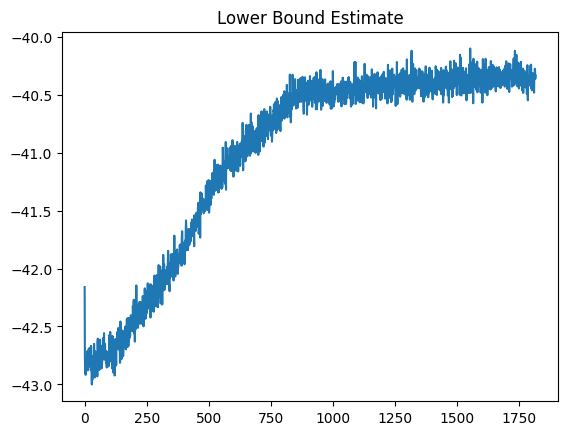

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

lb_df = pd.DataFrame(np.array(LB_estimate))
plt.figure()
lb_df.plot(title = 'Lower Bound Estimate', legend = False)

<Axes: title={'center': 'Smoothed Lower Bound Estimate'}>

<Figure size 640x480 with 0 Axes>

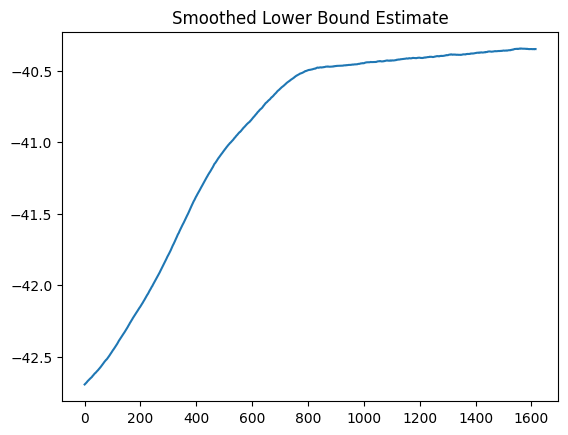

In [21]:
lb_df = pd.DataFrame(np.array(smoothed_LB_estimate))
plt.figure()
lb_df.plot(title = 'Smoothed Lower Bound Estimate', legend = False)

In [22]:
best_lambda_mu

Array([ 0.05259331,  0.05070809, -0.02391443,  0.11113237], dtype=float32)

In [23]:
best_lambda_l

Array([42.761845  , -8.443096  ,  5.374063  , -1.0571915 ,  6.488077  ,
       -1.5154295 ,  2.0535617 ,  0.97605264, -0.09005267,  1.001935  ],      dtype=float32)

In [24]:
best_mu = best_lambda_mu
best_vech_l = list(best_lambda_l)
best_l = jnp.zeros((num_coeffs, num_coeffs))
for i in range(num_coeffs):
    best_l = best_l.at[i:num_coeffs,i].set(best_vech_l[:num_coeffs - i])
    del best_vech_l[:num_coeffs-i]
best_Sigma_inv = best_l @ best_l.T
best_Sigma =  my_inv(best_Sigma_inv)

best_theta_tilde = random.multivariate_normal(subkeys[1], mean = best_mu, cov = best_Sigma, shape = (10000,))
best_alpha = (5 * jnp.exp(best_theta_tilde[0]) + 0) / (1 + jnp.exp(best_theta_tilde[0]))
best_beta = (2 * jnp.exp(best_theta_tilde[1]) + 0) / (1 + jnp.exp(best_theta_tilde[1]))
best_gamma = (3 * jnp.exp(best_theta_tilde[2]) + 0) / (1 + jnp.exp(best_theta_tilde[2]))
best_delta = (1 * jnp.exp(best_theta_tilde[3]) + 0) / (1 + jnp.exp(best_theta_tilde[3]))

best_theta = jnp.array([best_alpha, best_beta, best_gamma, best_delta])
posterior_mean_estimate = jnp.mean(best_theta, axis = 1)
posterior_mean_estimate

Array([2.3155022 , 1.1245408 , 1.6552984 , 0.41356504], dtype=float32)

Text(0.5, 1.0, 'Posterior density of alpha')

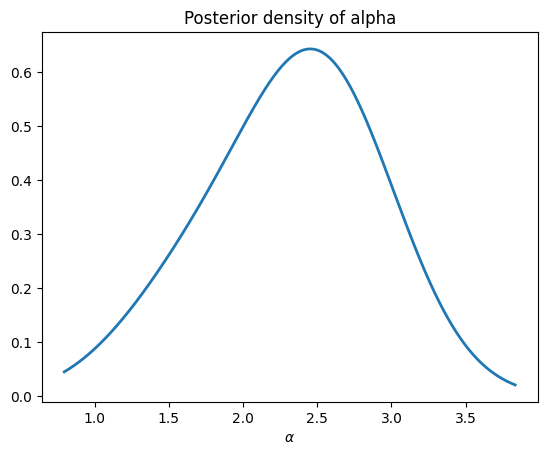

In [27]:
from sklearn.neighbors import KernelDensity

plt.figure()
x_plot = jnp.arange((np.mean(best_alpha)-4*np.std(best_alpha)), (np.mean(best_alpha)+4*np.std(best_alpha)), 0.002)
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(best_alpha.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\alpha$')
plt.title('Posterior density of alpha')

Text(0.5, 1.0, 'Posterior density of beta')

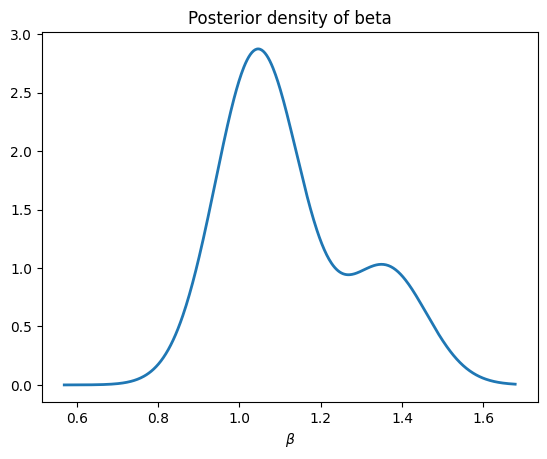

In [28]:
plt.figure()
x_plot = jnp.arange((np.mean(best_beta)-4*np.std(best_beta)), (np.mean(best_beta)+4*np.std(best_beta)), 0.002)
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(best_beta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\beta$')
plt.title('Posterior density of beta')

Text(0.5, 1.0, 'Posterior density of gamma')

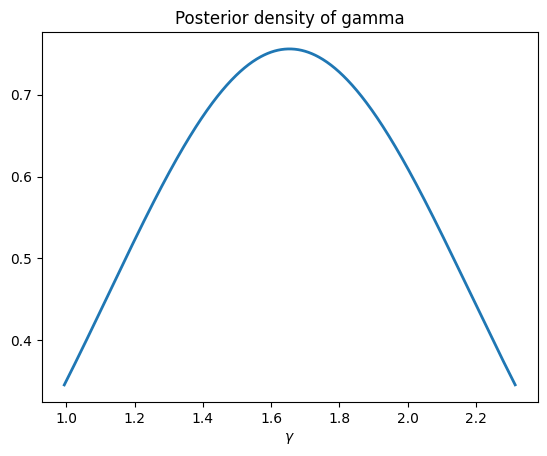

In [30]:
plt.figure()
x_plot = jnp.arange((np.mean(best_gamma)-4*np.std(best_gamma)), (np.mean(best_gamma)+4*np.std(best_gamma)), 0.002)
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(best_gamma.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=2.0)
plt.xlabel(r'$\gamma$')
plt.title('Posterior density of gamma')

Text(0.5, 1.0, 'Posterior density of delta')

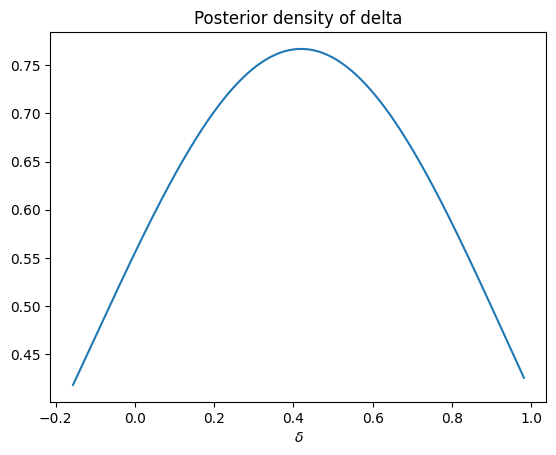

In [31]:
plt.figure()
x_plot = jnp.arange((np.mean(best_delta)-4*np.std(best_delta)), (np.mean(best_delta)+4*np.std(best_delta)), 0.002)
kde = KernelDensity(bandwidth=0.5, kernel='gaussian')
kde.fit(best_delta.reshape(-1, 1))
y_plot = kde.score_samples(x_plot.reshape(-1, 1))
plt.plot(x_plot, np.exp(y_plot), '-', linewidth=1.5)
plt.xlabel(r'$\delta$')
plt.title('Posterior density of delta')